# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [1]:
from datetime import datetime
import pytz
ist = pytz.timezone('Asia/Kolkata')
print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")

Last modified: 11 February 2026, 20:13 IST


# Imports 

In [2]:
import os
import sys
import time
import gc
import psutil
import json
from pathlib import Path
import csv

# Data processing
import uproot
import awkward as ak
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import mplhep as hep

# Numerical computing
import vector
import hist
from hist import Hist
from tqdm import tqdm

# Parallel processing 
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.distributed import progress

# others
!pip install prettytable
from prettytable import PrettyTable

vector.register_awkward()

print(" All imports loaded")

 All imports loaded


## Setting up dask client

In [3]:
client = Client("tls://localhost:8786")
client

<Client: 'tls://192.168.202.7:8786' processes=1 threads=1, memory=2.89 GiB>

# All Directories and path

In [4]:
# BASE PATHS
HOME_DIR = Path(os.environ.get("HOME", "/home/cms-jovyan"))
PROJECT_NAME = "H-to-WW-NanoAOD-analysis"

# DERIVED PATHS
PROJECT_DIR = HOME_DIR / PROJECT_NAME
DATASETS_DIR = PROJECT_DIR / "Datasets"
DATA_DIR = DATASETS_DIR / "DATA"
MC_DIR = DATASETS_DIR / "MC_samples"
AUX_DIR = PROJECT_DIR / "Auxillary_files"
OUTPUT_DIR = PROJECT_DIR / "Outputs"
PLOTS_DIR = OUTPUT_DIR / "Plots"
 
# JSON FILES
GOLDEN_JSON_PATH = AUX_DIR / "Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt"

# RUN PERIODS
RUN_PERIODS_2016 = {
    'Run2016G': {'run_min': 278820, 'run_max': 280385},
    'Run2016H': {'run_min': 280919, 'run_max': 284044}
}
 
# PRINT CONFIGURATION
print(f"HOME_DIR:        {HOME_DIR}")
print(f"PROJECT_DIR:     {PROJECT_DIR}")
print(f"DATA_DIR:        {DATA_DIR}")
print(f"MC_DIR:          {MC_DIR}")
print(f"AUX_DIR:         {AUX_DIR}")
print(f"OUTPUT_DIR:      {OUTPUT_DIR}")
print(f"PLOTS_DIR:       {PLOTS_DIR}")
print(f"JSON exists:     {GOLDEN_JSON_PATH.exists()}")
print(f"GOLDEN_JSON:     {GOLDEN_JSON_PATH}")

HOME_DIR:        /home/cms-jovyan
PROJECT_DIR:     /home/cms-jovyan/H-to-WW-NanoAOD-analysis
DATA_DIR:        /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets/DATA
MC_DIR:          /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets/MC_samples
AUX_DIR:         /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files
OUTPUT_DIR:      /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs
PLOTS_DIR:       /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots
JSON exists:     True
GOLDEN_JSON:     /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Auxillary_files/Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt


## All Dictionaries


In [5]:
# SAMPLE DEFINITIONS

# Sample mapping (for file loading)
SAMPLE_MAPPING = {
    'data': 'Data',
    'higgs': 'ggH_HWW',
    'dytoll': 'DY_to_Tau_Tau',
    'top': 'Top_antitop',
    'fakes': 'Fakes',
    'vz': 'Diboson',
    'ggww': 'ggWW',
    'ww': 'WW',
    'vg': 'VG'
}

# Sample properties (color, signal flag, stacking order)
SAMPLES = {
    "Fakes":          {"color": "#B3B3B3", "is_signal": False, "stack_order": 1},
    "VG":             {"color": "#FFCC00", "is_signal": False, "stack_order": 2},
    "Diboson":        {"color": "#A6CEE3", "is_signal": False, "stack_order": 3},
    "DY_to_Tau_Tau":  {"color": "#33A02C", "is_signal": False, "stack_order": 4},
    "Top_antitop":    {"color": "#FF7F00", "is_signal": False, "stack_order": 5},
    "ggWW":           {"color": "#6BAED6", "is_signal": False, "stack_order": 6},
    "WW":             {"color": "#1F78B4", "is_signal": False, "stack_order": 7},
    "ggH_HWW":        {"color": "#E41A1C", "is_signal": True,  "stack_order": 8},
    "Data":           {"color": "#000000", "is_signal": False, "stack_order": -1},
}

# Derived helper dictionaries
colour = {name: props["color"] for name, props in SAMPLES.items()}
stack_order = {name: props["stack_order"] for name, props in SAMPLES.items() if props["stack_order"] >= 0}

# Sample order for printing (cutflow table)
sample_order = [
    'Data',
    'ggH_HWW',
    'WW',
    'Top_antitop',
    'DY_to_Tau_Tau',
    'Fakes',
    'ggWW',
    'Diboson',
    'VG',
]

# CUTFLOW & ANALYSIS STAGES

# All cutflow stages
cutflow_stages = [
    'total', 'after_json', 'e_mu_preselection', 'global_cuts',
    '0jet', '1jet', '2jet',
    'SR_0jet', 'SR_1jet', 'SR_2jet',
    'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
    'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
]

# Stage names for histogram initialization
stage_names = [
    'before_cuts', 'global', '0jet', '1jet', '2jet',
    'SR_0jet', 'SR_1jet', 'SR_2jet',
    'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
    'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
]

# Stage info: (internal_name, display_name) for cutflow table
stage_info = [
    ('total', 'Total (Raw)'),
    ('e_mu_preselection', 'e-μ Preselect'),
    ('global_cuts', 'Global Cuts'),
    ('0jet', '0-jet'),
    ('1jet', '1-jet'),
    ('2jet', '2-jet'),
    ('SR_0jet', 'SR 0j'),
    ('SR_1jet', 'SR 1j'),
    ('SR_2jet', 'SR 2j'),
    ('CR_top_0jet', 'CR Top 0j'),
    ('CR_top_1jet', 'CR Top 1j'),
    ('CR_top_2jet', 'CR Top 2j'),
    ('CR_tau_0jet', 'CR Tau 0j'),
    ('CR_tau_1jet', 'CR Tau 1j'),
    ('CR_tau_2jet', 'CR Tau 2j'),
]

# HISTOGRAM VARIABLE LABELS

VAR_LABELS = {
    'mass': r'$m_{e\mu}$ [GeV]',
    'met': r'$E_{\mathrm{T}}^{\mathrm{miss}}$ [GeV]',
    'ptll': r'$p_{\mathrm{T}}^{\ell\ell}$ [GeV]',
    'dphi': r'$\Delta\phi(e,\mu)$',
    'mt_higgs': r'$m_{\mathrm{T}}^{H}$ [GeV]',
    'mt_l2_met': r'$m_{\mathrm{T}}(\ell_2, E_{\mathrm{T}}^{\mathrm{miss}})$',
    'mjj': r'$m_{jj}$ [GeV]',
    'leading_pt': r'$p_{\mathrm{T}}^{\mathrm{lead}}$ [GeV]',
    'subleading_pt': r'$p_{\mathrm{T}}^{\mathrm{sub}}$ [GeV]',
}

## Loading Files

In [37]:
def load_urls_from_file(filepath, max_files=None):
    """Load XRootD URLs from text file"""
    urls = []
    if not os.path.exists(filepath):
        return urls
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and line.startswith('root://'):
                urls.append(line)
                if max_files and len(urls) >= max_files:
                    break
    return urls

def load_all_files(data_dir, mc_dir, max_per_sample=None):
    """Load all file URLs from directories"""
    
    files_dict = {}
    
    for directory in [data_dir, mc_dir]:
        if not os.path.exists(directory):
            continue
        for filename in os.listdir(directory):
            if not filename.endswith(('.txt')):
                continue
            filepath = os.path.join(directory, filename)
            filename_lower = filename.lower().replace('.txt', '')
            # Find label
            label = None
            for pattern, sample_label in SAMPLE_MAPPING.items():
                if pattern in filename_lower:
                    label = sample_label
                    break          
            if not label:
                print(f"   Unknown file: {filename} - skipping")
                continue
            
            # Load URLs
            urls = load_urls_from_file(filepath, max_per_sample)
            
            if urls:
                if label in files_dict:
                    files_dict[label].extend(urls)
                else:
                    files_dict[label] = urls
    
    return files_dict

files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=1)  # TESTING
# files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)


FILES TO PROCESS
Data                :    1 files
VG                  :    1 files
ggH_HWW             :    1 files
WW                  :    1 files
Fakes               :    1 files
Diboson             :    1 files
DY_to_Tau_Tau       :    1 files
ggWW                :    1 files
Top_antitop         :    1 files
______________________________________________________________________
TOTAL               :    9 files


# JSON validation functions

In [38]:
def load_golden_json(json_input, run_periods=None):
    """
    Load golden JSON from either a file path (str) or a dict.
    """
    if isinstance(json_input, str):
        with open(json_input, 'r') as f:
            golden_json = json.load(f)
    elif isinstance(json_input, dict):
        golden_json = json_input
    else:
        raise TypeError(f"Expected str or dict, got {type(json_input)}")
    
    valid_lumis = {}
    for run_str, lumi_ranges in golden_json.items():
        run = int(run_str)
        
        # Filter by run periods 
        if run_periods is not None: 
            in_period = any(
                period['run_min'] <= run <= period['run_max']
                for period in run_periods.values()
            )
            if not in_period:
                continue
        
        valid_lumis[run] = [tuple(lr) for lr in lumi_ranges]
    
    return valid_lumis

def apply_json_mask(arrays, json_input, run_periods=None):

    valid_lumis = load_golden_json(json_input, run_periods)    
    runs = ak.to_numpy(arrays.run)
    lumis = ak.to_numpy(arrays.luminosityBlock)
    mask = np. zeros(len(runs), dtype=bool)
    
    for run, lumi_ranges in valid_lumis.items():
        run_mask = (runs == run)
        if not np.any(run_mask):
            continue
        # Check lumi sections 
        run_lumis = lumis[run_mask]
        run_lumi_mask = np.zeros(len(run_lumis), dtype=bool)
        for lumi_start, lumi_end in lumi_ranges: 
            run_lumi_mask |= (run_lumis >= lumi_start) & (run_lumis <= lumi_end)
        mask[run_mask] = run_lumi_mask
    
    return ak.Array(mask)

# Loading branches to use 

In [39]:
# Batch_size = 1_250_000
def load_events(file_url, batch_size=1_250_000, timeout=600, max_retries=3, retry_wait=10, is_data = False):

    columns = [
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        "PuppiMET_pt", "PuppiMET_phi",
        
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]

    if is_data:
        columns.extend(["run","luminosityBlock"])
    else: columns.append("genWeight")
        
    for attempt in range(max_retries):
        try:
            
            with uproot.open(file_url, timeout=timeout) as f:
                tree = f['Events']
                
                
                for arrays in tree.iterate(columns, step_size=batch_size, library="ak"):
                    yield arrays
                
                return
                
        except (TimeoutError, OSError, IOError, ConnectionError) as e:
            error_type = type(e).__name__
            file_name = file_url.split('/')[-1]
            
            if attempt < max_retries - 1:
                print(f"      {error_type} on {file_name}")
                print(f"       Retry {attempt+1}/{max_retries-1} in {retry_wait}s...")
                time.sleep(retry_wait)
            else:
                print(f"     FAILED after {max_retries} attempts: {file_name}")
                print(f"       Error: {str(e)[:100]}")
                raise
                
        except Exception as e:
            
            file_name = file_url.split('/')[-1]
            print(f"     Unexpected error on {file_name}: {str(e)[:100]}")
            raise

# Helper functions

## Kinematic calculations

In [40]:
def wrap_angle_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties """
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

## Electron and Muon eff data

In [41]:
# ==============================================================================
# SCALE FACTOR LOOKUP TABLES (2016 UL)
# Format: (eta_min, eta_max, pt_min, pt_max, SF, Uncertainty)
# Note: Uses Absolute Eta
# ==============================================================================

#Source ---> 
ELECTRON_SF_DATA = [
    # Eta 0.0 - 0.8
    (0.000, 0.800, 10.0, 15.0, 0.9700, 0.0547),
    (0.000, 0.800, 15.0, 20.0, 0.9631, 0.0381),
    (0.000, 0.800, 20.0, 35.0, 0.9661, 0.0131),
    (0.000, 0.800, 35.0, 50.0, 0.9729, 0.0043),
    (0.000, 0.800, 50.0, 90.0, 0.9723, 0.0155),
    (0.000, 0.800, 90.0, 150.0, 0.9942, 0.0118),
    (0.000, 0.800, 150.0, 500.0, 1.0074, 0.0147),
    # Eta 0.8 - 1.442
    (0.800, 1.442, 10.0, 15.0, 1.0501, 0.0719),
    (0.800, 1.442, 15.0, 20.0, 0.9952, 0.0229),
    (0.800, 1.442, 20.0, 35.0, 0.9717, 0.0136),
    (0.800, 1.442, 35.0, 50.0, 0.9743, 0.0073),
    (0.800, 1.442, 50.0, 90.0, 0.9720, 0.0160),
    (0.800, 1.442, 90.0, 150.0, 0.9988, 0.0141),
    (0.800, 1.442, 150.0, 500.0, 0.9931, 0.0198),
    # Eta 1.442 - 1.566
    (1.442, 1.566, 10.0, 15.0, 1.2367, 0.3001),
    (1.442, 1.566, 15.0, 20.0, 1.0399, 0.1848),
    (1.442, 1.566, 20.0, 35.0, 1.0155, 0.1071),
    (1.442, 1.566, 35.0, 50.0, 0.9869, 0.0120),
    (1.442, 1.566, 50.0, 90.0, 1.0000, 0.0244),
    (1.442, 1.566, 90.0, 150.0, 1.0204, 0.0634),
    (1.442, 1.566, 150.0, 500.0, 0.9610, 0.1891),
    # Eta 1.566 - 2.0
    (1.566, 2.000, 10.0, 15.0, 1.0648, 0.1044),
    (1.566, 2.000, 15.0, 20.0, 0.9921, 0.0258),
    (1.566, 2.000, 20.0, 35.0, 0.9850, 0.0166),
    (1.566, 2.000, 35.0, 50.0, 0.9931, 0.0061),
    (1.566, 2.000, 50.0, 90.0, 0.9930, 0.0111),
    (1.566, 2.000, 90.0, 150.0, 1.0148, 0.0159),
    (1.566, 2.000, 150.0, 500.0, 0.9988, 0.0388),
    # Eta 2.0 - 2.5
    (2.000, 2.500, 10.0, 15.0, 1.1624, 0.0554),
    (2.000, 2.500, 15.0, 20.0, 1.0553, 0.0186),
    (2.000, 2.500, 20.0, 35.0, 1.0155, 0.0126),
    (2.000, 2.500, 35.0, 50.0, 1.0113, 0.0055),
    (2.000, 2.500, 50.0, 90.0, 1.0089, 0.0183),
    (2.000, 2.500, 90.0, 150.0, 1.0025, 0.0273),
    (2.000, 2.500, 150.0, 500.0, 1.1318, 0.0541),
]

# Source: 
# Note: Muon tables go up to 200 GeV. >200 will be clamped to last bin.
MUON_ISO_DATA = [
    # Eta 0.0 - 0.2
    (0.0, 0.2, 10, 15, 0.9920, 0.0272), (0.0, 0.2, 15, 20, 0.9869, 0.0215),
    (0.0, 0.2, 20, 25, 1.0033, 0.0162), (0.0, 0.2, 25, 30, 0.9989, 0.0080),
    (0.0, 0.2, 30, 40, 0.9958, 0.0015), (0.0, 0.2, 40, 60, 0.9971, 0.0007),
    (0.0, 0.2, 60, 100, 0.9986, 0.0011), (0.0, 0.2, 100, 200, 1.0016, 0.0034),
    # Eta 0.2 - 0.3
    (0.2, 0.3, 10, 15, 1.0218, 0.0252), (0.2, 0.3, 15, 20, 1.0010, 0.0218),
    (0.2, 0.3, 20, 25, 1.0048, 0.0193), (0.2, 0.3, 25, 30, 0.9989, 0.0088),
    (0.2, 0.3, 30, 40, 0.9976, 0.0013), (0.2, 0.3, 40, 60, 0.9984, 0.0008),
    (0.2, 0.3, 60, 100, 1.0014, 0.0014), (0.2, 0.3, 100, 200, 1.0052, 0.0040),
    # Eta 0.3 - 0.8
    (0.3, 0.8, 10, 15, 1.0164, 0.0177), (0.3, 0.8, 15, 20, 1.0186, 0.0205),
    (0.3, 0.8, 20, 25, 1.0117, 0.0199), (0.3, 0.8, 25, 30, 1.0076, 0.0091),
    (0.3, 0.8, 30, 40, 1.0016, 0.0012), (0.3, 0.8, 40, 60, 0.9999, 0.0005),
    (0.3, 0.8, 60, 100, 1.0004, 0.0006), (0.3, 0.8, 100, 200, 1.0030, 0.0022),
    # Eta 0.8 - 1.2
    (0.8, 1.2, 10, 15, 1.0292, 0.0158), (0.8, 1.2, 15, 20, 1.0242, 0.0182),
    (0.8, 1.2, 20, 25, 1.0242, 0.0210), (0.8, 1.2, 25, 30, 1.0153, 0.0102),
    (0.8, 1.2, 30, 40, 1.0048, 0.0019), (0.8, 1.2, 40, 60, 1.0012, 0.0005),
    (0.8, 1.2, 60, 100, 1.0016, 0.0008), (0.8, 1.2, 100, 200, 0.9999, 0.0021),
    # Eta 1.2 - 1.6
    (1.2, 1.6, 10, 15, 1.0409, 0.0140), (1.2, 1.6, 15, 20, 1.0210, 0.0157),
    (1.2, 1.6, 20, 25, 1.0169, 0.0181), (1.2, 1.6, 25, 30, 1.0141, 0.0099),
    (1.2, 1.6, 30, 40, 1.0050, 0.0011), (1.2, 1.6, 40, 60, 1.0009, 0.0004),
    (1.2, 1.6, 60, 100, 1.0011, 0.0007), (1.2, 1.6, 100, 200, 1.0003, 0.0016),
    # Eta 1.6 - 2.1
    (1.6, 2.1, 10, 15, 1.0488, 0.0084), (1.6, 2.1, 15, 20, 1.0374, 0.0110),
    (1.6, 2.1, 20, 25, 1.0272, 0.0135), (1.6, 2.1, 25, 30, 1.0222, 0.0077),
    (1.6, 2.1, 30, 40, 1.0093, 0.0011), (1.6, 2.1, 40, 60, 1.0030, 0.0004),
    (1.6, 2.1, 60, 100, 1.0019, 0.0007), (1.6, 2.1, 100, 200, 1.0031, 0.0018),
    # Eta 2.1 - 2.4
    (2.1, 2.4, 10, 15, 1.0563, 0.0099), (2.1, 2.4, 15, 20, 1.0348, 0.0104),
    (2.1, 2.4, 20, 25, 1.0267, 0.0105), (2.1, 2.4, 25, 30, 1.0188, 0.0055),
    (2.1, 2.4, 30, 40, 1.0087, 0.0009), (2.1, 2.4, 40, 60, 1.0035, 0.0004),
    (2.1, 2.4, 60, 100, 1.0039, 0.0011), (2.1, 2.4, 100, 200, 1.0076, 0.0050),
]

# Source: User provided Muon Tight ID Table
MUON_TIGHT_DATA = [
    # Eta 0.0 - 0.2
    (0.0, 0.2, 10, 15, 0.9924, 0.0050), (0.0, 0.2, 15, 20, 0.9850, 0.0028),
    (0.0, 0.2, 20, 25, 0.9907, 0.0016), (0.0, 0.2, 25, 30, 0.9909, 0.0015),
    (0.0, 0.2, 30, 40, 0.9917, 0.0008), (0.0, 0.2, 40, 60, 0.9911, 0.0009),
    (0.0, 0.2, 60, 100, 0.9913, 0.0012), (0.0, 0.2, 100, 200, 0.9915, 0.0026),
    # Eta 0.2 - 0.3
    (0.2, 0.3, 10, 15, 0.9610, 0.0102), (0.2, 0.3, 15, 20, 0.9658, 0.0058),
    (0.2, 0.3, 20, 25, 0.9719, 0.0030), (0.2, 0.3, 25, 30, 0.9701, 0.0027),
    (0.2, 0.3, 30, 40, 0.9698, 0.0012), (0.2, 0.3, 40, 60, 0.9691, 0.0016),
    (0.2, 0.3, 60, 100, 0.9721, 0.0038), (0.2, 0.3, 100, 200, 0.9516, 0.0071),
    # Eta 0.3 - 0.8
    (0.3, 0.8, 10, 15, 0.9879, 0.0045), (0.3, 0.8, 15, 20, 0.9907, 0.0014),
    (0.3, 0.8, 20, 25, 0.9925, 0.0011), (0.3, 0.8, 25, 30, 0.9915, 0.0009),
    (0.3, 0.8, 30, 40, 0.9919, 0.0005), (0.3, 0.8, 40, 60, 0.9916, 0.0005),
    (0.3, 0.8, 60, 100, 0.9899, 0.0009), (0.3, 0.8, 100, 200, 0.9891, 0.0017),
    # Eta 0.8 - 1.2
    (0.8, 1.2, 10, 15, 0.9794, 0.0060), (0.8, 1.2, 15, 20, 0.9800, 0.0030),
    (0.8, 1.2, 20, 25, 0.9807, 0.0014), (0.8, 1.2, 25, 30, 0.9832, 0.0008),
    (0.8, 1.2, 30, 40, 0.9818, 0.0010), (0.8, 1.2, 40, 60, 0.9816, 0.0005),
    (0.8, 1.2, 60, 100, 0.9801, 0.0009), (0.8, 1.2, 100, 200, 0.9806, 0.0023),
    # Eta 1.2 - 1.6
    (1.2, 1.6, 10, 15, 0.9897, 0.0069), (1.2, 1.6, 15, 20, 0.9912, 0.0037),
    (1.2, 1.6, 20, 25, 0.9934, 0.0026), (1.2, 1.6, 25, 30, 0.9952, 0.0018),
    (1.2, 1.6, 30, 40, 0.9943, 0.0015), (1.2, 1.6, 40, 60, 0.9947, 0.0013),
    (1.2, 1.6, 60, 100, 0.9946, 0.0017), (1.2, 1.6, 100, 200, 0.9922, 0.0025),
    # Eta 1.6 - 2.1
    (1.6, 2.1, 10, 15, 0.9858, 0.0030), (1.6, 2.1, 15, 20, 0.9848, 0.0016),
    (1.6, 2.1, 20, 25, 0.9874, 0.0020), (1.6, 2.1, 25, 30, 0.9862, 0.0012),
    (1.6, 2.1, 30, 40, 0.9863, 0.0008), (1.6, 2.1, 40, 60, 0.9859, 0.0008),
    (1.6, 2.1, 60, 100, 0.9858, 0.0010), (1.6, 2.1, 100, 200, 0.9830, 0.0024),
    # Eta 2.1 - 2.4
    (2.1, 2.4, 10, 15, 0.9716, 0.0071), (2.1, 2.4, 15, 20, 0.9697, 0.0045),
    (2.1, 2.4, 20, 25, 0.9766, 0.0036), (2.1, 2.4, 25, 30, 0.9765, 0.0031),
    (2.1, 2.4, 30, 40, 0.9751, 0.0024), (2.1, 2.4, 40, 60, 0.9737, 0.0023),
    (2.1, 2.4, 60, 100, 0.9736, 0.0051), (2.1, 2.4, 100, 200, 0.9729, 0.0053),
]

In [42]:
def get_sf_with_uncertainty(eta_array, pt_array, lookup_table):
    """
    Returns (sf_nominal, sf_error) for input eta and pt arrays 
    based on the provided lookup table.
    """
    # Initialize outputs with default values (SF=1.0, Err=0.0)
    sf_out = ak.ones_like(eta_array, dtype=float)
    err_out = ak.zeros_like(eta_array, dtype=float)
    
    # We use abs(eta) for lookup
    eta_abs = abs(eta_array)
    
    for (eta_min, eta_max, pt_min, pt_max, sf_val, err_val) in lookup_table:
        # Create mask for this bin
        # Note: pt >= pt_max checks for the overflow bin (last bin in range)
        # If the table has a defined max like 500, we strictly follow it or 
        # assume the last bin extends to infinity. 
        # Here we use standard range logic:
        
        mask = (eta_abs >= eta_min) & (eta_abs < eta_max) & \
               (pt_array >= pt_min) & (pt_array < pt_max)
        
        # Apply values
        sf_out = ak.where(mask, sf_val, sf_out)
        err_out = ak.where(mask, err_val, err_out)
        
    # Handle Overflow (Pt > max_pt in table)
    # We assign the value of the highest Pt bin for that Eta range
    # Find the max pt for each eta bin in the table to automate this?
    # Simplified approach: Re-loop and check if pt >= max_pt of the last bin
    
    return sf_out, err_out

In [43]:
# def get_electron_id_sf(eta_array, pt_array):
#     eta_bins = np.array([0.0, 0.8, 1.442, 1.566, 2.0, 2.5])
    
#     pt_bins = np.array([10.0, 15.0, 20.0, 35.0, 50.0, 90.0, 150.0, 500.0])

#     sf_values = np.array([
#         [0.9700, 0.9631, 0.9661, 0.9729, 0.9723, 0.9942, 1.0074],
#         [1.0501, 0.9952, 0.9717, 0.9743, 0.9720, 0.9988, 0.9931],
#         [1.2367, 1.0399, 1.0155, 0.9869, 1.0000, 1.0204, 0.9610],
#         [1.0648, 0.9921, 0.9850, 0.9931, 0.9930, 1.0148, 0.9988],
#         [1.1624, 1.0553, 1.0155, 1.0113, 1.0089, 1.0025, 1.1318]
#     ])

#     eta_abs = np.abs(ak.to_numpy(eta_array))
#     pt_clipped = np.clip(ak.to_numpy(pt_array), 10.01, 499.99)

#     eta_indices = np.digitize(eta_abs, eta_bins) - 1
#     pt_indices = np.digitize(pt_clipped, pt_bins) - 1

#     eta_indices = np.clip(eta_indices, 0, len(eta_bins) - 2)
#     pt_indices = np.clip(pt_indices, 0, len(pt_bins) - 2)

#     weights = sf_values[eta_indices, pt_indices]
    
#     return weights

## Muon TIght SF

In [44]:
# def get_muon_tight_id_sf(eta_array, pt_array):
#     eta_bins = np.array([0.0, 0.2, 0.3, 0.8, 1.2, 1.6, 2.1, 2.4])
#     pt_bins = np.array([10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 60.0, 100.0, 200.0])
#     sf_values = np.array([
#         [0.9924, 0.9850, 0.9907, 0.9909, 0.9917, 0.9911, 0.9913, 0.9915],
#         [0.9610, 0.9658, 0.9719, 0.9701, 0.9698, 0.9691, 0.9721, 0.9516],
#         [0.9879, 0.9907, 0.9925, 0.9915, 0.9919, 0.9916, 0.9899, 0.9891],
#         [0.9794, 0.9800, 0.9807, 0.9832, 0.9818, 0.9816, 0.9801, 0.9806],
#         [0.9897, 0.9912, 0.9934, 0.9952, 0.9943, 0.9947, 0.9946, 0.9922],
#         [0.9858, 0.9848, 0.9874, 0.9862, 0.9863, 0.9859, 0.9858, 0.9830],
#         [0.9716, 0.9697, 0.9766, 0.9765, 0.9751, 0.9737, 0.9736, 0.9729]
#     ])
#     eta_abs = np.abs(ak.to_numpy(eta_array))
#     pt_clipped = np.clip(ak.to_numpy(pt_array), 10.01, 199.99)
#     eta_indices = np.digitize(eta_abs, eta_bins) - 1
#     pt_indices = np.digitize(pt_clipped, pt_bins) - 1

#     eta_indices = np.clip(eta_indices, 0, len(eta_bins) - 2)
#     pt_indices = np.clip(pt_indices, 0, len(pt_bins) - 2)
#     weights = sf_values[eta_indices, pt_indices]
    
#     return weights

## Muoon ISO SF

In [45]:
# def get_muon_iso_sf(eta_array, pt_array):
#     eta_bins = np.array([0.0, 0.2, 0.3, 0.8, 1.2, 1.6, 2.1, 2.4])
#     pt_bins = np.array([10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 60.0, 100.0, 200.0])
#     sf_values = np.array([
#         [0.9920, 0.9869, 1.0033, 0.9989, 0.9958, 0.9971, 0.9986, 1.0016],
#         [1.0218, 1.0010, 1.0048, 0.9989, 0.9976, 0.9984, 1.0014, 1.0052],
#         [1.0164, 1.0186, 1.0117, 1.0076, 1.0016, 0.9999, 1.0004, 1.0030],
#         [1.0292, 1.0242, 1.0242, 1.0153, 1.0048, 1.0012, 1.0016, 0.9999],
#         [1.0409, 1.0210, 1.0169, 1.0141, 1.0050, 1.0009, 1.0011, 1.0003],
#         [1.0488, 1.0374, 1.0272, 1.0222, 1.0093, 1.0030, 1.0019, 1.0031],
#         # [1.0563, 1.0348, 1.0267, 1.0188, 1.0087, 1.0035, 1.0039, 1.0076]
#     ])
#     eta_abs = np.abs(ak.to_numpy(eta_array))
#     pt_clipped = np.clip(ak.to_numpy(pt_array), 10.01, 199.99)
#     eta_indices = np.digitize(eta_abs, eta_bins) - 1
#     pt_indices = np.digitize(pt_clipped, pt_bins) - 1
#     eta_indices = np.clip(eta_indices, 0, len(eta_bins) - 2)
#     pt_indices = np.clip(pt_indices, 0, len(pt_bins) - 2)

#     weights = sf_values[eta_indices, pt_indices]
    
#     return weights

# Event Selection

## Pre-Selection

### Selecting tight leptons (Electrons and Muon)

In [46]:
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

### Selecting Electron and Muon candidates

In [47]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=13):
    """Select events with exactly 1 electron and 1 muon"""
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    # Require exactly 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    # mask_loose_veto = ak.num(loose_leptons)
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    # Pre-Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    eta_leading = ((leading.flavor == 11) & (abs(leading.eta) < 2.5)) | \
                       ((leading.flavor == 13) & (abs(leading.eta) < 2.4))
    eta_subleading = ((subleading.flavor == 11) & (abs(subleading.eta) < 2.5)) | \
                          ((subleading.flavor == 13) & (abs(subleading.eta) < 2.4))
    mask_eta = eta_leading & eta_subleading
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt & mask_eta
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]

## Counting jets and 0/1/2 Jet categorisation

In [48]:
def count_jets(arrays, jet_pt_threshold=30, tight_leptons=None):
    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays.Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays.Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays.Jet_btagDeepFlavB,
        "puId": arrays.Jet_puId 
    })
    # Step 2: Good jet selection
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.eta) < 4.7) & pu_id_mask
    # Step 3: Lepton cleaning
    if tight_leptons is not None and ak.max(ak.num(tight_leptons)) > 0:
        # Delta R calculation
        jets_eta = jets.eta[:, :, None]
        jets_phi = jets.phi[:, :, None]
        leps_eta = tight_leptons.eta[:, None, :]
        leps_phi = tight_leptons.phi[:, None, :]
        
        deta = jets_eta - leps_eta
        dphi = (jets_phi - leps_phi + np.pi) % (2 * np.pi) - np.pi
        dr = np.sqrt(deta**2 + dphi**2)
        
        min_dr = ak.min(dr, axis=-1)
        
        min_dr = ak.fill_none(min_dr, 999.0)
        good_mask = good_mask & (min_dr > 0.4)
    
    good_jets = jets[good_mask]
    
    # Step 4: Sort by pT
    sorted_jets = good_jets[ak.argsort(good_jets.pt, axis=1, ascending=False)]
    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt), 0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets[:, 1:].pt), 0)
    # Step 5: Category masks based on jet count
    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold) # At least 2 jets
    
    n_jets = ak.sum(sorted_jets.pt >= jet_pt_threshold, axis=1)
    
    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet

## bjet categorization

In [49]:
def get_bjet_categories(arrays, btag_threshold=0.2217, eta_max=2.5):
    """
    Get different b-jet categories needed for SR/CR selection.
    """
    # Base b-jet selection 
    base_bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )
    # Different pT categories
    bjets_20 = base_bjet_mask & (arrays.Jet_pt > 20)
    bjets_20_30 = base_bjet_mask & (arrays.Jet_pt > 20) & (arrays.Jet_pt <= 30)
    bjets_30 = base_bjet_mask & (arrays.Jet_pt > 30)
    # Count per event
    n_bjets_20 = ak.sum(bjets_20, axis=1)
    n_bjets_20_30 = ak.sum(bjets_20_30, axis=1) 
    n_bjets_30 = ak.sum(bjets_30, axis=1)
    return {
        # For Signal Regions 
        'passes_bjet_veto': n_bjets_20 == 0,  
        # For Control Regions
        'has_btag_20_30': n_bjets_20_30 > 0,  # Top CR 0-jet
        'has_btag_30': n_bjets_30 > 0,        # Top CR 1-jet, 2-jet
        # Counts
        'n_bjets_20': n_bjets_20,
        'n_bjets_20_30': n_bjets_20_30,
        'n_bjets_30': n_bjets_30
    }

def apply_bjet_selections(arrays):
    bjet_info = get_bjet_categories(arrays)
    # For Signal Regions
    sr_bjet_veto = bjet_info['passes_bjet_veto']
    # For Control Regions
    cr_top_0jet = bjet_info['has_btag_20_30']
    cr_top_1jet_2jet = bjet_info['has_btag_30']
    return sr_bjet_veto, bjet_info

## Global Cuts


In [50]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    # Combine all masks
    global_mask =  mask_met_pt & mask_ptll & mask_mll
    return global_mask, {
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

## Signal regions

In [51]:
def apply_signal_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                           mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                           bjet_veto_mask, mjj=None):
    """Apply Signal Region selections for all jet categories."""
    sr_specific_cuts = (
                        ( met.pt > 20) &
                        ( ptlls > 30) &
                       ( masses > 12)  &
                        (mt_higgs >60) &
                        (mt_l2_met >30) &
                        bjet_veto_mask        
                        )
    sr_base =  sr_specific_cuts
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    sr_regions = {
        'SR_0jet': sr_base & isZeroJet,
        'SR_1jet': sr_base & isOneJet,
        'SR_2jet': sr_base & isTwoJet & mjj_window
    }
    return sr_regions

## control region

In [52]:
def apply_control_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                            mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                            bjet_info, mjj=None):
    """Apply Control Region selections for all jet categories."""
    cr_base = (
        (met.pt > 20) &
        (ptlls > 30) &
        (mt_l2_met > 30)    &
        (masses > 12)
    )
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    cr_regions = {}
    # === TOP CONTROL REGIONS ===
    cr_top_base = cr_base & (masses > 50)
    cr_regions['CR_top_0jet'] = (
        cr_top_base & 
        isZeroJet & 
        bjet_info['has_btag_20_30']  # 20 < pT < 30 GeV b-jets for 0-jet
    )
    cr_regions['CR_top_1jet'] = (
        cr_top_base & 
        isOneJet & 
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 1-jet
    )
    cr_regions['CR_top_2jet'] = (
        cr_top_base & 
        isTwoJet & 
        mjj_window &
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 2-jet
    )
    # === TAU-TAU CONTROL REGIONS ===
    cr_tau_base = (
        cr_base & 
        (mt_higgs < 60) & 
        (masses > 40) & 
        (masses < 80) &
        bjet_info['passes_bjet_veto']  
    )
    cr_regions['CR_tau_0jet'] = cr_tau_base & isZeroJet
    cr_regions['CR_tau_1jet'] = cr_tau_base & isOneJet  
    cr_regions['CR_tau_2jet'] = cr_tau_base & isTwoJet & mjj_window
    return cr_regions

---
# Calculations 

## Calculating  kinematic variables 
- Invariant mass of dilepton(electron and muon) system
- Transverse momentum of dilepton system
- Azimuathal seperation between dileptons
- Transverse mass of Higgs
- Transvers mass of subleading lepton and $E^T_{miss}$ 
  

In [53]:
def cal_kinematic_var(leading, subleading, met):
    # Create vectors
    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)
    dilepton = lepton_1 + lepton_2
    #  Basic Variables
    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)
    # Higgs Transverse Mass 
    dll_et = np.sqrt(dilepton.pt**2 + dilepton.mass**2)
    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    term_1 = masses**2
    term_2 = 2 * (dll_et * met.pt - dilepton.pt * met.pt * np.cos(mt_higgs_dphi))
    mt_higgs = np.sqrt(term_1 + term_2)
    # Lepton 2 Transverse Mass
    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))

    return masses, ptll, dphi, mt_higgs, mt_l2_met

## Calculating Invriant mass of jets and applying $m_{jj}$

In [54]:
def calculate_mjj(jets):
    # Get number of jets per event
    n_jets = ak.num(jets)
    # Initialize mjj with zeros for all events
    mjj = ak.zeros_like(n_jets, dtype=float)
    # Create mask for events with at least 2 jets
    has_two_jets = n_jets >= 2
    # Only proceed if there are events with 2+ jets
    if ak.any(has_two_jets):
        # Use padding to safely access indices
        jets_padded = ak.pad_none(jets, 2, axis=1)
        # Create 4-vectors for jets
        jet_vectors = ak.zip({
            "pt": ak.fill_none(jets_padded.pt, 0.0),
            "eta": ak.fill_none(jets_padded.eta, 0.0),
            "phi": ak.fill_none(jets_padded.phi, 0.0),
            "mass": ak.fill_none(jets_padded.mass, 0.0)
        }, with_name="Momentum4D")
        # Get first two jets
        jet1 = jet_vectors[:, 0]
        jet2 = jet_vectors[:, 1]
        # Calculate invariant mass using vector addition
        dijet = jet1 + jet2
        mjj_calculated = dijet.mass
        # Apply only where we have 2+ jets
        mjj = ak.where(has_two_jets, mjj_calculated, 0.0)
    
    return mjj

def apply_mjj_window(mjj):
    return (mjj < 65) | ((mjj > 105) & (mjj < 120))

# Histogram Initialization

In [55]:
# variables_to_plots = {
#         'mass': hist.axis.Regular(20, 0, 200, name="mass", label="m_ll [GeV]"),
#         'met': hist.axis.Regular(20, 0, 200, name="met", label="MET [GeV]"),
#         'dphi': hist.axis.Regular(20, 0, np.pi, name="dphi", label="dphi(l,l)"),
#         'ptll': hist.axis.Regular(20, 0, 200, name="ptll", label="p_T^ll [GeV]"),
#         'mt_higgs': hist.axis.Regular(20, 0, 300, name="mt_higgs", label="m_T^H [GeV]"),
#         'mt_l2_met': hist.axis.Regular(20, 0, 200, name="mt_l2_met", label="m_T(l2,MET) [GeV]"),
#         'mjj': hist.axis.Regular(20, 0, 500, name="mjj", label="m_jj [GeV]"),
#         'leading_pt': hist.axis.Regular(20, 0, 200, name="leading_pt", label="Leading lepton p_T [GeV]"),
#         'subleading_pt': hist.axis.Regular(20, 0, 200, name="subleading_pt", label="Subleading lepton p_T [GeV]"),
#     }

# # def initialize_stage_histograms():
# #     """Initialize histograms for all selection stages"""
# #     stage_histograms = {}
# #     for stage in stage_names:
# #         stage_histograms[stage] = {
# #             var_name: Hist(axis) for var_name, axis in variables_to_plots.items()
# #         }
# #     return stage_histograms
   
# # Initialize for all samples
# hist_data = {}

# for label in sorted(stack_order.keys(), key=lambda x: stack_order[x]):
#     hist_data[label] = initialize_stage_histograms()

# print("Histogram storage initialized")

In [56]:
import hist
import numpy as np

# ==============================================================================
# 1. DEFINE VARIATIONS (Must match the worker function!)
# ==============================================================================
VARIATIONS = ['nominal', 'trigger_up', 'trigger_down', 'ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']

# ==============================================================================
# 2. DEFINE VARIABLES TO PLOT
# ==============================================================================
variables_to_plots = {
    'mass': hist.axis.Regular(20, 0, 200, name="mass", label="m_ll [GeV]"),
    'met': hist.axis.Regular(20, 0, 200, name="met", label="MET [GeV]"),
    'dphi': hist.axis.Regular(20, 0, np.pi, name="dphi", label="dphi(l,l)"),
    'ptll': hist.axis.Regular(20, 0, 200, name="ptll", label="p_T^ll [GeV]"),
    'mt_higgs': hist.axis.Regular(20, 0, 300, name="mt_higgs", label="m_T^H [GeV]"),
    'mt_l2_met': hist.axis.Regular(20, 0, 200, name="mt_l2_met", label="m_T(l2,MET) [GeV]"),
    'mjj': hist.axis.Regular(20, 0, 500, name="mjj", label="m_jj [GeV]"),
    'leading_pt': hist.axis.Regular(20, 0, 200, name="leading_pt", label="Leading lepton p_T [GeV]"),
    'subleading_pt': hist.axis.Regular(20, 0, 200, name="subleading_pt", label="Subleading lepton p_T [GeV]"),
}

# ==============================================================================
# 3. INITIALIZATION FUNCTION (UPDATED FOR SYSTEMATICS)
# ==============================================================================
def initialize_stage_histograms():
    """
    Initialize histograms for all selection stages, variables, AND variations.
    Structure: Dictionary[Stage][Variable][Variation] -> Hist object
    """
    stage_histograms = {}
    
    for stage in stage_names:
        stage_histograms[stage] = {}
        
        for var_name, axis in variables_to_plots.items():
            stage_histograms[stage][var_name] = {}
            
            # Create a separate histogram for every variation (nominal, up, down, etc.)
            for syst in VARIATIONS:
                # storage=hist.storage.Weight() is REQUIRED for correct error propagation
                stage_histograms[stage][var_name][syst] = hist.Hist(axis, storage=hist.storage.Weight())
                
    return stage_histograms

# ==============================================================================
# 4. INITIALIZE STORAGE FOR ALL SAMPLES
# ==============================================================================
hist_data = {}

# Ensure stack_order is defined (usually from previous cells)
for label in sorted(stack_order.keys(), key=lambda x: stack_order[x]):
    hist_data[label] = initialize_stage_histograms()

print(f"Histogram storage initialized for {len(hist_data)} samples.")
print(f"Structure depth: Stage -> Variable -> Variation ({len(VARIATIONS)} variations)")

Histogram storage initialized for 8 samples.
Structure depth: Stage -> Variable -> Variation (7 variations)


# Sample Configuration: X-sec and Luminosity 

In [57]:
# Luminosity for 2016 UltraLegacy  (pb^-1)

## CAN TRANSFER TO ANOTHER FILE
LUMINOSITY = 16_150.0 

sample_info_detailed = {
    # --- DRELL-YAN ---
    "DYJetsToLL_M-50":      { "xsec": 6189.39, "sum_genWeight": 82448537.0 },
    # --- TOP QUARK ---
    "TTTo2L2Nu":            { "xsec": 87.31, "sum_genWeight": 3140127171.4748 },
    "ST_t-channel_top":     { "xsec": 44.33, "sum_genWeight": 6703802049.126 },
    "ST_t-channel_antitop": { "xsec": 26.38, "sum_genWeight": 1522100315.652 },
    "ST_tW_top":            { "xsec": 35.60, "sum_genWeight": 20635251.1008 },
    "ST_tW_antitop":        { "xsec": 35.60, "sum_genWeight": 27306324.658 },
    "ST_s-channel":         { "xsec": 3.36,  "sum_genWeight": 19429336.179 },
    # --- FAKES ---
    "WJetsToLNu":           { "xsec": 61526.7, "sum_genWeight": 9697410121705.164 },
    "TTToSemiLeptonic":     { "xsec": 364.35,  "sum_genWeight": 43548253725.284 },
    # --- V+GAMMA ---
    "ZGToLLG":              { "xsec": 58.83,   "sum_genWeight": 3106465270.711 },
    "WGToLNuG":             { "xsec": 405.271, "sum_genWeight": 3353413.0 },
    # --- DIBOSON ---
    "WZTo3LNu":             { "xsec": 4.42965, "sum_genWeight": 4077550.6318 },
    "WZTo2Q2L":             { "xsec": 5.595,   "sum_genWeight": 129756627.882 },
    "ZZ":                   { "xsec": 16.523,  "sum_genWeight": 1151000.0 },
    # --- SIGNAL & IRREDUCIBLE ---
    "GluGluToWW":           { "xsec": 0.06387, "sum_genWeight": 17662000.0 },
    "WWTo2L2Nu":            { "xsec": 12.178,  "sum_genWeight": 32147079.595 },
    "Higgs":                { "xsec": 1.0315,  "sum_genWeight": 63281816.82 }
}


# DATA/MC CORRECTIONS
# Trigger Efficiency 
trig_nom = 0.9129
trig_up  = 0.9129 + 0.0008
trig_down= 0.9129 - 0.0008


# Processing

## Processing function

In [58]:
# variations = ['nominal', 'trigger_up', 'trigger_down', 'ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']
# weights_dict = {v: base_weight for v in variations} # Initialize with base weight

In [59]:
def make_processor(golden_json_data, sample_info_detailed, luminosity, run_periods):

    # --- CONSTANTS & VARIATIONS ---
    VARIATIONS = ['nominal', 'trigger_up', 'trigger_down', 'ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']
    
    # Trigger Uncertainties (Absolute)
    TRIGGER_SF_VAL = 0.9129
    TRIGGER_SF_ERR = 0.0008

    def get_sample_key(filename):
        fn = filename
        # Data Check
        if any(x in fn for x in ["Run2016", "SingleMuon", "DoubleEG", "MuonEG"]): return None
        # MC Matching Logic
        if "DYJetsToLL" in fn:         return "DYJetsToLL_M-50"
        if "TTTo2L2Nu" in fn:          return "TTTo2L2Nu"
        if "ST_t-channel_top" in fn:   return "ST_t-channel_top"
        if "ST_t-channel_antitop" in fn: return "ST_t-channel_antitop"
        if "ST_tW_antitop" in fn:      return "ST_tW_antitop"
        if "ST_tW_top" in fn:          return "ST_tW_top"
        if "ST_s-channel" in fn:       return "ST_s-channel"
        if "WJetsToLNu" in fn:         return "WJetsToLNu"
        if "TTToSemiLeptonic" in fn:   return "TTToSemiLeptonic"
        if "ZGToLLG" in fn:            return "ZGToLLG"
        if "WGToLNuG" in fn:           return "WGToLNuG"
        if "WZTo3LNu" in fn:           return "WZTo3LNu"
        if "WZTo2Q2L" in fn:           return "WZTo2Q2L"
        if "ZZ" in fn:                 return "ZZ"
        if "GluGluToWW" in fn:         return "GluGluToWW"
        if "WWTo2L2Nu" in fn:          return "WWTo2L2Nu"
        if "GluGluHToWW" in fn or "Higgs" in fn: return "Higgs"
        
        return "Unknown" 

    # --- WORKER FUNCTION ---
    def processing_file(label, file_url, file_idx):
        import uproot
        import awkward as ak
        import numpy as np
        import vector
        import time
        import hist # Ensure hist is imported for storage.Weight()
        
        vector.register_awkward()
        
        file_name = file_url.split('/')[-1] 
        is_data = (label == 'Data')
        
        specific_sample_key = get_sample_key(file_url)

        empty_cutflow = {stage: 0 for stage in cutflow_stages}
        
        # --- Updated Histogram Initialization ---
        def initialize_stage_histograms_local():
            stage_histograms = {}
            for stage in stage_names:
                stage_histograms[stage] = {}
                for var_name, axis in variables_to_plots.items():
                    stage_histograms[stage][var_name] = {}
                    for syst in VARIATIONS:
                        stage_histograms[stage][var_name][syst] = Hist(axis, storage=hist.storage.Weight())
            return stage_histograms

        # --- Updated Fill Function ---
        def fill_histograms(stage_name, mask, weights_dict, 
                           masses, met_pt, dphis, ptlls,
                           mt_higgs, mt_l2_met, mjj,
                           leading_pt, subleading_pt):
            
            if not isinstance(mask, np.ndarray):
                mask = ak.to_numpy(mask)

            if np.sum(mask) == 0:
                return

            def masked(arr, flatten=False):
                sliced = arr[mask]
                if flatten:
                    sliced = ak.flatten(sliced)
                return ak.to_numpy(sliced)

            # Loop over all systematic variations
            for syst in VARIATIONS:
                w_syst = weights_dict.get(syst, weights_dict['nominal'])
                w = masked(w_syst)

                stage_histograms[stage_name]['mass'][syst].fill(masked(masses), weight=w)
                stage_histograms[stage_name]['met'][syst].fill(masked(met_pt), weight=w)
                stage_histograms[stage_name]['dphi'][syst].fill(masked(dphis), weight=w)
                stage_histograms[stage_name]['ptll'][syst].fill(masked(ptlls), weight=w)
                stage_histograms[stage_name]['mt_higgs'][syst].fill(masked(mt_higgs), weight=w)
                stage_histograms[stage_name]['mt_l2_met'][syst].fill(masked(mt_l2_met), weight=w)
                stage_histograms[stage_name]['mjj'][syst].fill(masked(mjj), weight=w)
                stage_histograms[stage_name]['leading_pt'][syst].fill(masked(leading_pt), weight=w)
                stage_histograms[stage_name]['subleading_pt'][syst].fill(masked(subleading_pt), weight=w)
        
        try:
            # Use local initialization
            stage_histograms = initialize_stage_histograms_local()
            cutflow = empty_cutflow.copy()
            weighted_cutflow = {stage: 0.0 for stage in cutflow_stages}
            
            max_file_retries = 3
            
            for file_attempt in range(max_file_retries):
                try:
                    for arrays in load_events(file_url, batch_size=1_250_000, is_data=is_data):
                        
                        cutflow['total'] += len(arrays)

                        # --- SCALING & VARIATIONS INITIALIZATION ---
                        if is_data:
                            base_weight = ak.ones_like(arrays.PuppiMET_pt, dtype=float)
                        elif specific_sample_key in sample_info_detailed:
                            info = sample_info_detailed[specific_sample_key]
                            scale_factor = (info['xsec'] * luminosity) / info['sum_genWeight']
                            base_weight = arrays.genWeight * scale_factor
                        else:
                            base_weight = ak.zeros_like(arrays.PuppiMET_pt, dtype=float)

                        # Initialize Dictionary of Weights
                        weights_dict = {v: base_weight for v in VARIATIONS}

                        # --- APPLY TRIGGER SF & UNCERTAINTY (MC ONLY) ---
                        if not is_data:
                            weights_dict['nominal'] = weights_dict['nominal'] * TRIGGER_SF_VAL
                            weights_dict['trigger_up']   = weights_dict['trigger_up'] * (TRIGGER_SF_VAL + TRIGGER_SF_ERR)
                            weights_dict['trigger_down'] = weights_dict['trigger_down'] * (TRIGGER_SF_VAL - TRIGGER_SF_ERR)
                            
                            for var in ['ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']:
                                weights_dict[var] = weights_dict[var] * TRIGGER_SF_VAL

                        weighted_cutflow['total'] += float(ak.sum(weights_dict['nominal']))
                        
                        # --- JSON MASK (DATA ONLY) ---
                        if is_data and golden_json_data is not None:
                            try:
                                json_mask = apply_json_mask(arrays, golden_json_data, run_periods=run_periods)
                                n_events_after = int(ak.sum(json_mask))
                                cutflow['after_json'] += n_events_after
                                weighted_cutflow['after_json'] += float(ak.sum(weights_dict['nominal'][json_mask]))

                                if n_events_after == 0:
                                    continue

                                arrays = arrays[json_mask]
                                for k in weights_dict:
                                    weights_dict[k] = weights_dict[k][json_mask]
                            except Exception as e: 
                                print(f"Warning: JSON mask failed for {file_name}: {e}")
                        
                        # --- LEPTON SELECTION ---
                        tight_leptons, _, _ = select_tight_leptons(arrays)
                        met = ak.zip({"pt": arrays.PuppiMET_pt, "phi": arrays.PuppiMET_phi})
                        
                        leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
                        
                        if leading is None or len(leading) == 0:
                            continue

                        sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
                        has_2lep = ak.num(sorted_leptons) == 2
                        events_2lep = sorted_leptons[has_2lep]
                        
                        if len(events_2lep) == 0:
                            continue
                        
                        lead_all = events_2lep[:, 0]
                        sublead_all = events_2lep[:, 1]
                        
                        mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                                     ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
                        mask_charge = lead_all.charge * sublead_all.charge < 0
                        mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 13)
                        
                        eta_leading = ((lead_all.flavor == 11) & (abs(lead_all.eta) < 2.5)) | \
                                      ((lead_all.flavor == 13) & (abs(lead_all.eta) < 2.4))

                        eta_subleading = ((sublead_all.flavor == 11) & (abs(sublead_all.eta) < 2.5)) | \
                                         ((sublead_all.flavor == 13) & (abs(sublead_all.eta) < 2.4))
                        
                        mask_eta = eta_leading & eta_subleading
                        
                        emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt & mask_eta
                        
                        indices_2lep = ak.where(has_2lep)[0]
                        indices_selected = ak.to_numpy(indices_2lep[emu_mask_2lep])
                        
                        emu_mask_full = np.zeros(len(has_2lep), dtype=bool)
                        emu_mask_full[indices_selected] = True
                        
                        for k in weights_dict:
                            weights_dict[k] = weights_dict[k][emu_mask_full]

                        # --- LEPTON SCALE FACTORS & UNCERTAINTIES (MC ONLY) ---
                        if not is_data:
                            # 1. Prepare Electron SFs
                            is_lead_ele = (leading.flavor == 11)
                            ele_pt = ak.where(is_lead_ele, leading.pt, subleading.pt)
                            ele_eta = ak.where(is_lead_ele, leading.eta, subleading.eta)

                            # Get Nominal and Error
                            # FIX: Removed ak.from_numpy, assuming get_sf returns Awkward arrays
                            ele_sf_nom, ele_sf_err = get_sf_with_uncertainty(ele_eta, ele_pt, ELECTRON_SF_DATA)

                            # 2. Prepare Muon SFs
                            is_lead_mu = (leading.flavor == 13)
                            mu_pt = ak.where(is_lead_mu, leading.pt, subleading.pt)
                            mu_eta = ak.where(is_lead_mu, leading.eta, subleading.eta)

                            mu_tight_nom, mu_tight_err = get_sf_with_uncertainty(mu_eta, mu_pt, MUON_TIGHT_DATA)
                            mu_iso_nom, mu_iso_err = get_sf_with_uncertainty(mu_eta, mu_pt, MUON_ISO_DATA)
                            
                            # Combined Muon Nominal
                            mu_sf_nom = mu_tight_nom * mu_iso_nom
                            
                            # Combined Muon Error (conservative calculation)
                            mu_sf_up = (mu_tight_nom + mu_tight_err) * (mu_iso_nom + mu_iso_err)
                            mu_sf_down = (mu_tight_nom - mu_tight_err) * (mu_iso_nom - mu_iso_err)
                            
                            # Electron Up/Down
                            ele_sf_up   = ele_sf_nom + ele_sf_err
                            ele_sf_down = ele_sf_nom - ele_sf_err

                            # 3. Apply to Weights
                            # Nominal
                            weights_dict['nominal'] = weights_dict['nominal'] * ele_sf_nom * mu_sf_nom
                            
                            # Trigger Variations
                            weights_dict['trigger_up']   = weights_dict['trigger_up'] * ele_sf_nom * mu_sf_nom
                            weights_dict['trigger_down'] = weights_dict['trigger_down'] * ele_sf_nom * mu_sf_nom
                            
                            # Electron Variations
                            weights_dict['ele_id_up']    = weights_dict['ele_id_up'] * ele_sf_up * mu_sf_nom
                            weights_dict['ele_id_down']  = weights_dict['ele_id_down'] * ele_sf_down * mu_sf_nom
                            
                            # Muon Variations
                            weights_dict['mu_id_up']     = weights_dict['mu_id_up'] * ele_sf_nom * mu_sf_up
                            weights_dict['mu_id_down']   = weights_dict['mu_id_down'] * ele_sf_nom * mu_sf_down
                        
                        cutflow['e_mu_preselection'] += len(leading)
                        weighted_cutflow['e_mu_preselection'] += float(ak.sum(weights_dict['nominal']))
                        
                        # --- KINEMATICS & FILLING ---
                        masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(
                            leading, subleading, met_selected
                        )
                        
                        mjj_before = ak.zeros_like(masses)
                        all_true = np.ones(len(masses), dtype=bool)
                        
                        fill_histograms(
                            'before_cuts', all_true, weights_dict,
                            masses, met_selected.pt, dphis, ptlls,
                            mt_higgs, mt_l2_met, mjj_before,
                            leading.pt, subleading.pt
                        )
                        
                        indices_emu = indices_selected
                        
                        n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(
                            arrays, tight_leptons=tight_leptons
                        )
                        
                        mjj_full = calculate_mjj(sorted_jets_full)
                        mjj_selected = ak.fill_none(mjj_full[indices_emu], 0.0)
                        
                        global_cut_mask, _ = apply_global_cuts(
                            leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses
                        )
                        bjet_veto_full, bjet_info_full = apply_bjet_selections(arrays)
                        bjet_veto_selected = bjet_veto_full[indices_emu]
                        bjet_info_selected = {
                            key: value[indices_emu] for key, value in bjet_info_full.items()
                        }
                        
                        global_mask_selected = global_cut_mask & bjet_veto_selected
                        global_mask_np = ak.to_numpy(global_mask_selected)
                        
                        cutflow['global_cuts'] += int(np.sum(global_mask_np))
                        weighted_cutflow['global_cuts'] += float(ak.sum(weights_dict['nominal'][global_mask_np]))
                        
                        if np.sum(global_mask_np) == 0:
                            continue
                        
                        fill_histograms(
                            'global', global_mask_np, weights_dict,
                            masses, met_selected.pt, dphis, ptlls,
                            mt_higgs, mt_l2_met, mjj_selected,
                            leading.pt, subleading.pt
                        )
                        
                        # Jet categories
                        isZeroJet = ak.to_numpy(isZeroJet_full[indices_emu])
                        isOneJet = ak.to_numpy(isOneJet_full[indices_emu])
                        isTwoJet = ak.to_numpy(isTwoJet_full[indices_emu])

                        jet_categories = [
                            ('0jet', isZeroJet),
                            ('1jet', isOneJet),
                            ('2jet', isTwoJet)
                        ]
                        
                        for jet_name, jet_mask in jet_categories:
                            mask = global_mask_np & jet_mask
                            n_events = int(np.sum(mask))
                            cutflow[jet_name] += n_events
                            weighted_cutflow[jet_name] += float(ak.sum(weights_dict['nominal'][mask]))
                            
                            fill_histograms(
                                jet_name, mask, weights_dict,
                                masses, met_selected.pt, dphis, ptlls,
                                mt_higgs, mt_l2_met, mjj_selected,
                                leading.pt, subleading.pt
                            )
                        
                        # Signal and Control Regions
                        sr_regions = apply_signal_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_full[indices_emu], isOneJet_full[indices_emu],
                            isTwoJet_full[indices_emu], bjet_veto_selected, mjj_selected
                        )
                        
                        cr_regions = apply_control_region_cuts(
                            leading, subleading, met_selected, masses, ptlls, mt_higgs,
                            mt_l2_met, isZeroJet_full[indices_emu], isOneJet_full[indices_emu],
                            isTwoJet_full[indices_emu], bjet_info_selected, mjj_selected
                        )
                        
                        all_regions = {**sr_regions, **cr_regions}
                        
                        for region_name, region_mask in all_regions.items():
                            region_mask_np = ak.to_numpy(region_mask)
                            n_events = int(np.sum(region_mask_np))
                            cutflow[region_name] += n_events
                            weighted_cutflow[region_name] += float(ak.sum(weights_dict['nominal'][region_mask_np]))
                            
                            fill_histograms(
                                region_name, region_mask_np, weights_dict,
                                masses, met_selected.pt, dphis, ptlls,
                                mt_higgs, mt_l2_met, mjj_selected,
                                leading.pt, subleading.pt
                            )
                    
                    # Return results
                    return label, stage_histograms, cutflow, weighted_cutflow, None
                    
                except (OSError, IOError, ValueError) as e:
                    if file_attempt < max_file_retries - 1:
                        print(f"  {label}/{file_name}: {type(e).__name__} - Retry {file_attempt+1}/{max_file_retries}")
                        time.sleep(3)
                        continue
                    else: 
                        error_msg = f"{file_name}: {type(e).__name__} after {max_file_retries} attempts - {str(e)[:100]}"
                        return label, initialize_stage_histograms_local(), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg
                
                except Exception as e:
                    error_msg = f"{file_name}: {type(e).__name__} - {str(e)[:100]}"
                    return label, initialize_stage_histograms_local(), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg
            
            return label, stage_histograms, cutflow, weighted_cutflow, None
            
        except Exception as e:
            import traceback
            error_msg = f"{file_name}: Unexpected error - {str(e)[:100]}"
            return label, initialize_stage_histograms_local(), empty_cutflow, {s: 0.0 for s in cutflow_stages}, error_msg

    return processing_file

In [60]:
import time
import gc
import json
import os
import uproot
import hist # Required for initialization

# ==============================================================================
# 0. SETUP DIRECTORIES
# ==============================================================================
# Define Output Directory
OUTPUT_DIR = PROJECT_DIR / "Outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print("PROCESSING START!! ")
print(f"Output Directory: {OUTPUT_DIR}")
print("="*70)

# ==============================================================================
# 1. DEFINE CONSTANTS & INITIALIZER (Required for Main Thread)
# ==============================================================================
# Must match the worker function variations exactly
VARIATIONS = ['nominal', 'trigger_up', 'trigger_down', 'ele_id_up', 'ele_id_down', 'mu_id_up', 'mu_id_down']

def initialize_stage_histograms():
    """Initialize histograms for all selection stages and variations (Main Thread Version)"""
    stage_histograms = {}
    for stage in stage_names:
        stage_histograms[stage] = {}
        for var_name, axis in variables_to_plots.items():
            stage_histograms[stage][var_name] = {}
            for syst in VARIATIONS:
                # storage.Weight() is crucial for error propagation
                stage_histograms[stage][var_name][syst] = hist.Hist(axis, storage=hist.storage.Weight())
    return stage_histograms

# ==============================================================================
# 2. LOAD CONFIGURATION 
# ==============================================================================
golden_json_data = None
if GOLDEN_JSON_PATH.exists():
    print(f"Reading Golden JSON: {GOLDEN_JSON_PATH.name}")
    with open(GOLDEN_JSON_PATH, 'r') as f:
        golden_json_data = json.load(f)
    print(f"  Loaded {len(golden_json_data)} runs into memory\n")
else:
    print(f"WARNING: Golden JSON not found at {GOLDEN_JSON_PATH}")

# System Info
cpu_cores = os.cpu_count()
total_files = sum(len(urls) for urls in files.values())
print(f"System Info:")
print(f"  Total files: {total_files}")
print(f"  Samples: {len(files)}")
print(f"  Dashboard: {client.dashboard_link}")
print("="*70)

# ==============================================================================
# 3. CREATE THE WORKER FUNCTION
# ==============================================================================
processing_task = make_processor(
    golden_json_data=golden_json_data,
    sample_info_detailed=sample_info_detailed, 
    luminosity=LUMINOSITY,                     
    run_periods=RUN_PERIODS_2016
)

arg_labels = []
arg_urls = []
arg_indices = []

print("Preparing file lists...")

for label, urls in files.items():
    is_data = (label == 'Data')
    
    if is_data:
        if golden_json_data is not None:
             print(f"  {label}: Validation enabled ({len(urls)} files)")
    
    # Build the flat lists for mapping
    for file_idx, file_url in enumerate(urls):
        arg_labels.append(label)
        arg_urls.append(file_url)
        arg_indices.append(file_idx)

# ==============================================================================
# 4. SUBMIT TASKS
# ==============================================================================
start_time = time.perf_counter()

print(f"\nSubmitting {len(arg_urls)} files to the cluster...")

futures = client.map(
    processing_task, 
    arg_labels, 
    arg_urls, 
    arg_indices,
    retries=1  
)

#  MONITOR AND GATHER
print("Processing files...")
progress(futures)

# Gather results 
results = client.gather(futures)

elapsed = time.perf_counter() - start_time

print("\n" + "="*70)
print("File processing complete. Merging results...")
print("="*70)

# ==============================================================================
# 5. MERGE RESULTS
# ==============================================================================
hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}  

# Initialize storage with the NEW nested structure
for label in files.keys():
    hist_data_final[label] = initialize_stage_histograms()
    cutflow_final[label] = {stage: 0 for stage in cutflow_stages}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in cutflow_stages}    
    
error_count = 0

for task_idx, result in enumerate(results):
    label, stage_histograms, cutflow, weighted_cutflow, error = result
    
    if error:
        error_count += 1
        file_url = arg_urls[task_idx]
        file_name = file_url.split('/')[-1]
        print(f" ERROR in {label}/{file_name}")
        print(f"    Reason: {error}")
        continue

    # 1. Merge Raw Cutflow
    for stage, count in cutflow.items():
        cutflow_final[label][stage] += count
    
    # 2. Merge Weighted Cutflow
    for stage, weighted_count in weighted_cutflow.items():
        weighted_cutflow_final[label][stage] += weighted_count
    
    # 3. Merge Histograms (UPDATED TRIPLE LOOP)
    # Structure: Stage -> Variable -> Variation -> Hist
    for stage_name, var_dict in stage_histograms.items():
        for var_name, syst_dict in var_dict.items():
            for syst_name, hist_obj in syst_dict.items():
                # Dig deeper to the variation level
                hist_data_final[label][stage_name][var_name][syst_name] += hist_obj

# ==============================================================================
# 6. SAVE TO ROOT FILE
# ==============================================================================
root_file_path = OUTPUT_DIR / "HWW_analysis_output.root"
print(f"\nSaving histograms to ROOT file: {root_file_path.name}...")

try:
    with uproot.recreate(root_file_path) as root_file:
        for sample, stages in hist_data_final.items():
            for stage, variables in stages.items():
                for var_name, variations in variables.items():
                    for syst_name, hist_obj in variations.items():
                        
                        # Clean name for ROOT: Sample_Stage_Variable_Variation
                        hist_name = f"{sample}_{stage}_{var_name}_{syst_name}"
                        hist_name = hist_name.replace(" ", "_").replace("-", "_")
                        
                        # Write to file
                        root_file[hist_name] = hist_obj
                        
    print("  Success! ROOT file saved.")
except Exception as e:
    print(f"  Error saving ROOT file: {e}")

# ==============================================================================
# 7. FINAL REPORT
# ==============================================================================
print("\n" + "="*70)
print("FINAL EVENT COUNTS BY SAMPLE")
print("="*70)

total_events = 0
for label in files.keys():
    events = cutflow_final[label]['total']
    total_events += events
    print(f"{label:20s}: {events:>12,} events")

print("_"*70)
print(f"{'TOTAL':20s}: {total_events:>12,} events")
print("="*70)

if error_count > 0:
    print(f"\n {error_count} file(s) failed during processing")

print(f"\n Processing completed in {elapsed:.1f}s ({elapsed/60:.1f} min)")
print(f"    Average: {elapsed/len(futures):.2f}s per file")
if elapsed > 0:
    print(f"    Throughput: {total_events/elapsed:,.0f} events/sec")
print("="*70 + "\n")

# Cleanup
del futures, results, arg_urls, arg_labels, arg_indices
gc.collect()


PROCESSING START!! 
Output Directory: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs
Reading Golden JSON: Cert_271036-284044_13TeV_Legacy2016_Collisions16_JSON.txt
  Loaded 393 runs into memory

System Info:
  Total files: 9
  Samples: 9
  Dashboard: /user/anujraghav.physics@gmail.com/proxy/8787/status
Preparing file lists...
  Data: Validation enabled (1 files)

Submitting 9 files to the cluster...
Processing files...

File processing complete. Merging results...

Saving histograms to ROOT file: HWW_analysis_output.root...
  Success! ROOT file saved.

FINAL EVENT COUNTS BY SAMPLE
Data                :    2,238,235 events
VG                  :        2,125 events
ggH_HWW             :        2,000 events
WW                  :       15,000 events
Fakes               :    1,233,000 events
Diboson             :       15,000 events
DY_to_Tau_Tau       :    1,434,319 events
ggWW                :       68,000 events
Top_antitop         :      861,000 events
______________________________

43414

## Closing Dask Client

In [61]:
client.close()

In [29]:
del client

---
# Outputs

## Cutflow

In [30]:
def get_cutflow_rows(cutflow_data, stage_info, sample_order):
    mc_samples = [s for s in sample_order if s != 'Data']
    stage_names = [s[1] for s in stage_info]
    stage_keys = [s[0] for s in stage_info]
    
    header = ['Sample'] + stage_names
    rows = []
    for sample in sample_order:
        if sample not in cutflow_data: continue
            
        row = [sample]
        for key in stage_keys:
            if sample == 'Data' and key == 'total':
                val = cutflow_data[sample].get('after_json', 0)
            else:
                val = cutflow_data[sample].get(key, 0)
            row.append(val)
        rows.append(row)

    total_row = ['TOTAL (MC)']
    for idx, key in enumerate(stage_keys):
        total = sum(cutflow_data[s].get(key, 0) for s in mc_samples if s in cutflow_data)
        total_row.append(total)
    rows.append(total_row)
    
    return header, rows

def print_cutflow(cutflow_final, weighted_cutflow_final):
    header, rows = get_cutflow_rows(cutflow_final, stage_info, sample_order)
    
    table = PrettyTable()
    table.field_names = header
    table.align['Sample'] = 'l'
    for s in header[1:]: table.align[s] = 'r'
    
    for row in rows:
        formatted_row = [row[0]] + [f"{x:,}" for x in row[1:]]
        table.add_row(formatted_row)
        # Add separator before Total MC (last row)
        if row == rows[-2]: 
            table.add_row(['-'*15] + ['-'*12]*(len(header)-1))

    print("\n" + "="*120)
    print("CUTFLOW: RAW EVENTS (Unweighted)")
    print("="*120)
    print(table)
    
    if weighted_cutflow_final:
        header, rows = get_cutflow_rows(weighted_cutflow_final, stage_info, sample_order)
        
        table_w = PrettyTable()
        table_w.field_names = header
        table_w.align['Sample'] = 'l'
        for s in header[1:]: table_w.align[s] = 'r'

        for row in rows:
            sample_name = row[0]
            formatted_row = [sample_name]
            
            for val in row[1:]:
                if sample_name == 'Data':
                    formatted_row.append(f"{int(val):,}")
                else:
                    formatted_row.append(f"{val:,.1f}")
            
            table_w.add_row(formatted_row)
            if row == rows[-2]:
                table_w.add_row(['-'*15] + ['-'*12]*(len(header)-1))

        print("\n" + "="*120)
        print("CUTFLOW: WEIGHTED YIELDS (Scaled to L = 16.1 fb^-1)")
        print("="*120)
        print(table_w)
        print("\n")

def save_cutflow_csv(cutflow_data, output_dir, filename="Cutflow_scaled.csv"):
    filepath = output_dir / filename
    
    header, rows = get_cutflow_rows(cutflow_data, stage_info, sample_order)
    
    csv_rows = []
    for row in rows:
        formatted = [row[0]] + [f"{val:,.2f}" for val in row[1:]]
        csv_rows.append(formatted)

    try:
        with open(filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)
            writer.writerows(csv_rows)
        print(f"Saved CSV to: {filepath}")
    except Exception as e:
        print(f"Failed to save CSV: {e}")

# EXECUTION 
print_cutflow(cutflow_final, weighted_cutflow_final)
save_cutflow_csv(weighted_cutflow_final, OUTPUT_DIR, "Cutflow_scaled.csv")


CUTFLOW: RAW EVENTS (Unweighted)
+-----------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Sample          |  Total (Raw) | e-μ Preselect |  Global Cuts |        0-jet |        1-jet |        2-jet |        SR 0j |        SR 1j |        SR 2j |    CR Top 0j |    CR Top 1j |    CR Top 2j |    CR Tau 0j |    CR Tau 1j |    CR Tau 2j |
+-----------------+--------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Data            |   62,385,800 |       320,498 |       44,262 |       15,240 |       15,248 |       13,774 |       12,023 |       10,884 |        1,521 |        2,218 |       16,788 |        6,962 |            8 |           36

> Image in case the table is messed up 

![cutflow image](Cutflow_updated.png)

# Plots

## Superimposed plots

In [31]:
# PLOTS_DIR / "Kinematics"
# PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def plot_stage_comparison(variable, var_props, hist_data_all, output_dir=None):
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = [r'Pre-Selection ', r'Global cuts', r'0-jet', r'1-jet', r'$\geq$2-jet']
    
    # Create figure
    fig, axes = plt.subplots(1, 5, figsize=(30, 7)) 
    
    # Map variable names if necessary (ensure these match variables_to_plots keys)
    var_map = {
        'mass': 'mass', 'met': 'met', 'dphi': 'dphi', 'ptll': 'ptll',
        'mt_higgs': 'mt_higgs', 'mt_l2_met': 'mt_l2_met', 'mjj': 'mjj'
    }
    
    hist_key = var_map.get(variable, variable)
    
    # Get labels/limits from var_props (assuming it's the axis object)
    xlabel = var_props.label if hasattr(var_props, 'label') else variable
    xlim = (var_props.edges[0], var_props.edges[-1]) if hasattr(var_props, 'edges') else None

    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        has_data = False
        
        for sample in files.keys():
            # Safety checks
            if sample not in hist_data_all: continue
            if stage not in hist_data_all[sample]: continue
            if hist_key not in hist_data_all[sample][stage]: continue
            
            # --- CRITICAL FIX HERE ---
            # You must select the 'nominal' variation!
            # The object at [hist_key] is now a dictionary of variations.
            hist_variations = hist_data_all[sample][stage][hist_key]
            
            if 'nominal' not in hist_variations:
                continue
                
            hist_obj = hist_variations['nominal']
            # -------------------------
            
            try:
                # Handle different histogram libraries (hist vs boost_histogram)
                if hasattr(hist_obj, 'to_numpy'):
                    values, edges = hist_obj.to_numpy() # Returns (values, edges)
                    # If it returns variances too (values, variances) or (values, edges)
                    # awkward/hist usually returns (values, edges)
                else:
                    values = hist_obj.values()
                    edges = hist_obj.axes[0].edges
            except Exception as e:
                print(f"Skipping {sample} {stage}: {e}")
                continue

            total = np.sum(values)
            if total == 0: continue
            
            has_data = True

            # Normalize for comparison (Density plot)
            bin_widths = np.diff(edges)
            integral = np.sum(values * bin_widths)
            
            if integral > 0:
                density = values / integral
            else:
                density = values
            
            # Formatting
            # Ensure SAMPLES global dict exists or handle error
            is_sig = False
            color = 'black'
            if 'SAMPLES' in globals() and sample in SAMPLES:
                is_sig = SAMPLES[sample].get("is_signal", False)
                color = SAMPLES[sample]["color"]
            
            if "DATA" in sample.upper():
                continue            
            else:
                lw = 2 if is_sig else 1
                zord = 10 if is_sig else 1
                
                # Plot using mplhep
                hep.histplot(density, bins=edges, 
                             histtype='step', 
                             linewidth=lw,
                             label=sample,
                             color=color,
                             ax=ax, zorder=zord)

        # STYLING 
        if has_data:
            hep.cms.label(ax=ax, loc=0, data=True, label="Open Data", 
                          lumi=16.1, fontsize=16)
            ax.set_title(stage_label, pad=20, fontsize=18, fontweight='bold')
            ax.set_xlabel(xlabel, fontsize=18) 
            
            if idx == 0:
                ax.set_ylabel(r"Normalized Units", fontsize=16)
            
            if xlim: 
                ax.set_xlim(xlim)
                
            ax.grid(True, linestyle=':', alpha=0.5)
            # Only add legend to the last plot to save space, or first if preferred
            # if idx == 4: 
            ax.legend(loc='upper right', fontsize=12, frameon=False)

    plt.tight_layout()
    
    # SAVING FILES
    if output_dir:
        out_file = output_dir / f"{variable}_stages.png"
        fig.savefig(out_file, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {out_file.name}")

    return fig

Saving plots to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Kinematics
Processing mass...
Saved plot: mass_stages.png


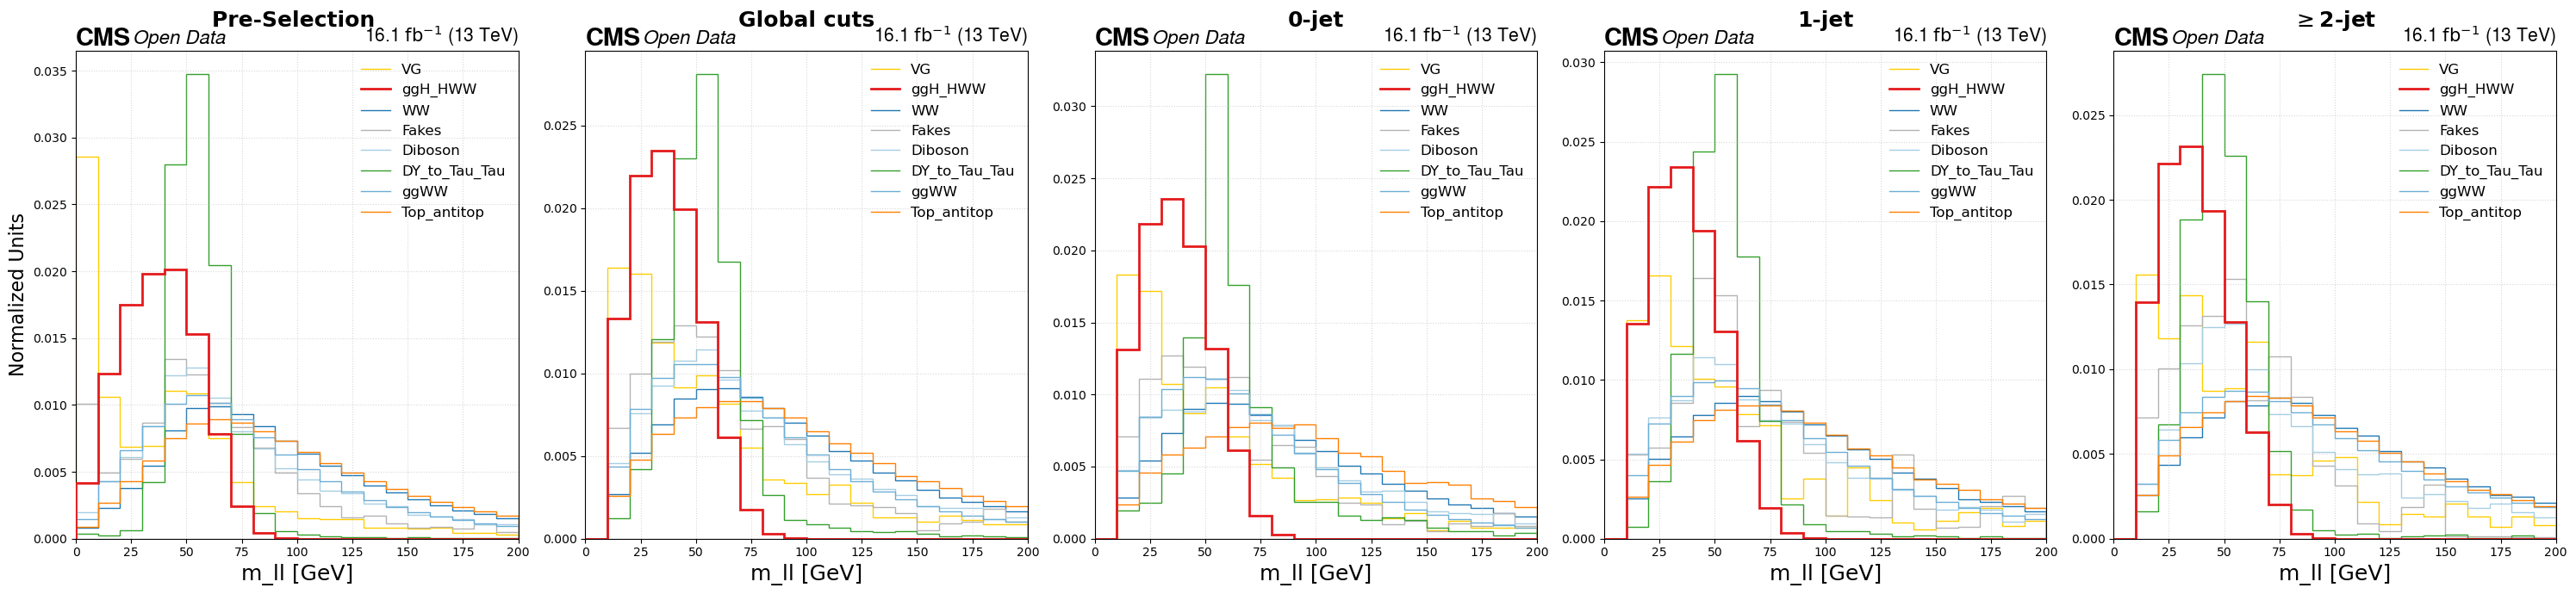

Processing met...
Saved plot: met_stages.png


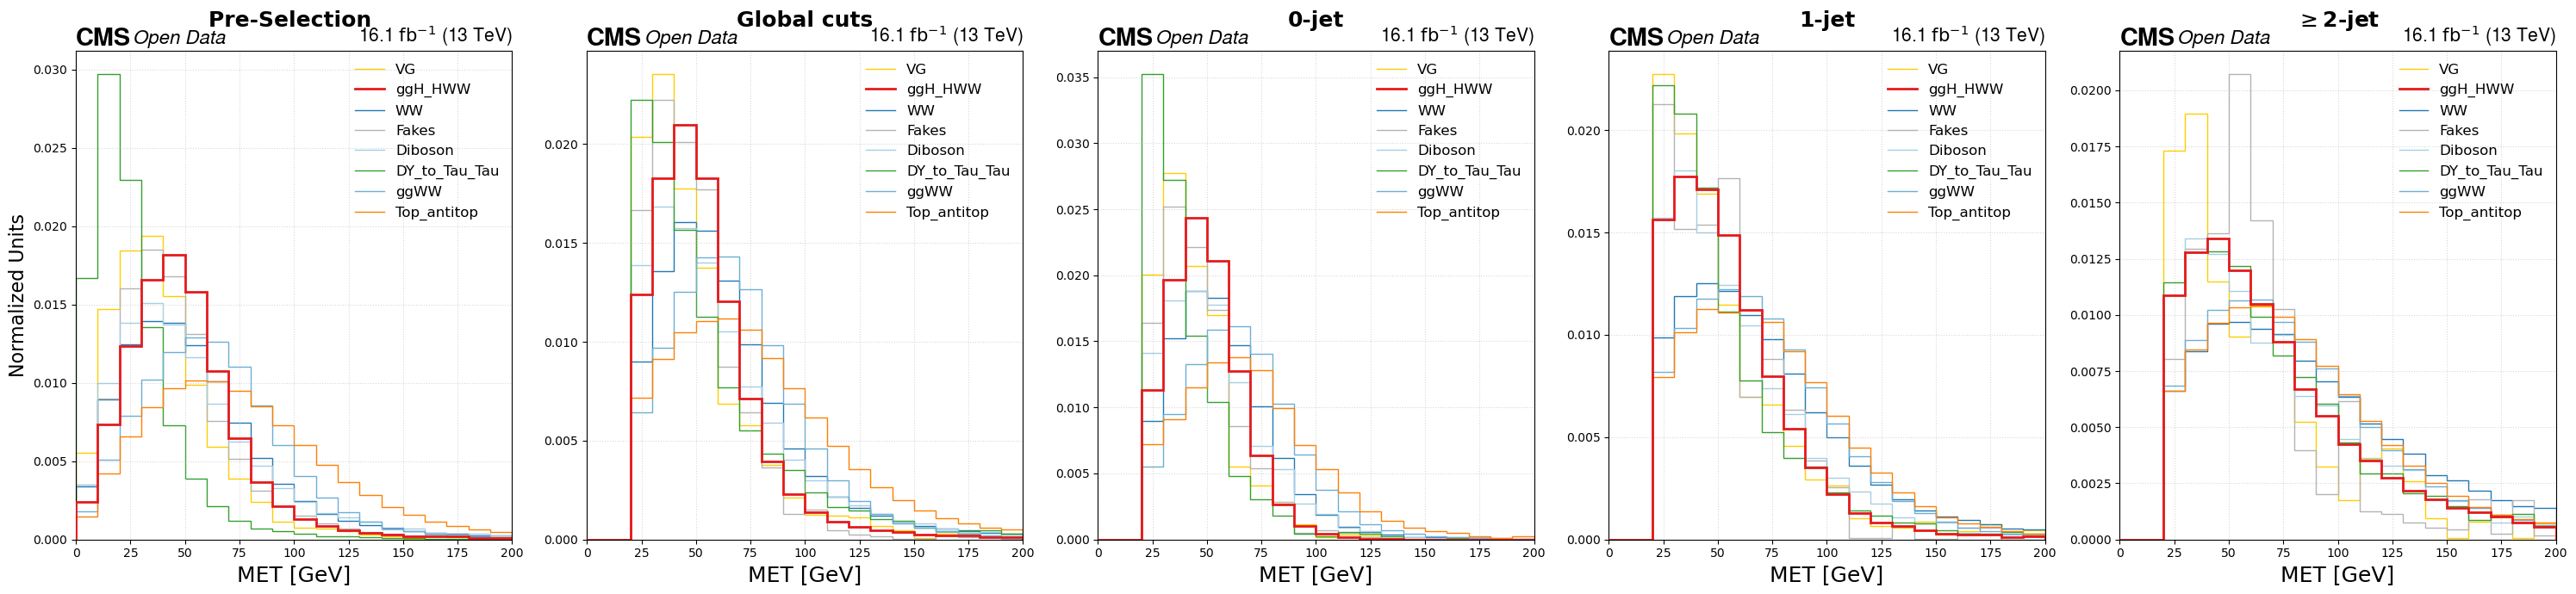

Processing dphi...
Saved plot: dphi_stages.png


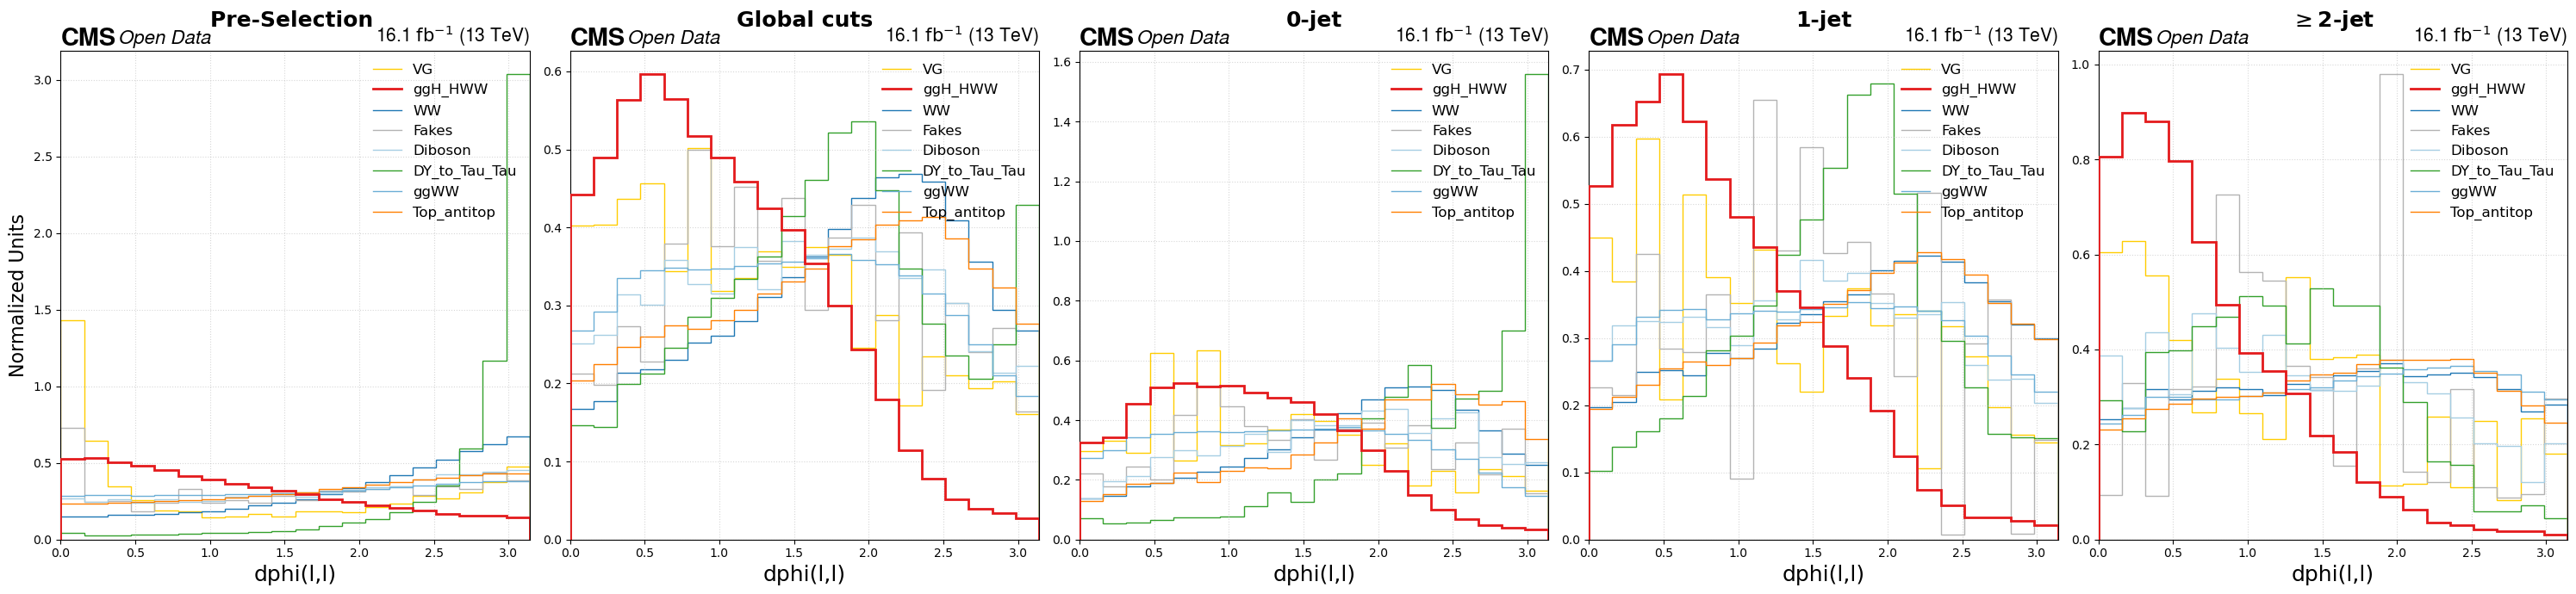

Processing ptll...
Saved plot: ptll_stages.png


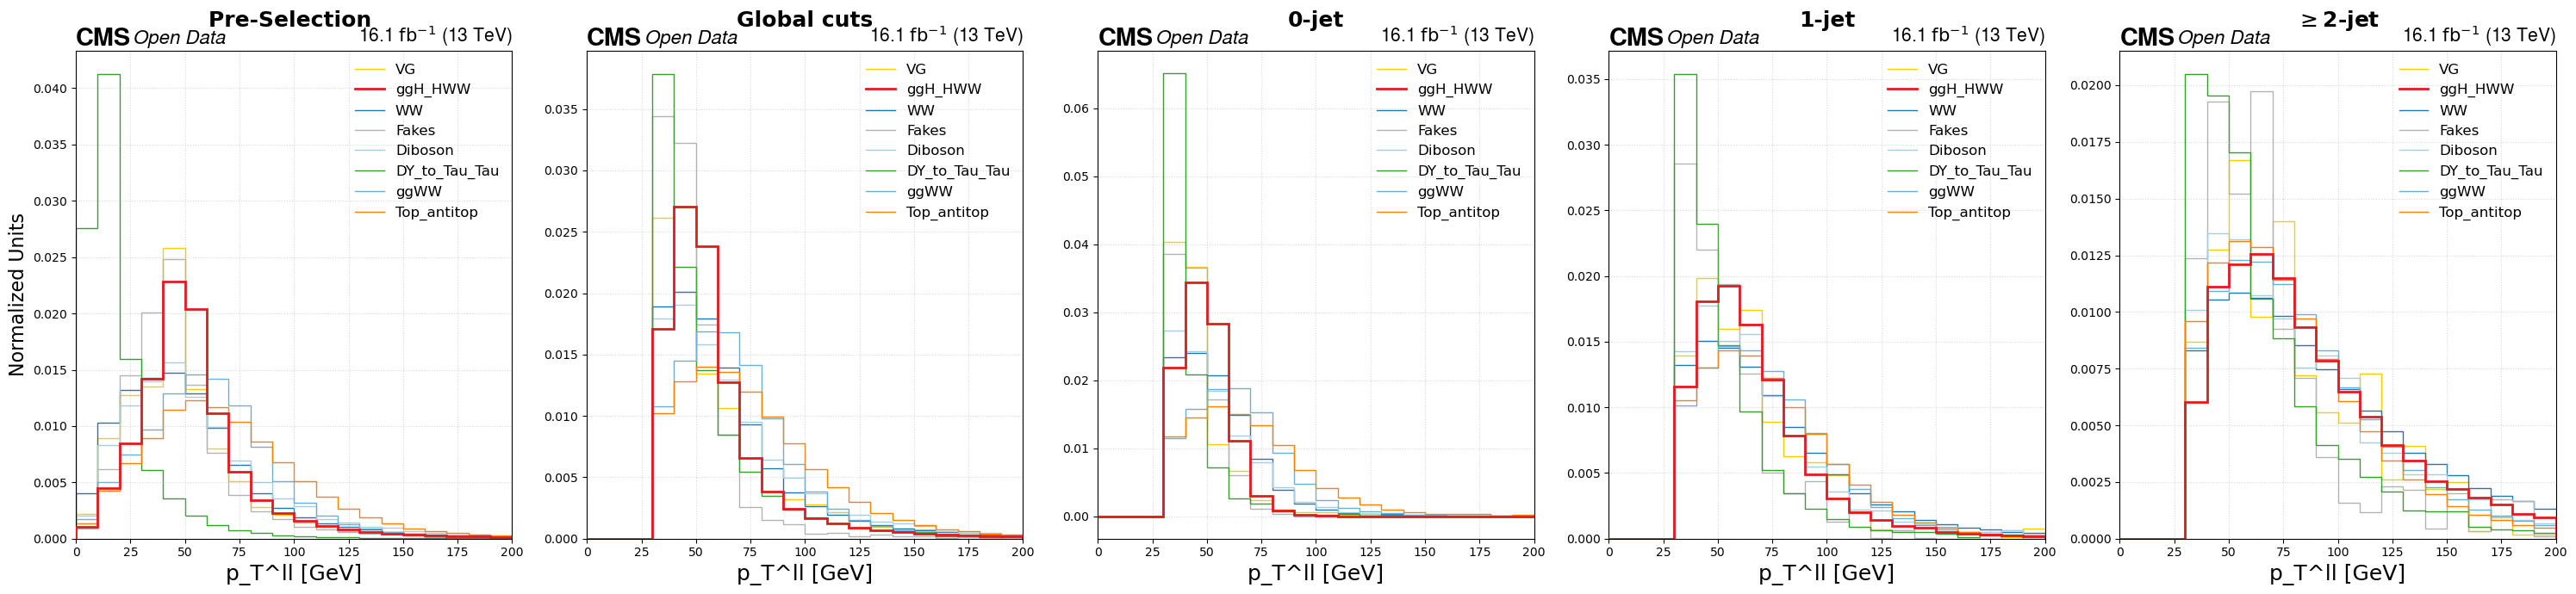

Processing mt_higgs...
Saved plot: mt_higgs_stages.png


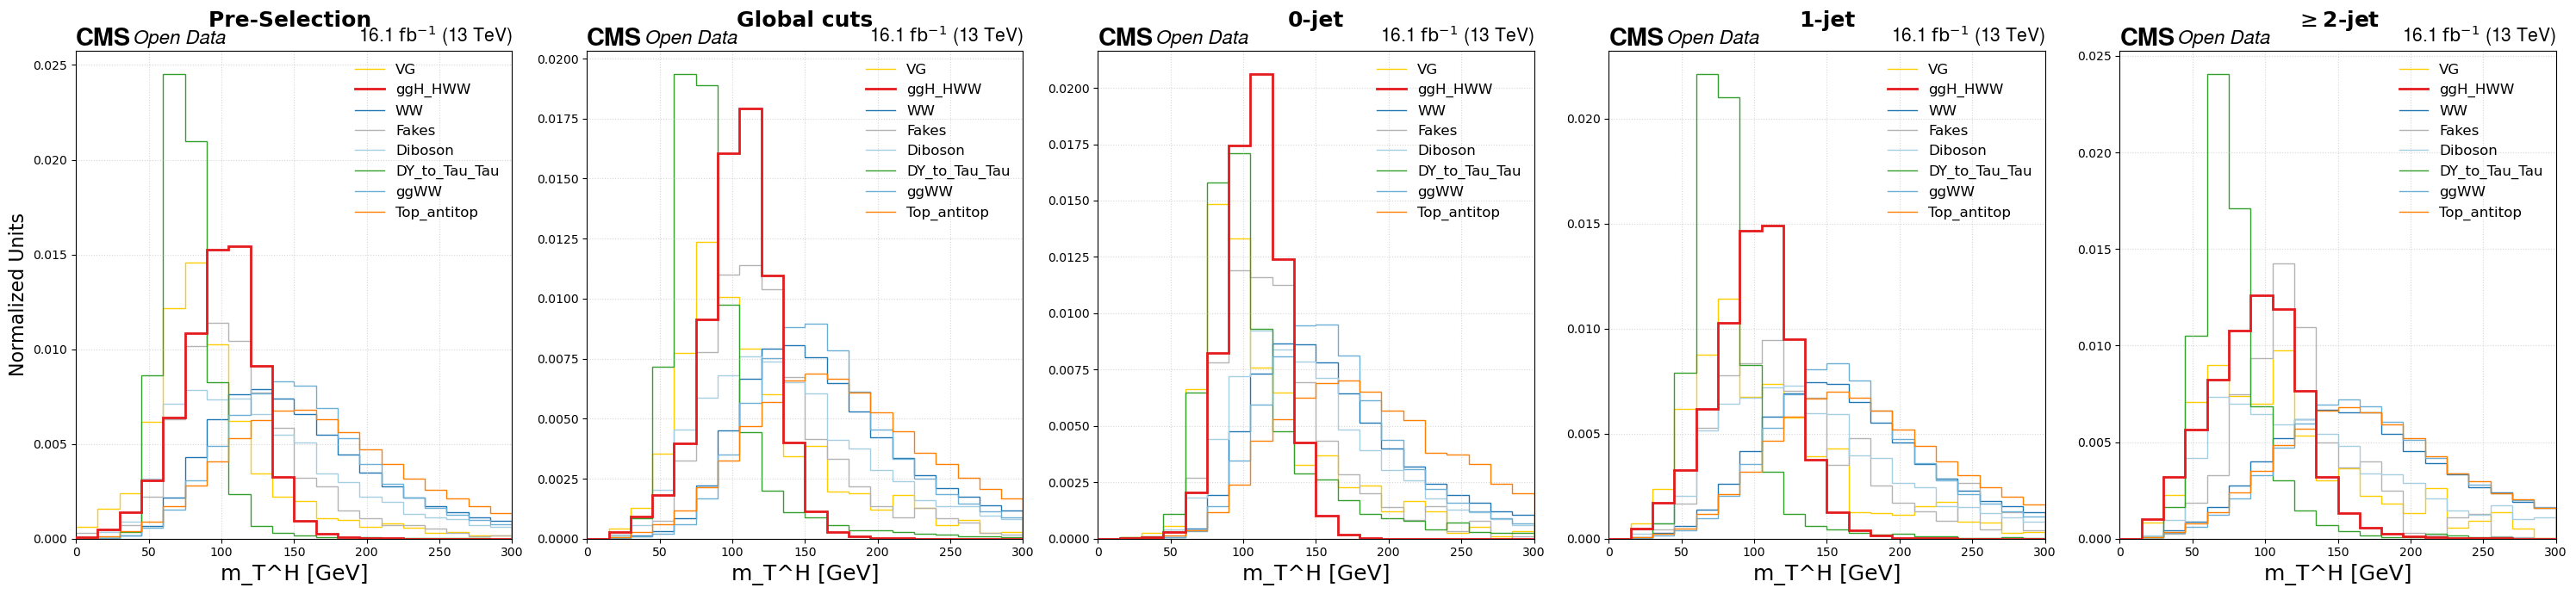

Processing mt_l2_met...
Saved plot: mt_l2_met_stages.png


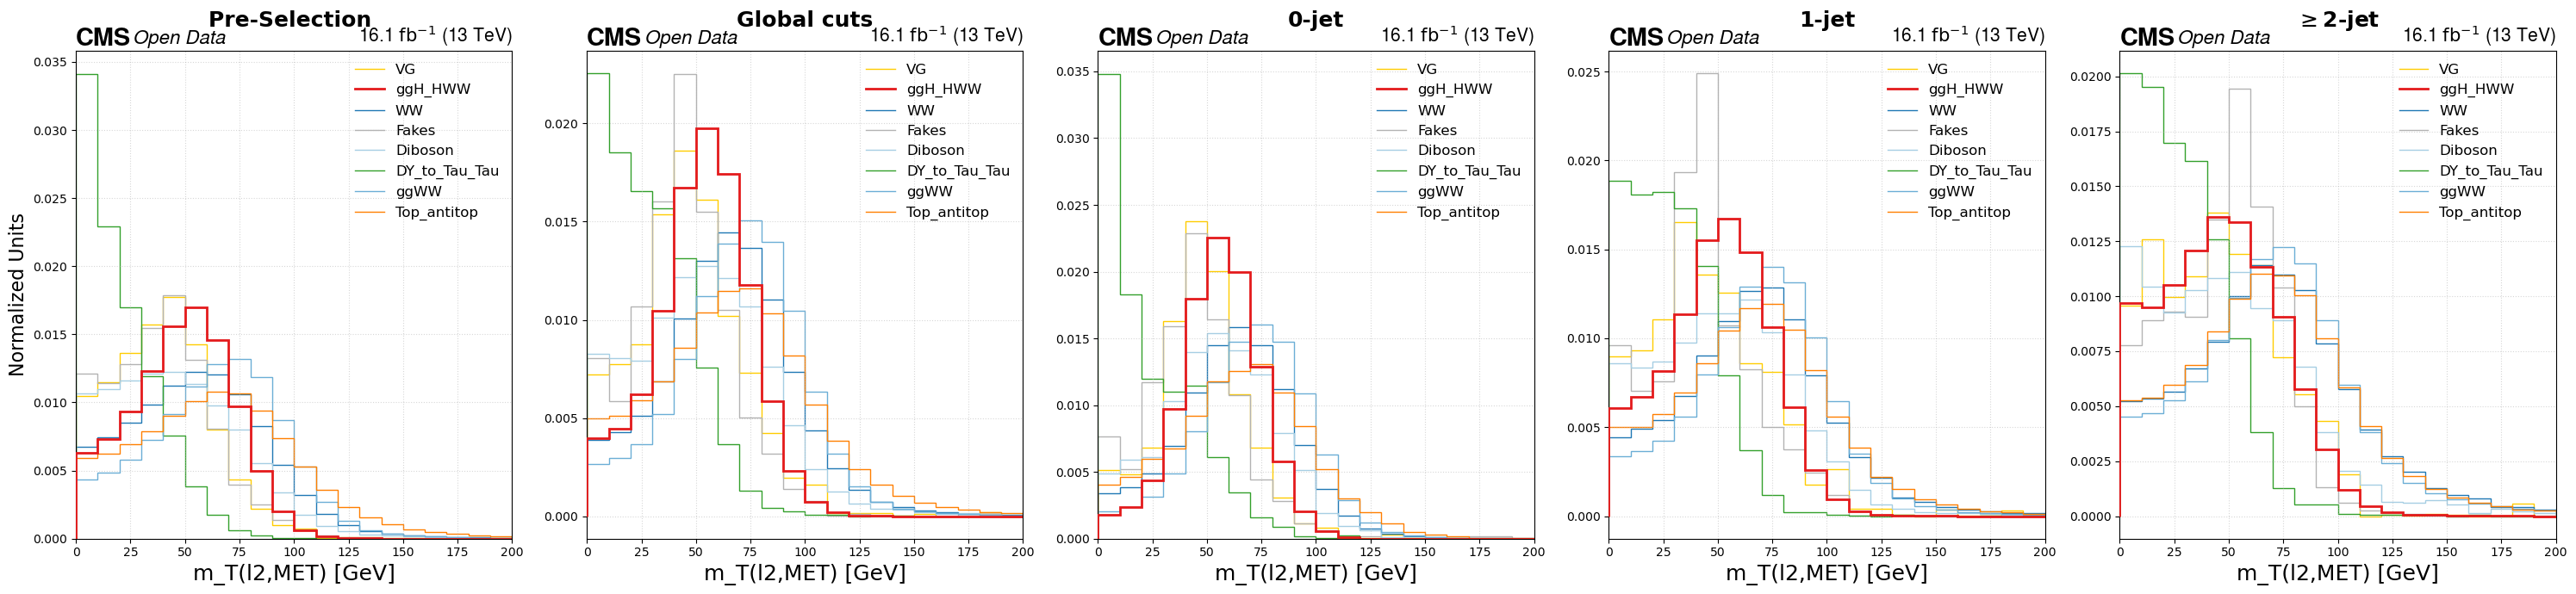

Processing mjj...
Saved plot: mjj_stages.png


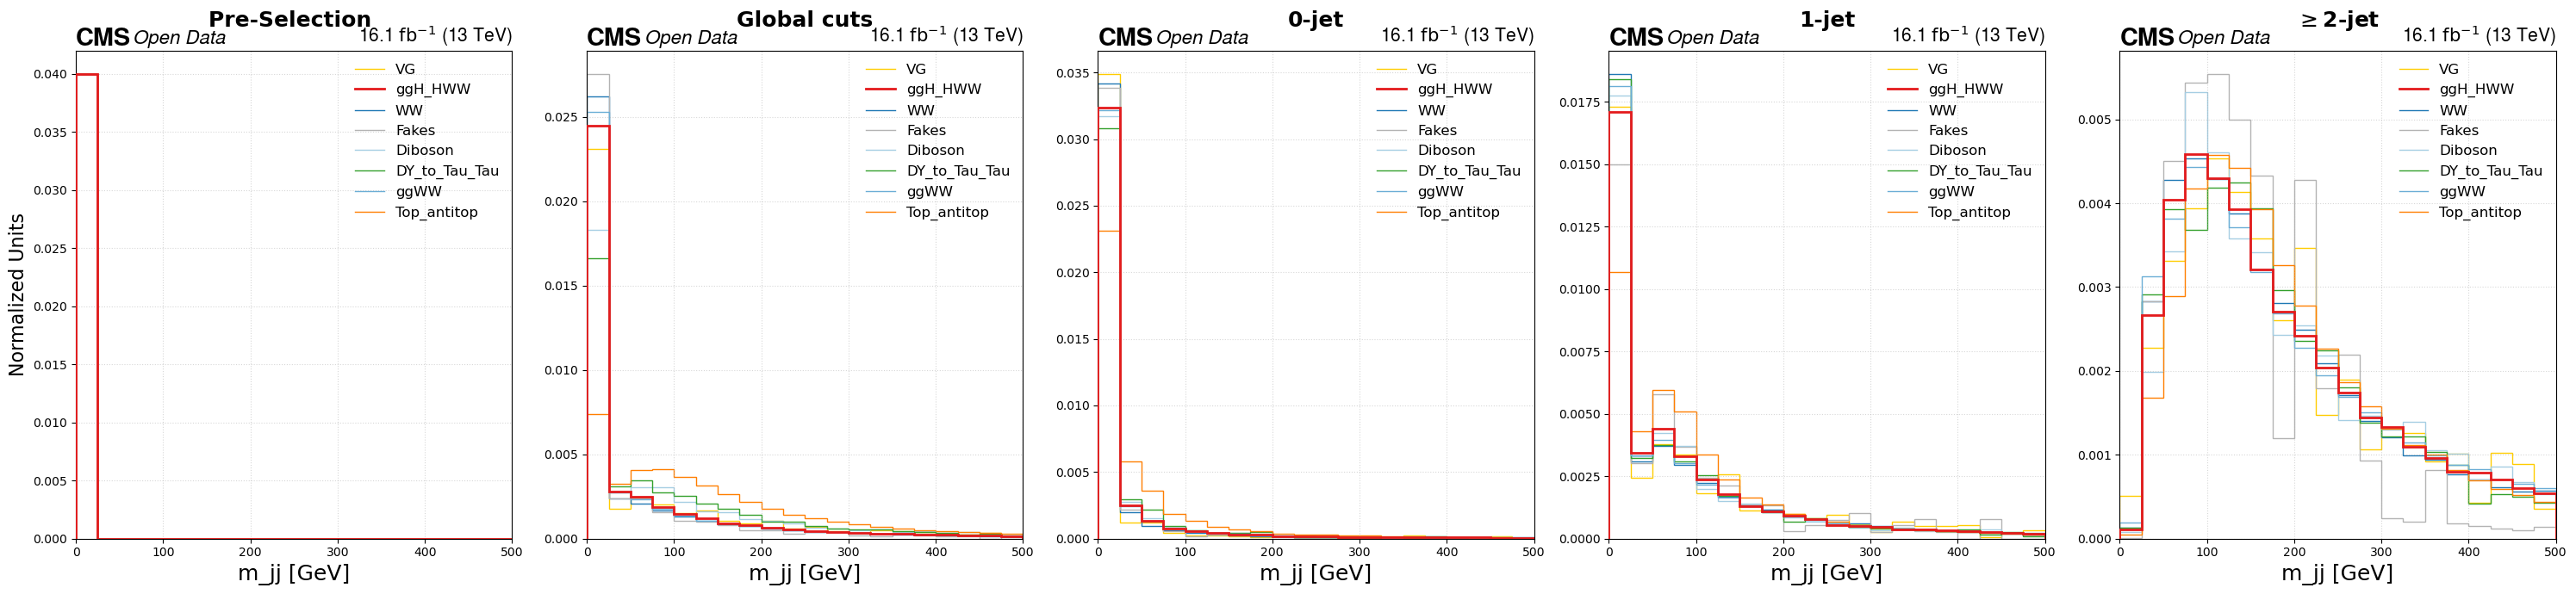

Processing leading_pt...
Saved plot: leading_pt_stages.png


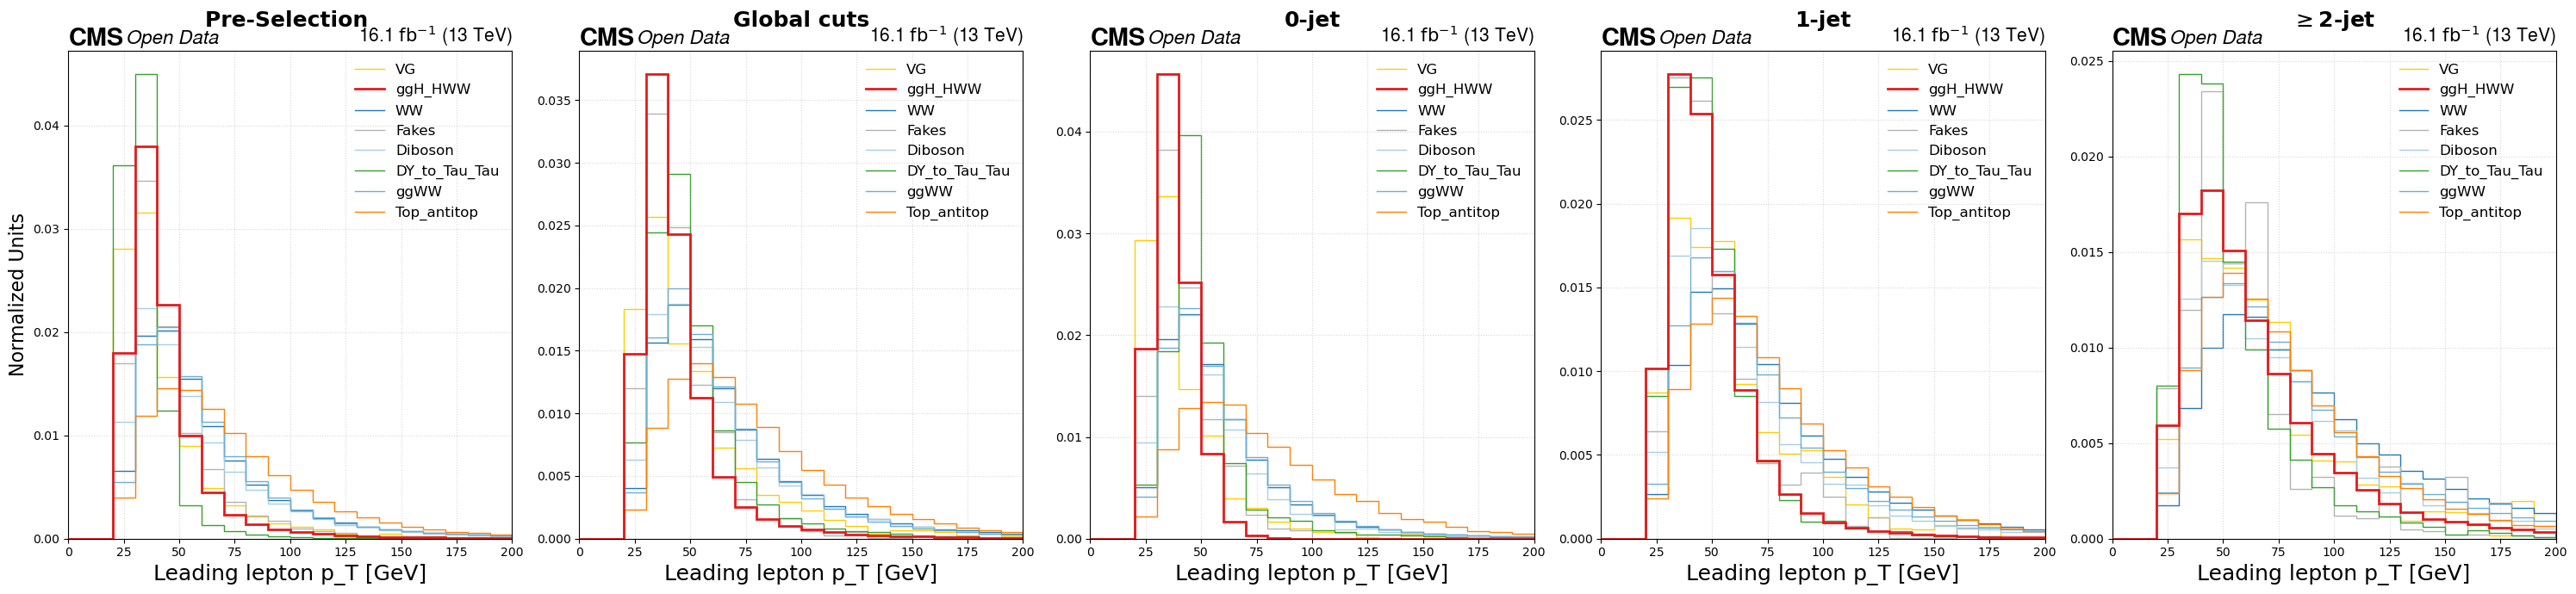

Processing subleading_pt...
Saved plot: subleading_pt_stages.png


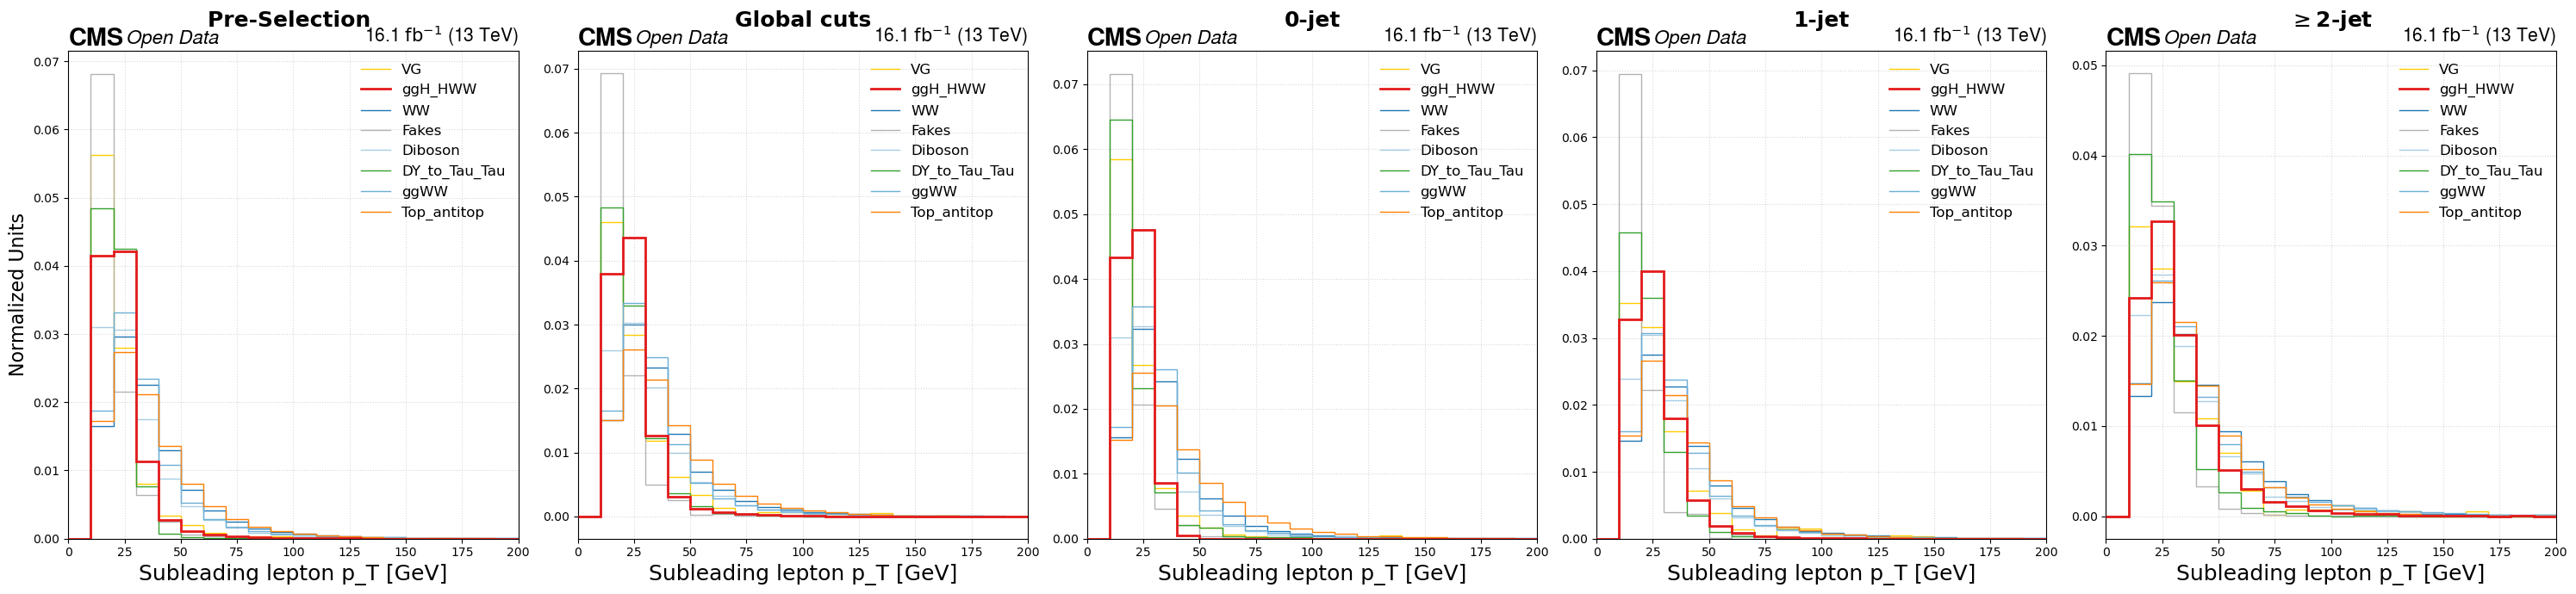

In [32]:
print(f"Saving plots to: {PLOTS_DIR / "Kinematics"}")
for var_name, var_props in variables_to_plots.items():
    print(f"Processing {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, hist_data_final, output_dir=PLOTS_DIR / "Kinematics")
    
    plt.show()
    
    plt.close(fig)

## Stacked plots

### Plot Settings

In [33]:
PLOT_SETTINGS = {
    # GROUP 1: SIGNAL REGION 
    "Signal_Region": {
        "plot_data": False, 
        "stages": [('SR_0jet', 'SR 0j'), ('SR_1jet', 'SR 1j'), ('SR_2jet', 'SR 2j')],
        "variables": {
            "mass":          {"log": True,  "xlim": (12, 200),  "ylim": (0.01, 5000)},
            "ptll":          {"log": True,  "xlim": (30, 200),  "ylim": (0.01, 5000)},
            "met":           {"log": True,  "xlim": (20, 200),  "ylim": (0.01, 5000)},
            "mt_higgs":      {"log": True,  "xlim": (60, 300),  "ylim": None},
            "mt_l2_met":     {"log": True,  "xlim": (30, 140),  "ylim": None},
            "mjj":           {"log": True,  "xlim": (0, 500),   "ylim": None}, 
            "dphi":          {"log": True,  "xlim": (0, 3.14),  "ylim": (0.01, 1000)},
            "leading_pt":    {"log": True,  "xlim": (25, 200),  "ylim": None},
            "subleading_pt": {"log": True,  "xlim": (10, 200),  "ylim": None},
        }
    },

    # GROUP 2: TOP CONTROL REGION 
    "Control_Region_Top": {
        "plot_data": True,
        "stages": [('CR_top_0jet', 'Top 0j'), ('CR_top_1jet', 'Top 1j'), ('CR_top_2jet', 'Top 2j')],
        "variables": {
            "mass":          {"log": True, "xlim": (50, 200),  "ylim": (1, 5000)},
            "ptll":          {"log": True, "xlim": (30, 200),  "ylim": (1, 2000)},
            "met":           {"log": True, "xlim": (20, 200),  "ylim": None},
            "mt_higgs":      {"log": True, "xlim": (60, 300),  "ylim": (1, 5000)},
            "mt_l2_met":     {"log": True, "xlim": (30, 150),  "ylim": None},
            "mjj":           {"log": True, "xlim": (0, 500),   "ylim": None},
            "dphi":          {"log": True, "xlim": (0, 3.14),  "ylim": (1, 1000)},
            "leading_pt":    {"log": True, "xlim": (25, 200),  "ylim": None},
            "subleading_pt": {"log": True, "xlim": (10, 200),  "ylim": None},
        }
    },

    # GROUP 3: TAU CONTROL REGION 
    "Control_Region_Tau": {
        "plot_data": True,
        "stages": [('CR_tau_0jet', r'DY-$\tau\tau$ 0j'), ('CR_tau_1jet', r'DY-$\tau\tau$ 1j'), ('CR_tau_2jet', r'DY-$\tau\tau$ 2j')],
        "variables": {
            "mass":          {"log": True, "xlim": (40, 60),   "ylim": (0.01, 1000)},
            "ptll":          {"log": True, "xlim": (30, 100),  "ylim": (0.01, 1000)},
            "met":           {"log": True, "xlim": (20, 100),   "ylim": (0.01, 1000)},
            "mt_higgs":      {"log": True, "xlim": (0, 60),    "ylim": (0.01, 1000)},
            "mt_l2_met":     {"log": True, "xlim": (30, 50),   "ylim": (0.01, 1000)},
            "mjj":           {"log": True, "xlim": (0, 500),   "ylim": None},
            "dphi":          {"log": True, "xlim": (1.5, 3.14),  "ylim": (0.01, 1000)},
            "leading_pt":    {"log": True, "xlim": (30, 80),  "ylim": (0.01, 1000)},
            "subleading_pt": {"log": True, "xlim": (10, 30),   "ylim": None},
        }
    }
}


## Helper Function

In [34]:
def get_histogram_data(hist_data, sample, stage, variable, variation='nominal'):
    """
    Safely extract (values, variances, edges) from the nested dictionary structure.
    """
    if sample not in hist_data: return None, None, None
    if stage not in hist_data[sample]: return None, None, None
    if variable not in hist_data[sample][stage]: return None, None, None
    
    vars_dict = hist_data[sample][stage][variable]
    if variation not in vars_dict: return None, None, None
        
    h = vars_dict[variation]
    
    try:
        # h.values() gives counts
        # h.variances() gives sum(weight^2) -> Stat Error^2
        # h.axes[0].edges gives bin edges
        return h.values(), h.variances(), h.axes[0].edges
    except:
        return None, None, None

## Plotting

In [35]:
def stacked_plots(variable, hist_data_all, output_dir="plots"):
    os.makedirs(output_dir, exist_ok=True)
    xlabel = VAR_LABELS.get(variable, variable)
    
    backgrounds = [s for s in SAMPLES if not SAMPLES[s]['is_signal'] and s != 'Data']
    backgrounds.sort(key=lambda s: SAMPLES[s].get("stack_order", 0))
    signal = next((s for s in SAMPLES if SAMPLES[s]['is_signal']), None)
    data_sample = 'Data'

    # SYSTEMATIC SOURCES TO CHECK
    # Base names of your variations (without _up/_down)
    syst_sources = ['trigger', 'ele_id', 'mu_id'] 

    for region_name, config in PLOT_SETTINGS.items():
        var_config = config['variables'].get(variable)
        if not var_config: continue

        print(f"Plotting {variable} in {region_name}...")
        
        stages = config['stages']
        use_log = var_config.get('log', False)
        set_xlim = var_config.get('xlim', None)
        set_ylim = var_config.get('ylim', None)
        
        is_signal_region = "Signal" in region_name
        plot_data = False if is_signal_region else config.get('plot_data', True)

        # CANVAS SETUP
        if plot_data:
            fig, axes = plt.subplots(2, 3, figsize=(30, 12), 
                                     gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.08, 'wspace': 0.25},
                                     sharex='col')
            row_axes = axes[0]
            ratio_axes = axes[1]
        else:
            fig, axes = plt.subplots(1, 3, figsize=(30, 9), 
                                     gridspec_kw={'wspace': 0.25},
                                     sharex='col')
            row_axes = axes
            ratio_axes = [None] * 3

        for col_idx, (stage_key, stage_label) in enumerate(stages):
            ax_main = row_axes[col_idx]
            ax_ratio = ratio_axes[col_idx]
            
            # --- 1. GET NOMINAL DATA ---
            stack_vals = []
            stack_colors = []
            stack_labels = []
            stack_variances = [] # Stat error squared
            edges = None
            
            # Arrays to store Total Background sums for Systematics
            # We initialize them after we know the bin count (len(edges)-1)
            total_nominal = None
            syst_stacks = {source: {'up': None, 'down': None} for source in syst_sources}

            for s in backgrounds:
                vals, vars_sq, e = get_histogram_data(hist_data_all, s, stage_key, variable, 'nominal')
                
                if vals is not None:
                    if edges is None: 
                        edges = e
                        nbins = len(vals)
                        total_nominal = np.zeros(nbins)
                        for src in syst_sources:
                            syst_stacks[src]['up'] = np.zeros(nbins)
                            syst_stacks[src]['down'] = np.zeros(nbins)

                    stack_vals.append(vals)
                    stack_variances.append(vars_sq) # Add stat variance
                    stack_colors.append(SAMPLES[s].get("color", "gray"))
                    stack_labels.append(s)
                    
                    # Add to totals
                    total_nominal += vals
                    
                    # Accumulate Systematics for this background
                    for src in syst_sources:
                        # Get Up/Down for this sample and add to total stack
                        v_up, _, _ = get_histogram_data(hist_data_all, s, stage_key, variable, f'{src}_up')
                        v_dn, _, _ = get_histogram_data(hist_data_all, s, stage_key, variable, f'{src}_down')
                        
                        # Fallback to nominal if missing
                        if v_up is None: v_up = vals
                        if v_dn is None: v_dn = vals
                            
                        syst_stacks[src]['up'] += v_up
                        syst_stacks[src]['down'] += v_dn

            if edges is None:
                ax_main.text(0.5, 0.5, "No Data", ha='center', transform=ax_main.transAxes)
                continue
                
            # --- 2. CALCULATE TOTAL UNCERTAINTY ---
            # A. Statistical Uncertainty (Sum of variances)
            # Variance of Sum = Sum of Variances
            total_stat_variance = np.sum(stack_variances, axis=0)
            
            # B. Systematic Uncertainty
            total_syst_variance = np.zeros_like(total_nominal)
            
            for src in syst_sources:
                # Difference from nominal total
                diff_up = np.abs(syst_stacks[src]['up'] - total_nominal)
                diff_dn = np.abs(syst_stacks[src]['down'] - total_nominal)
                
                # Conservative: Max of up/down difference
                # Standard: (Up - Nom)^2 
                # Let's use max(up, down) per bin to be safe and symmetric
                max_diff = np.maximum(diff_up, diff_dn)
                total_syst_variance += max_diff**2
                
            # C. Total Error (Stat + Syst)
            total_err = np.sqrt(total_stat_variance + total_syst_variance)

            # --- 3. PLOTTING ---
            
            # A. Stack
            if stack_vals:
                hep.histplot(stack_vals, bins=edges, stack=True, histtype='fill',
                             color=stack_colors, label=stack_labels, ax=ax_main)
                
                # Outline
                hep.histplot(total_nominal, bins=edges, histtype='step', color='black', linewidth=1, ax=ax_main)
                
                # DRAW UNCERTAINTY BAND
                # We use step='post' to match histogram drawing
                # We construct the band arrays by appending the last bin value to match edges length
                band_low = np.append(total_nominal - total_err, (total_nominal - total_err)[-1])
                band_high = np.append(total_nominal + total_err, (total_nominal + total_err)[-1])
                
                ax_main.fill_between(edges, band_low, band_high, step='post', 
                                     facecolor='none', edgecolor='gray', 
                                     label='Stat+Syst Unc.', hatch='////', zorder=2)

            # B. Signal
            if signal:
                sig_vals, _, _ = get_histogram_data(hist_data_all, signal, stage_key, variable, 'nominal')
                if sig_vals is not None:
                    sig_scale = 10 if is_signal_region else 1
                    sig_lbl = f"{signal} (x{sig_scale})" if sig_scale > 1 else signal
                    hep.histplot(sig_vals * sig_scale, bins=edges, histtype='step',
                                 color=SAMPLES[signal].get("color", "red"), 
                                 linewidth=3, label=sig_lbl, ax=ax_main)

            # C. Data
            data_vals = None
            if plot_data:
                data_vals, _, _ = get_histogram_data(hist_data_all, data_sample, stage_key, variable, 'nominal')
                if data_vals is not None:
                    yerr = np.sqrt(data_vals); yerr[data_vals == 0] = 0
                    hep.histplot(data_vals, bins=edges, histtype='errorbar', color='black', 
                                 label='Data', yerr=yerr, marker='o', markersize=5, ax=ax_main, zorder=10)

            # D. Ratio Plot
            if plot_data and data_vals is not None and total_nominal is not None:
                safe_denom = np.where(total_nominal == 0, 1e-9, total_nominal)
                ratio = data_vals / safe_denom
                ratio_stat_err = np.abs(np.sqrt(data_vals) / safe_denom) # Data Stat Error only on points
                
                # Points
                hep.histplot(ratio, bins=edges, histtype='errorbar', yerr=ratio_stat_err,
                             color='black', marker='o', markersize=4, ax=ax_ratio)
                
                # Ratio Uncertainty Band (MC Stat+Syst / MC Nominal)
                # It is centered at 1.0
                rel_err = total_err / safe_denom
                # Prevent huge bands in empty bins
                rel_err[total_nominal == 0] = 0 
                
                ratio_band_low = np.append(1.0 - rel_err, (1.0 - rel_err)[-1])
                ratio_band_high = np.append(1.0 + rel_err, (1.0 + rel_err)[-1])
                
                ax_ratio.fill_between(edges, ratio_band_low, ratio_band_high, step='post',
                                      facecolor='gray', alpha=0.3, zorder=1) # Solid gray or hatched
                
                ax_ratio.axhline(1, color='gray', linestyle='--')
                ax_ratio.set_ylim(0.5, 1.5)
                ax_ratio.set_ylabel("Data / Pred.", fontsize=16)
                ax_ratio.set_xlabel(xlabel, fontsize=20)
                ax_ratio.grid(True, linestyle=':', alpha=0.5)

            # --- STYLING ---
            hep.cms.label(ax=ax_main, loc=0, data=True, label="Open Data", lumi=16.1, fontsize=20)
            ax_main.text(0.05, 0.92, stage_label, transform=ax_main.transAxes, fontsize=22, fontweight='bold', va='top')
            ax_main.set_ylabel("Events / Bin", fontsize=20)
            
            if use_log:
                ax_main.set_yscale('log')
                max_val = np.max(total_nominal) if total_nominal is not None else 1
                ax_main.set_ylim(0.1, max_val * 500)
            else:
                max_val = np.max(total_nominal) if total_nominal is not None else 1
                ax_main.set_ylim(0, max_val * 1.5)

            if set_xlim: ax_main.set_xlim(set_xlim)
            if set_ylim and not use_log: ax_main.set_ylim(set_ylim)
            if not plot_data: ax_main.set_xlabel(xlabel, fontsize=20)

            # Legend
            handles, labels = ax_main.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            # Reorder legend logic (Data first, then Signal, then Band, then Backgrounds)
            # ... (Your previous legend sorting logic here) ...
            ax_main.legend(by_label.values(), by_label.keys(), loc='upper right', ncol=1, frameon=False, fontsize=16)

        # SAVE
        fname = f"{output_dir}/CMS_{region_name}_{variable}.png"
        plt.savefig(fname, bbox_inches='tight', dpi=150)
        print(f"Saved: {fname}")
        plt.show()
        plt.close(fig)


GENERATING PLOTS WITH SYSTEMATIC BANDS...
Plotting mass in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mass.png


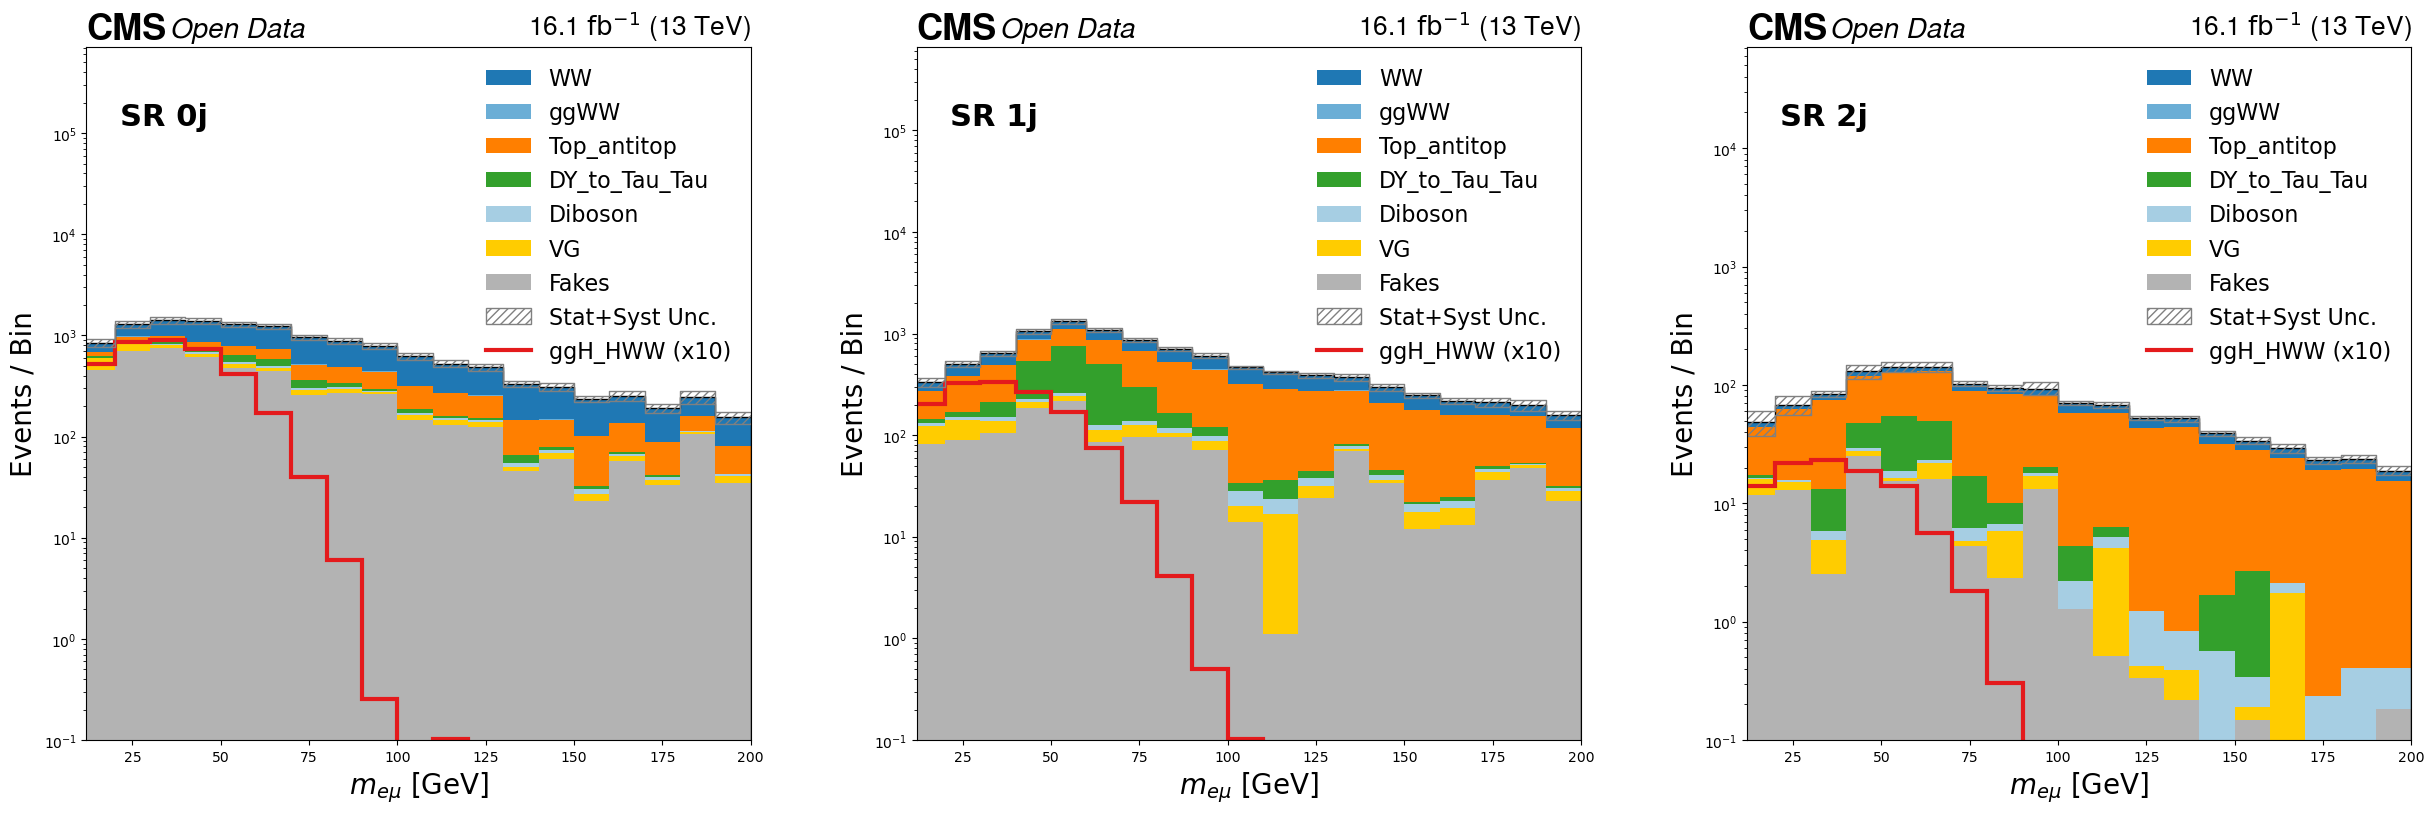

Plotting mass in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mass.png


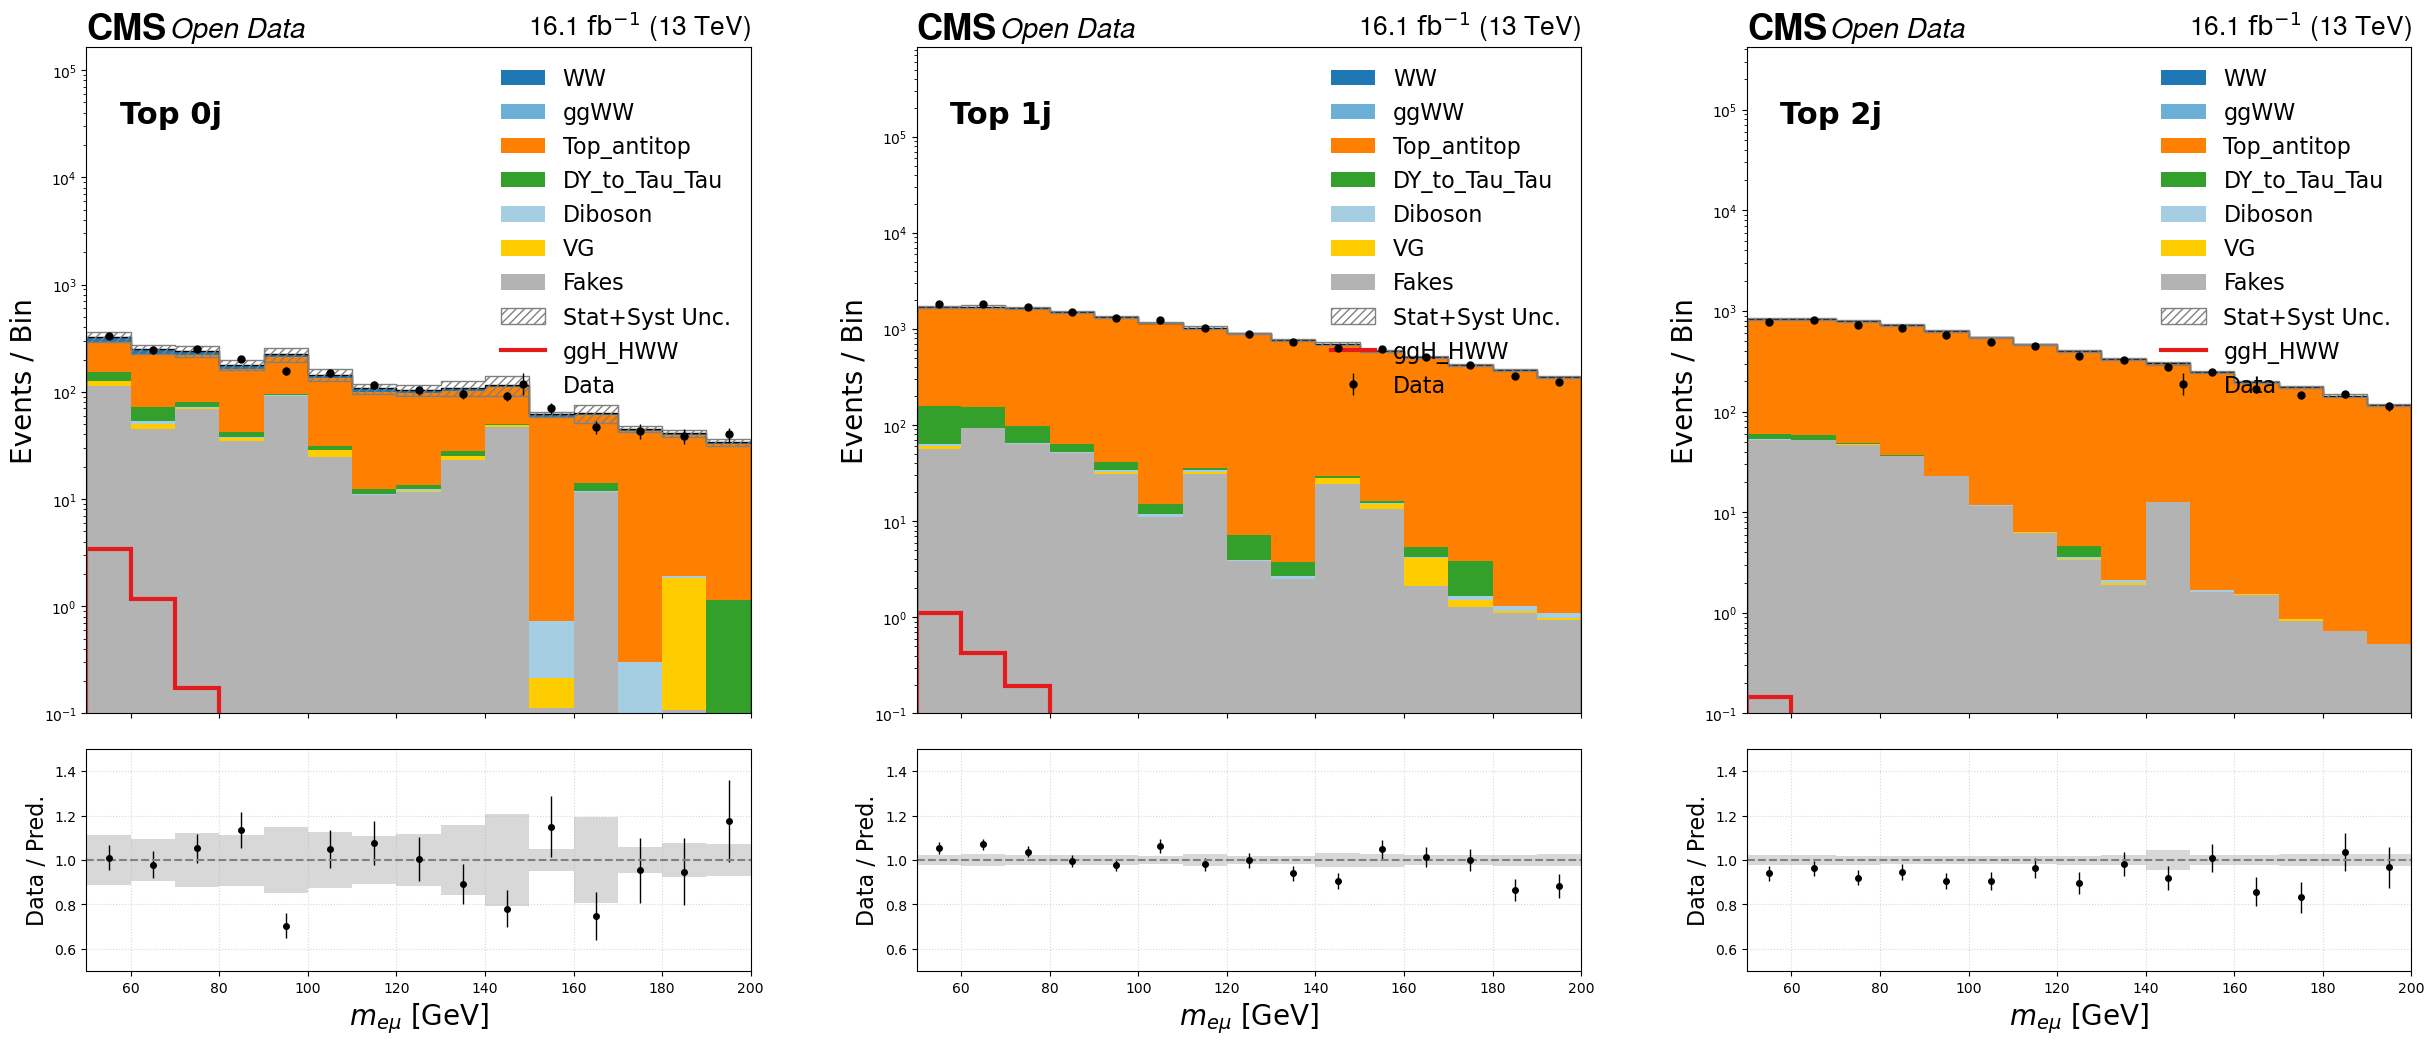

Plotting mass in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mass.png


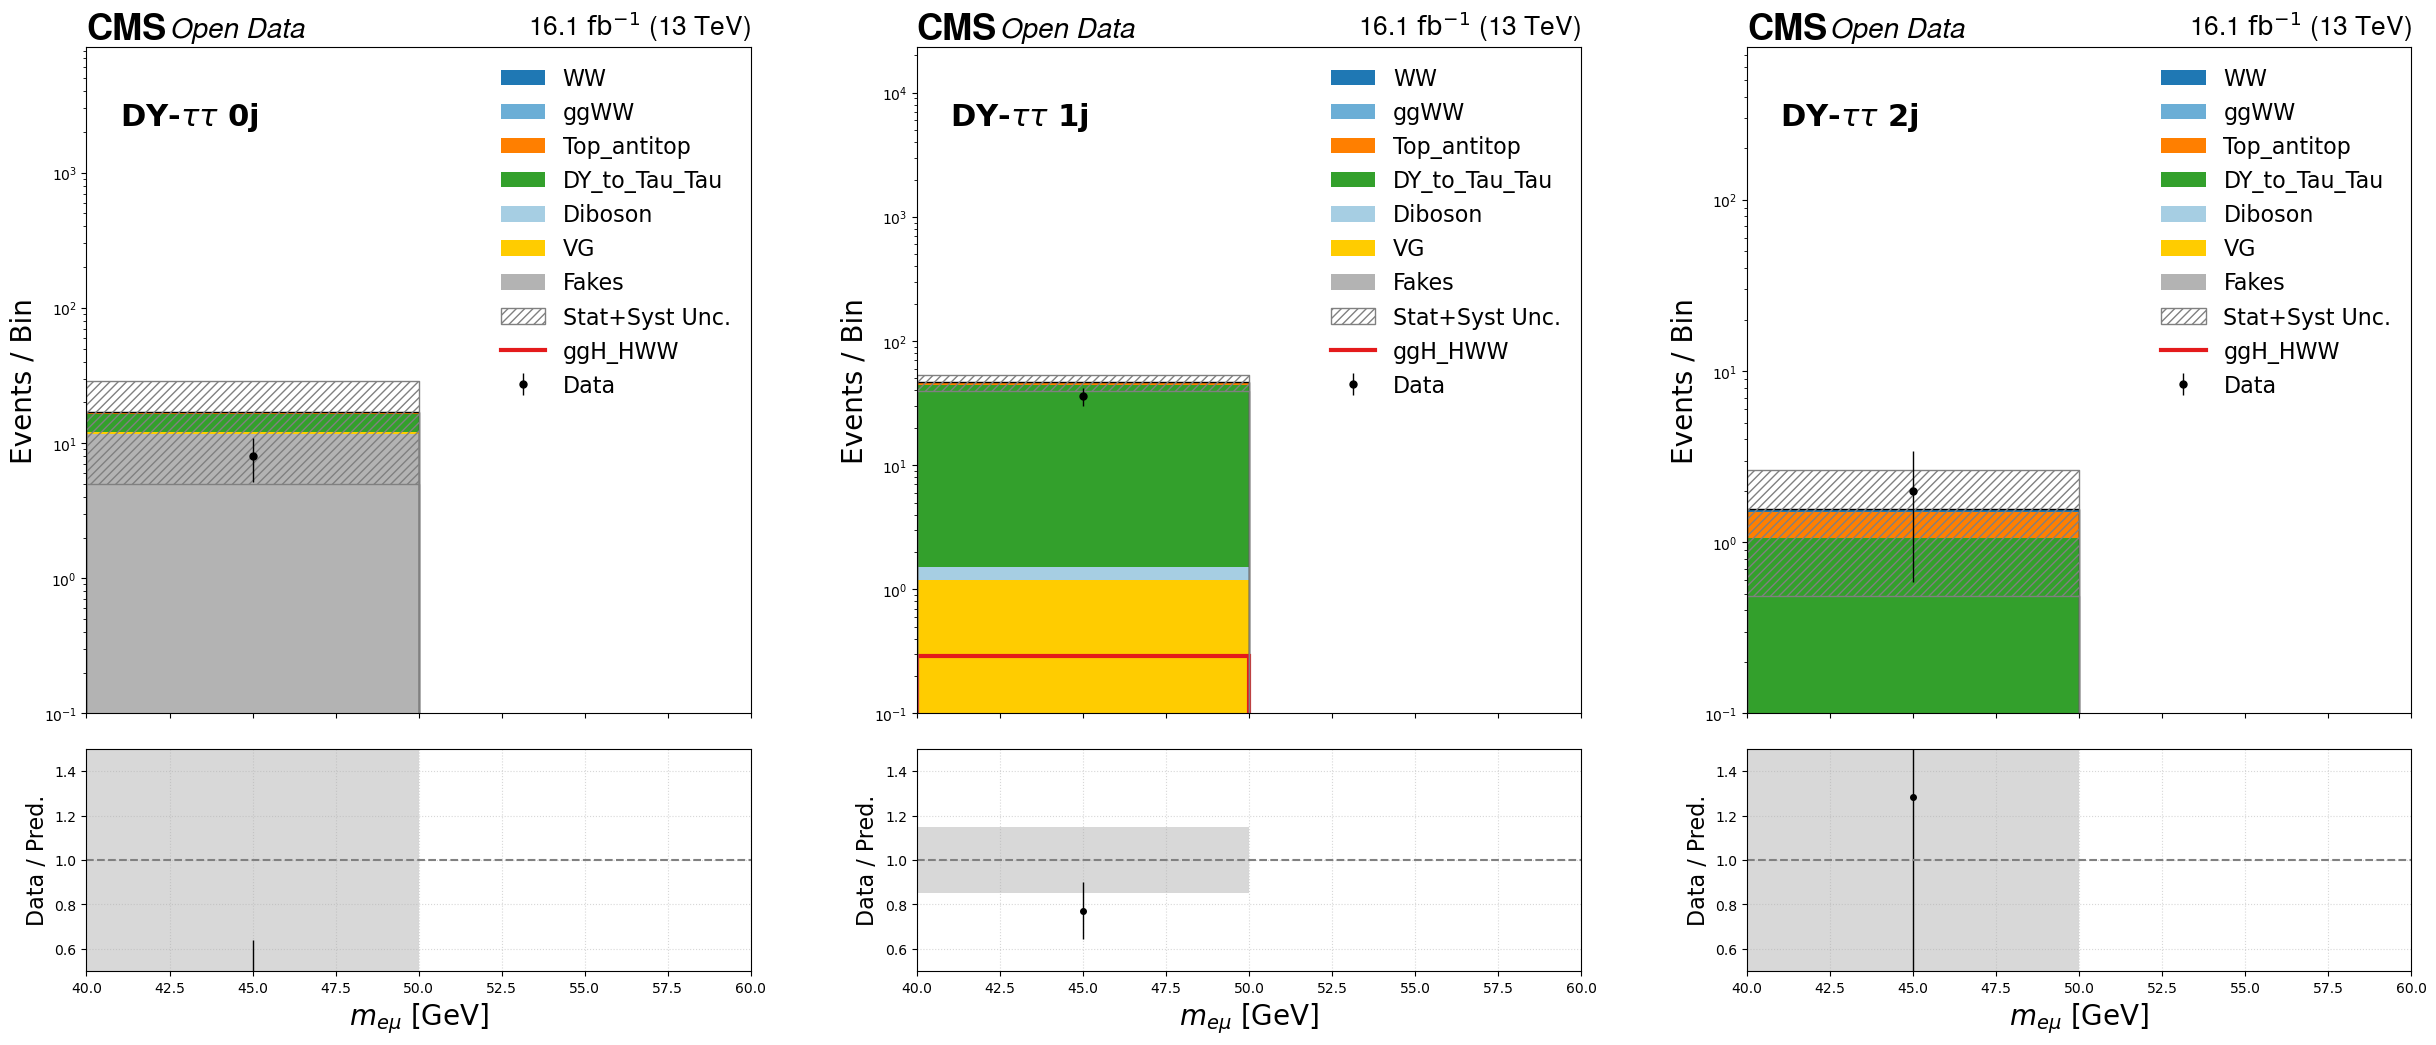

Plotting met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_met.png


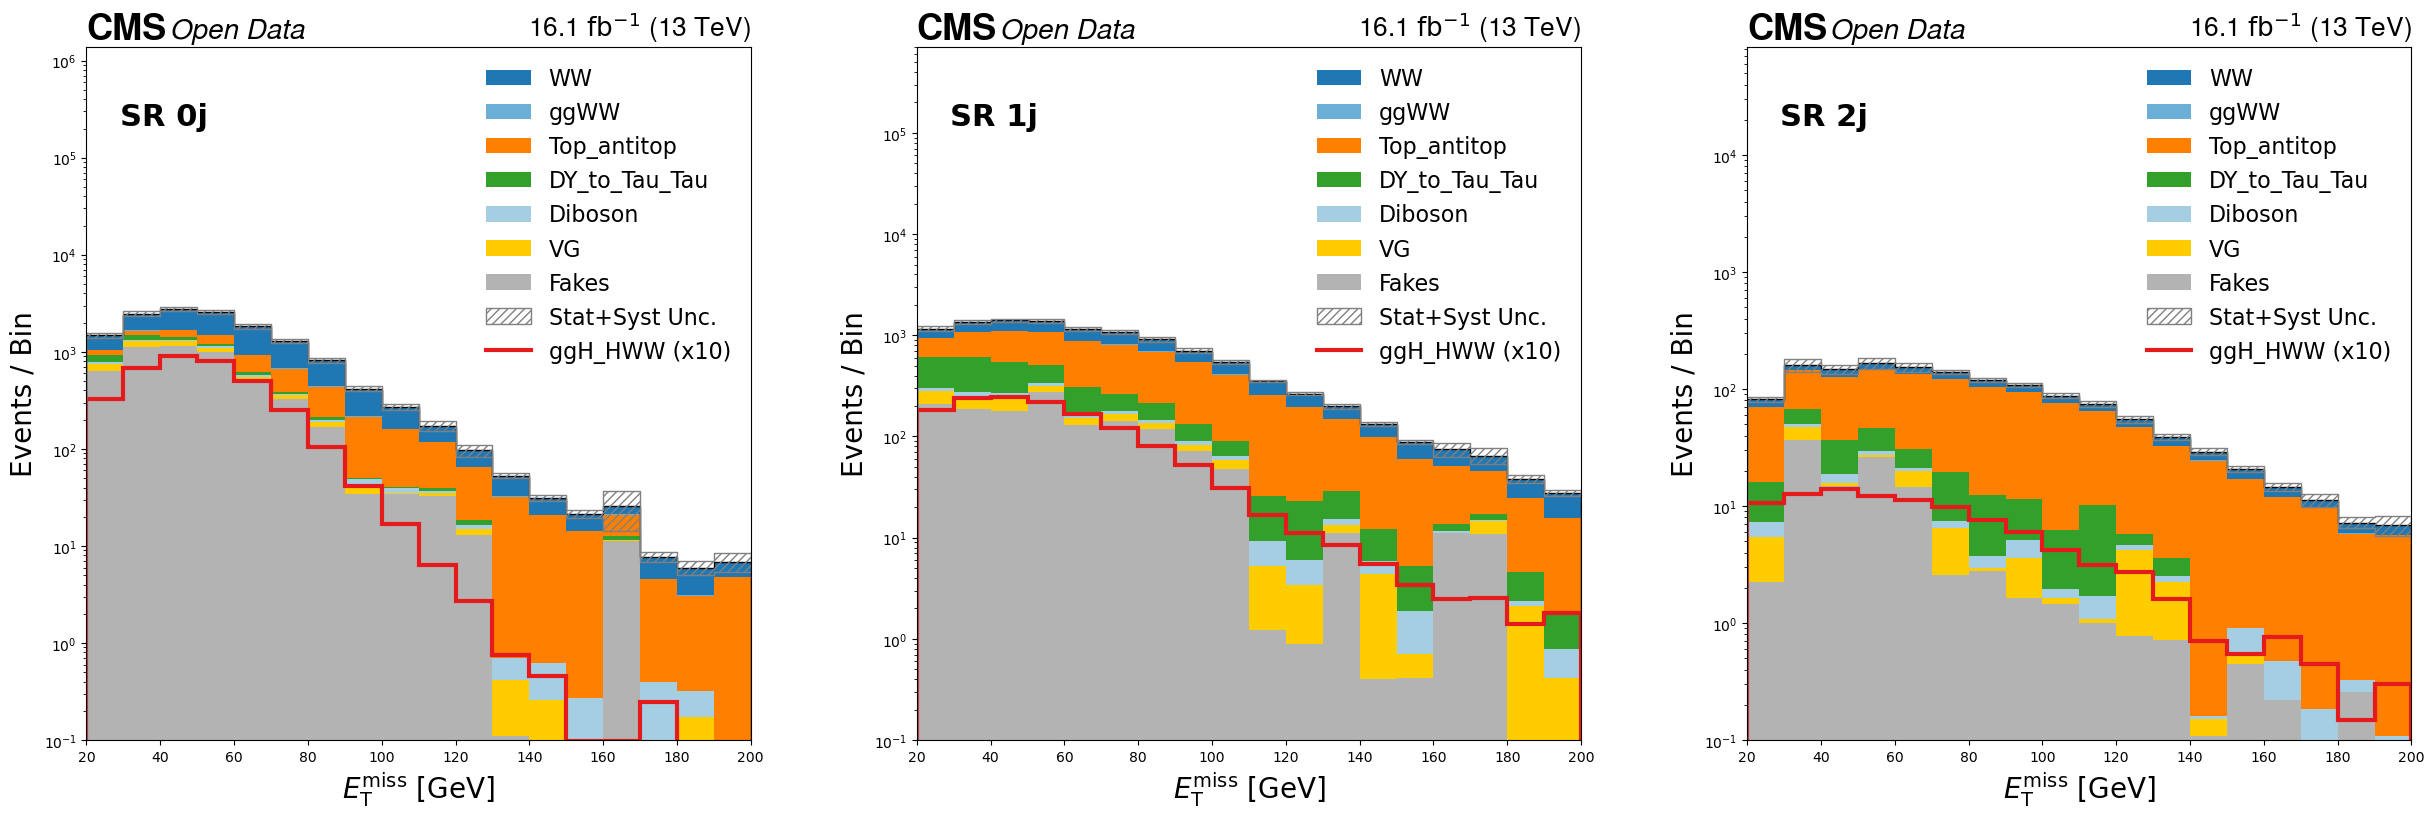

Plotting met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_met.png


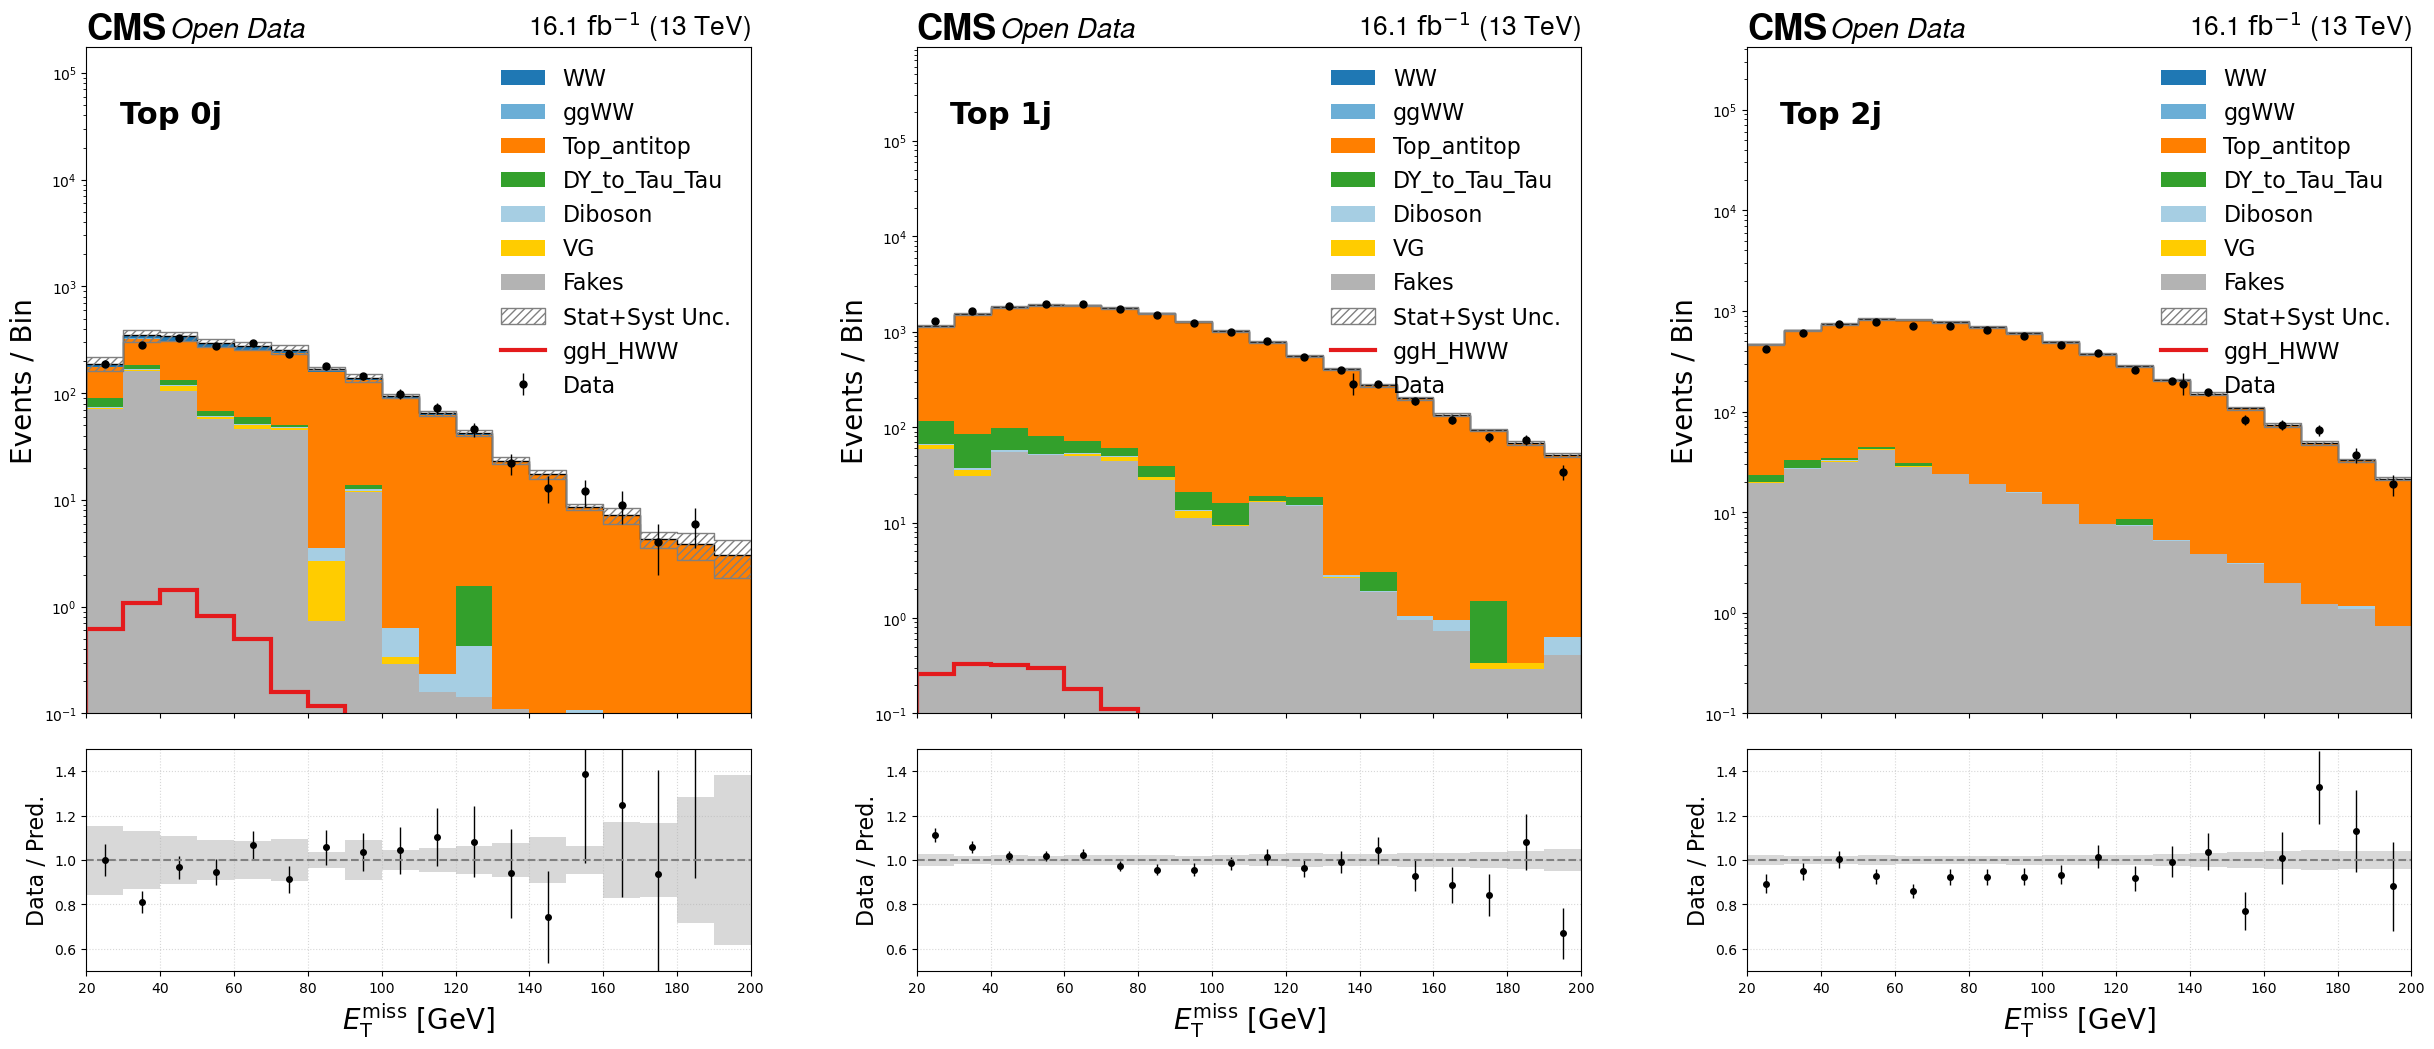

Plotting met in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_met.png


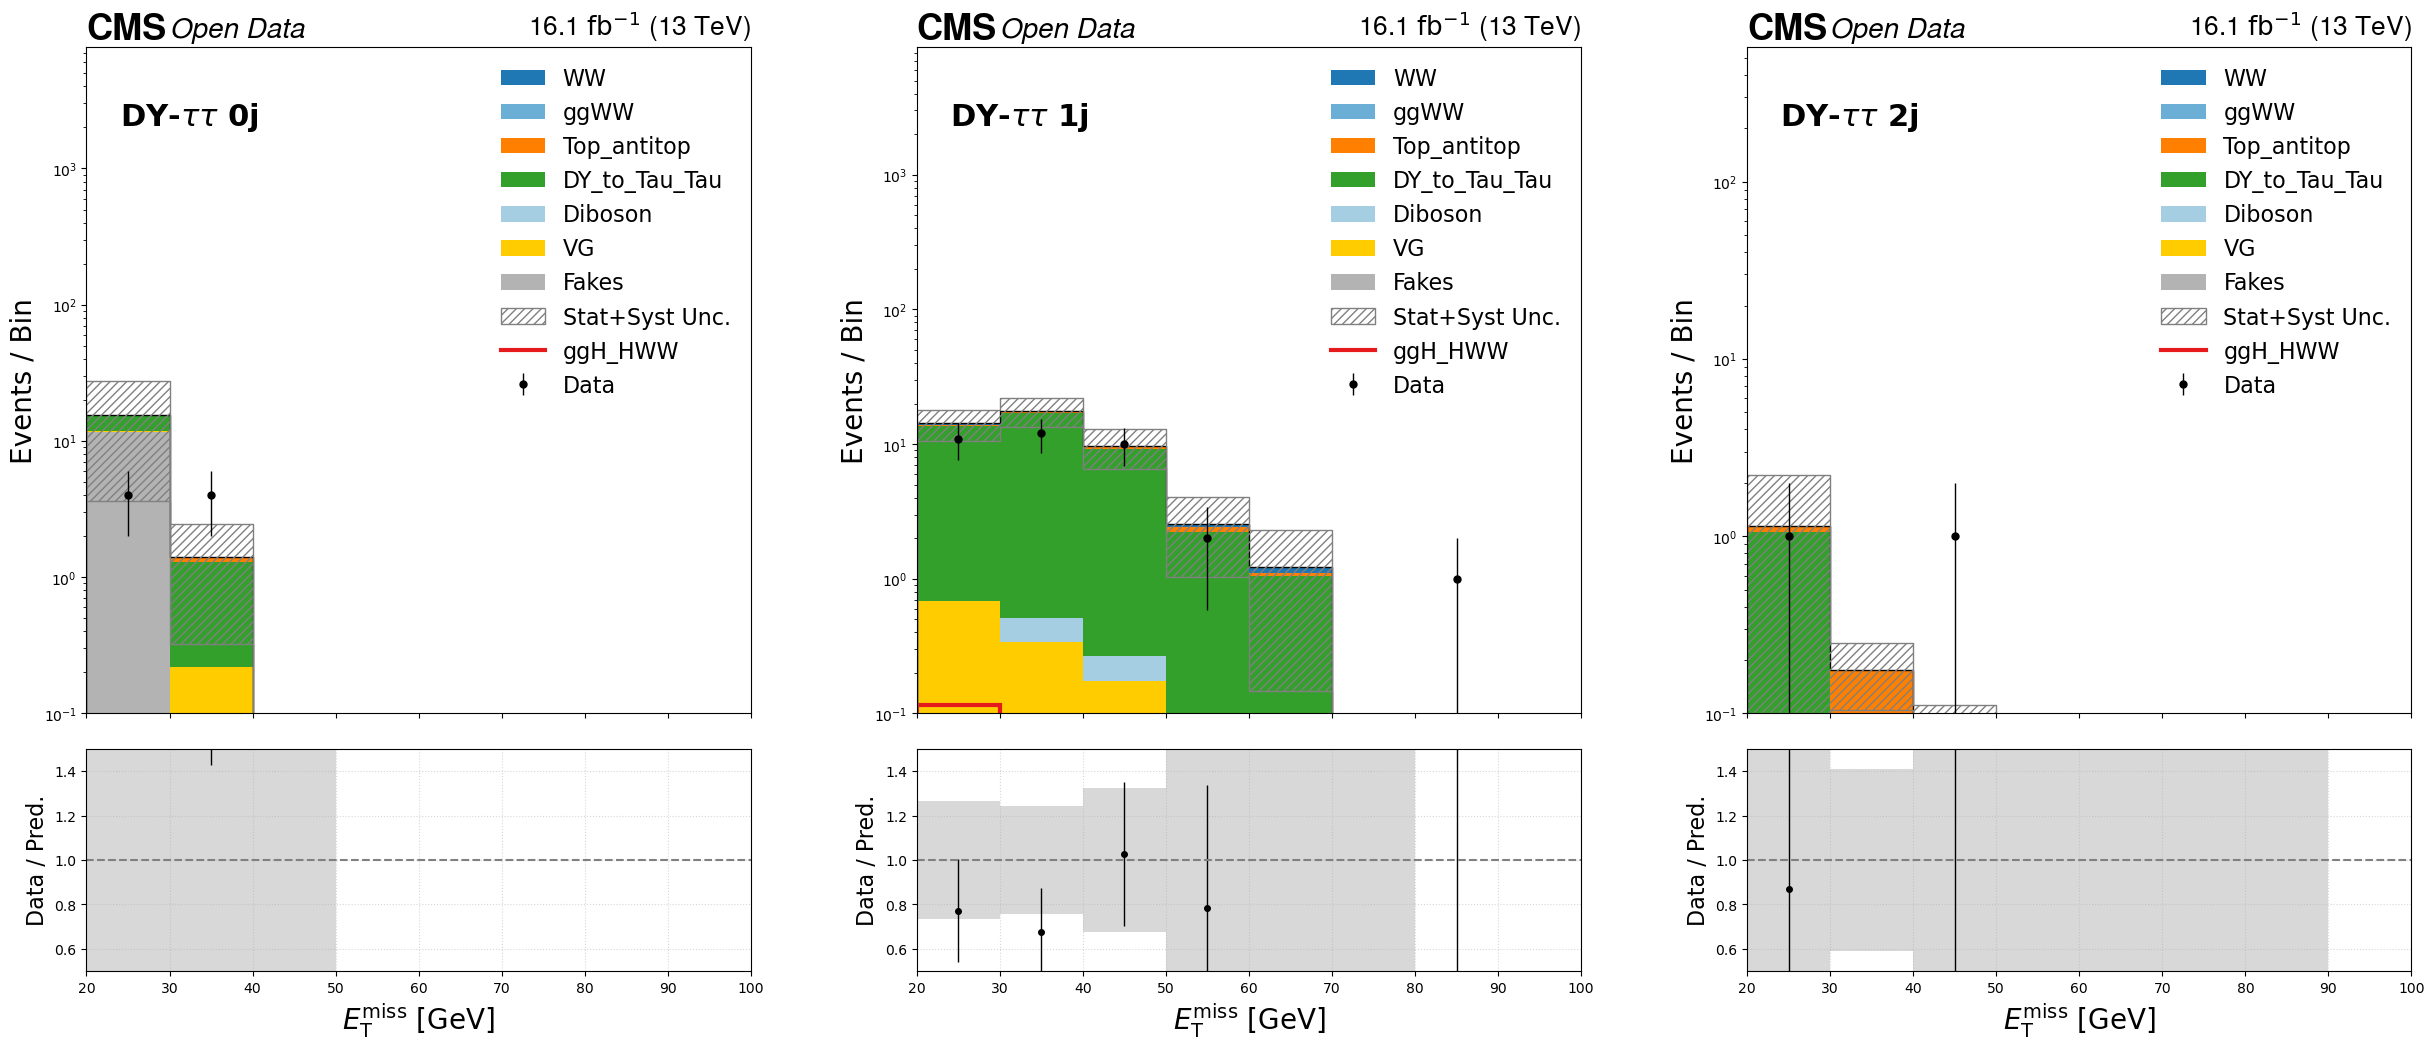

Plotting ptll in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_ptll.png


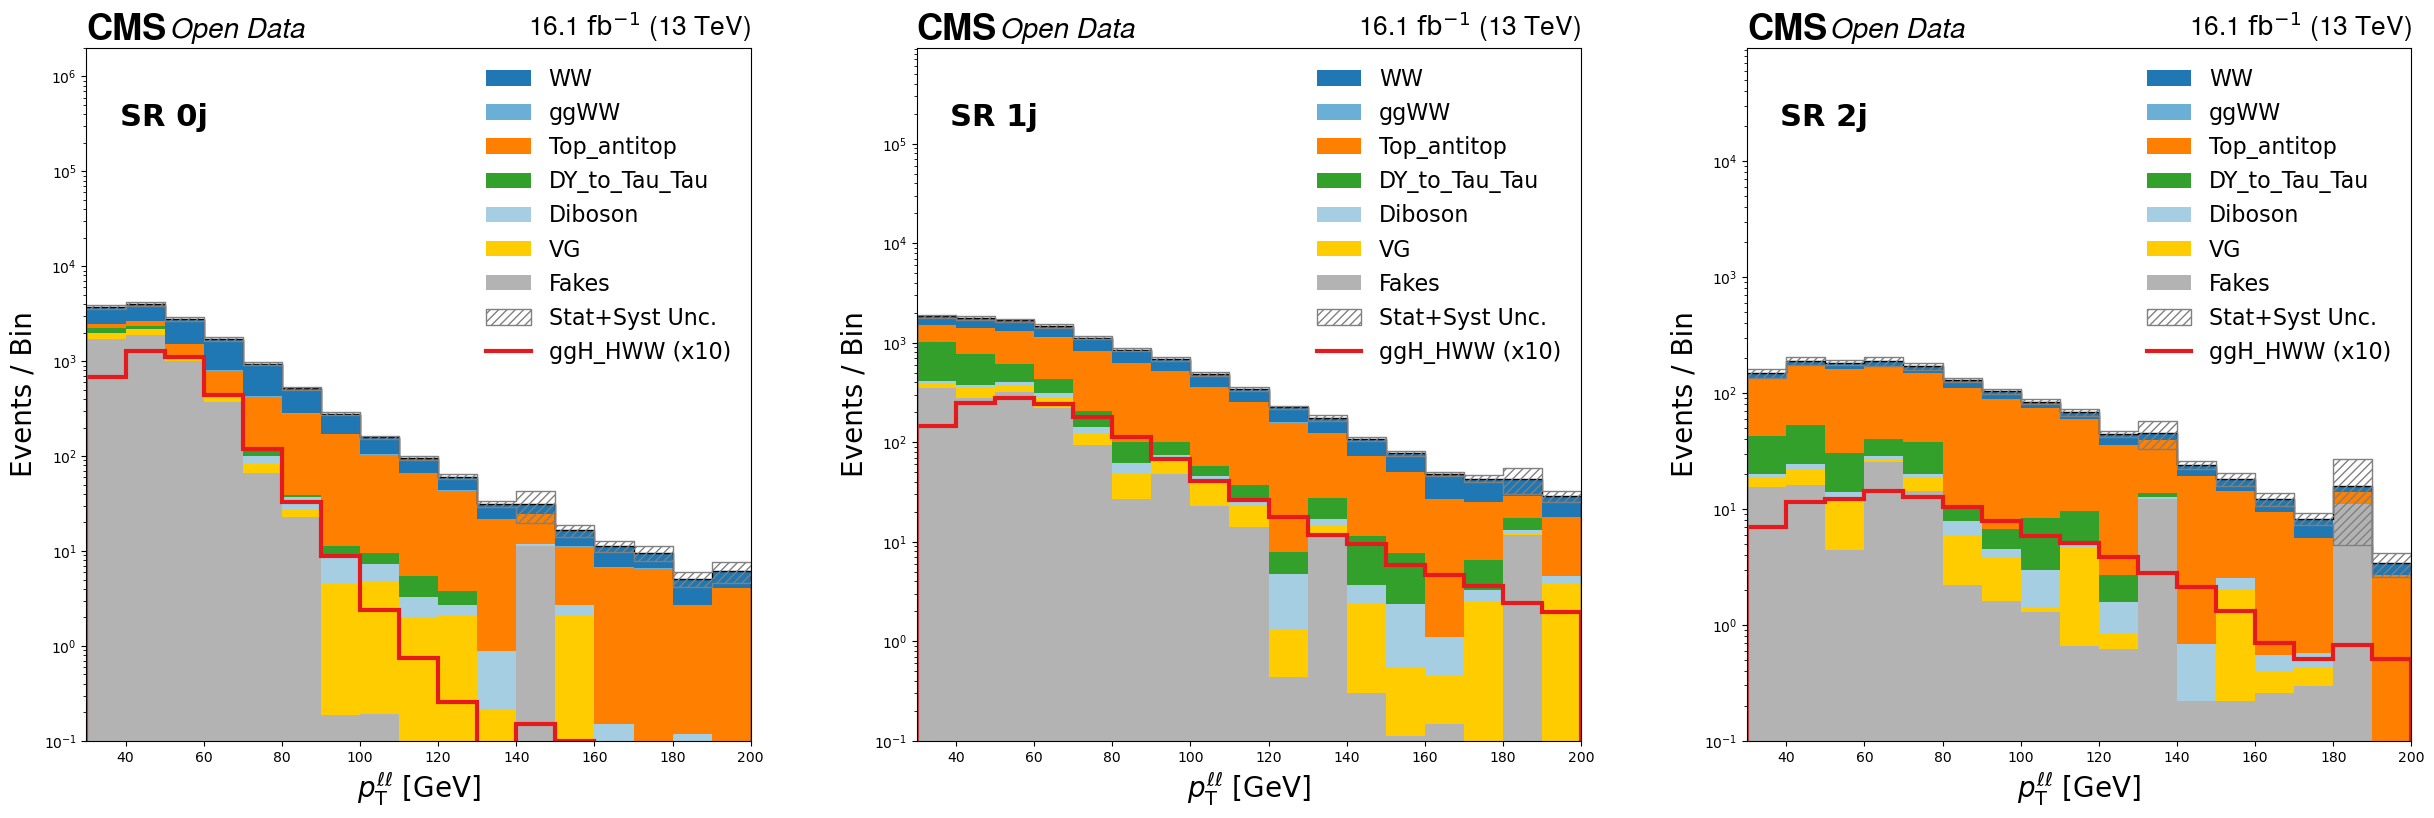

Plotting ptll in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_ptll.png


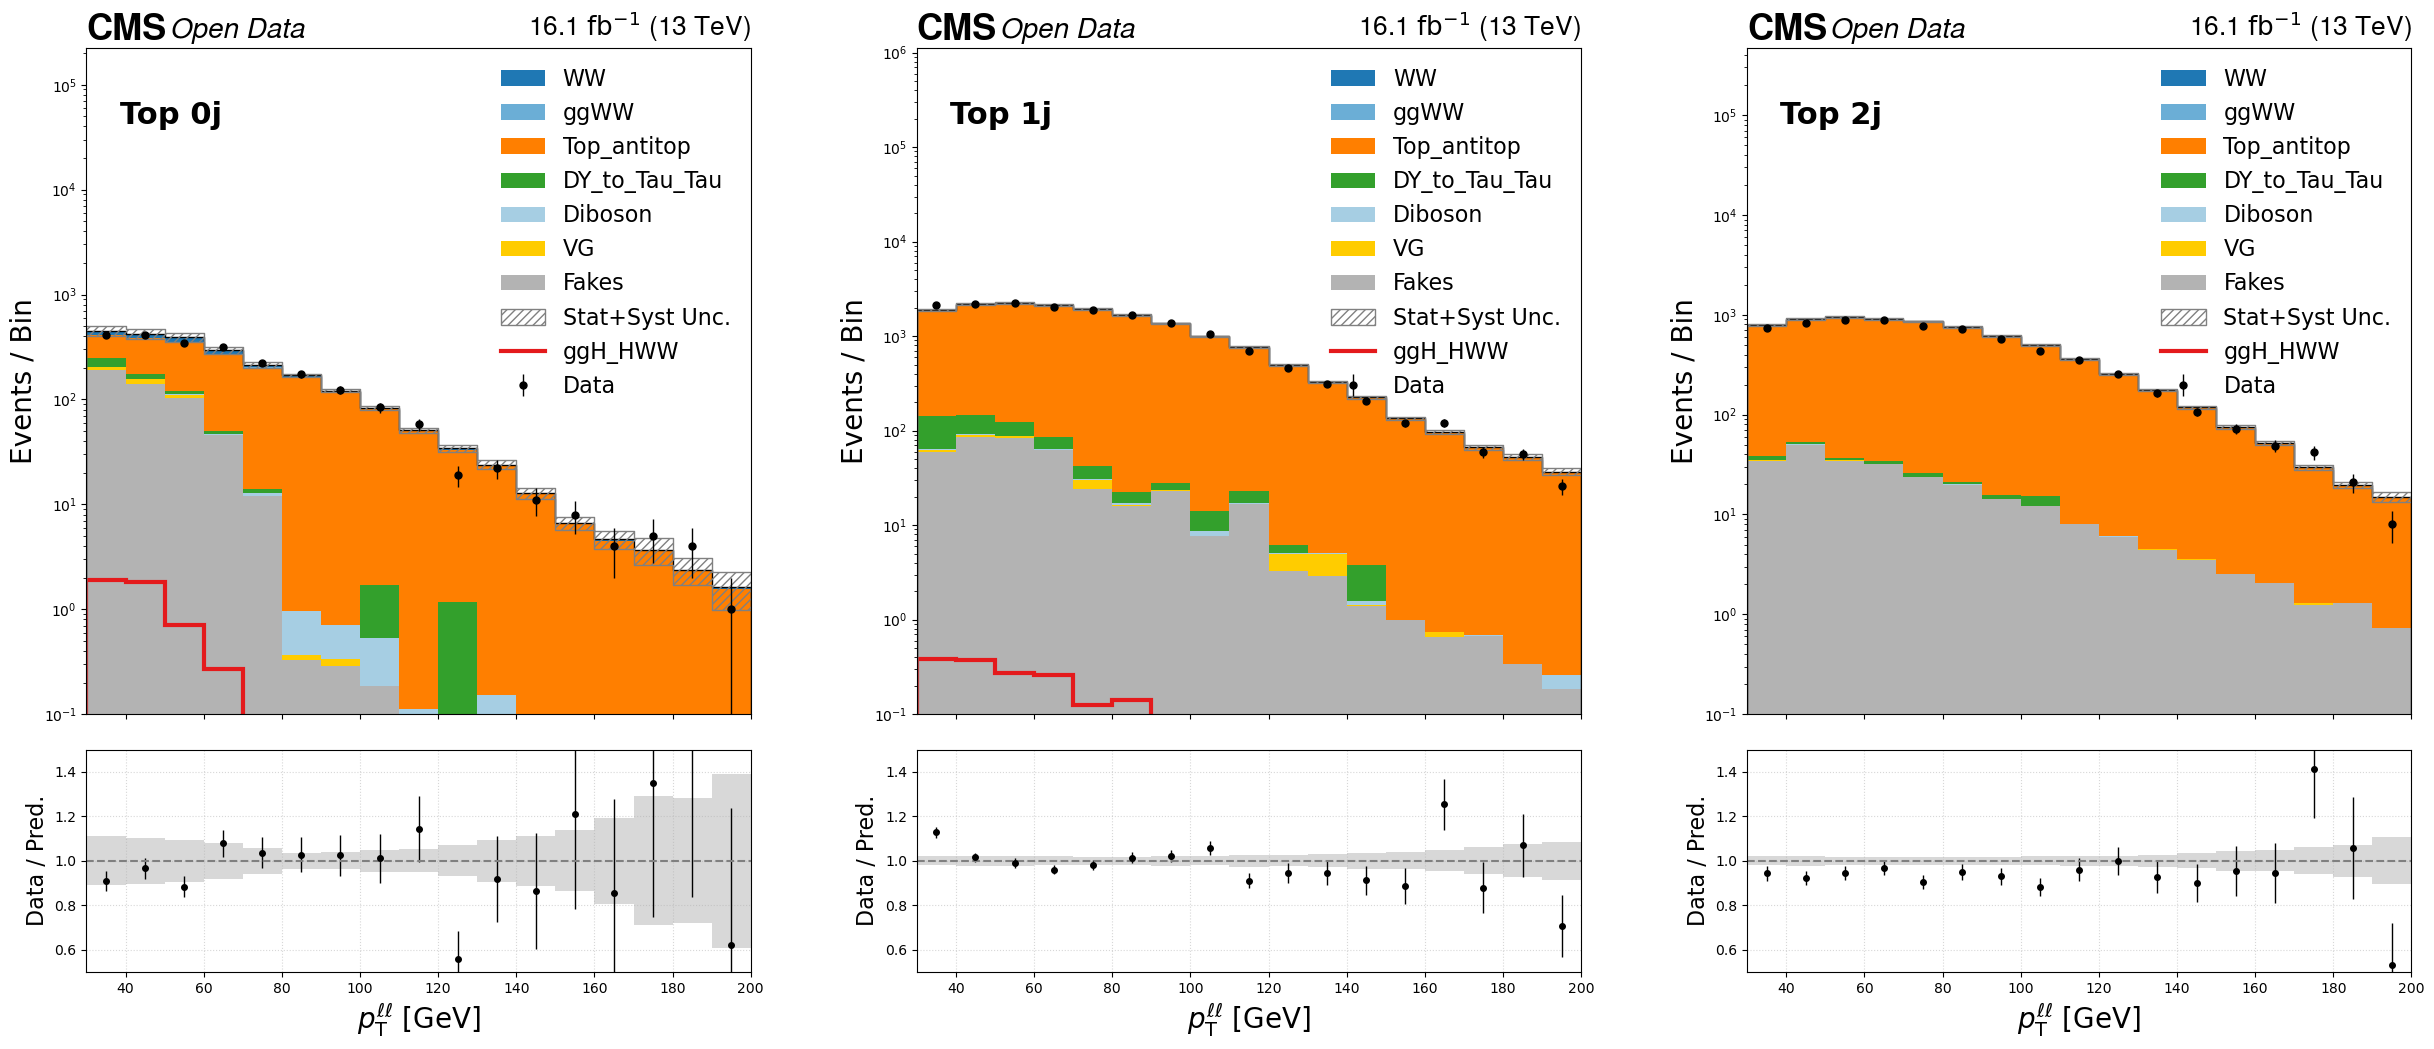

Plotting ptll in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_ptll.png


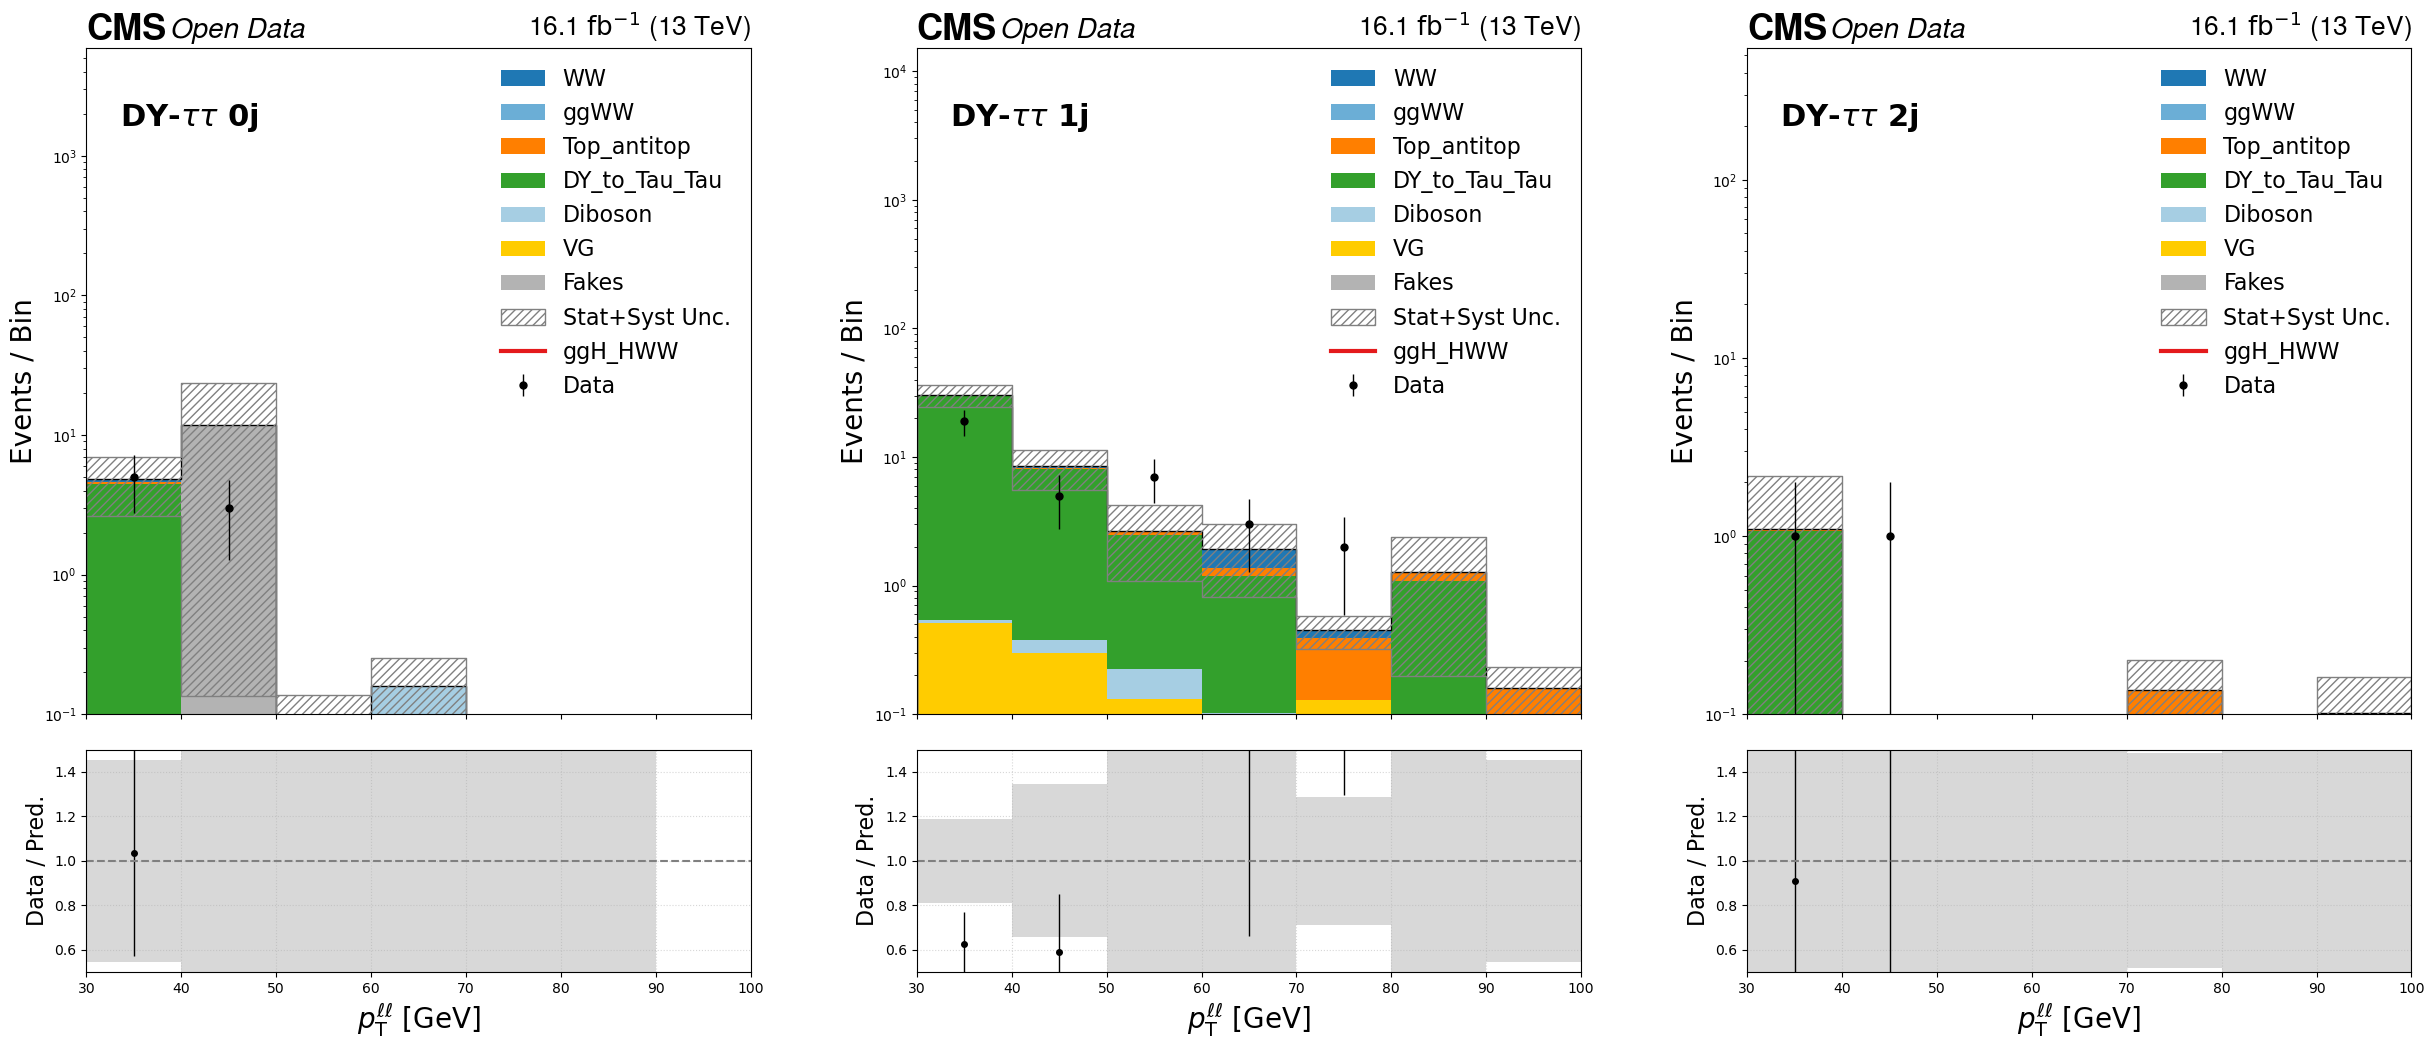

Plotting dphi in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_dphi.png


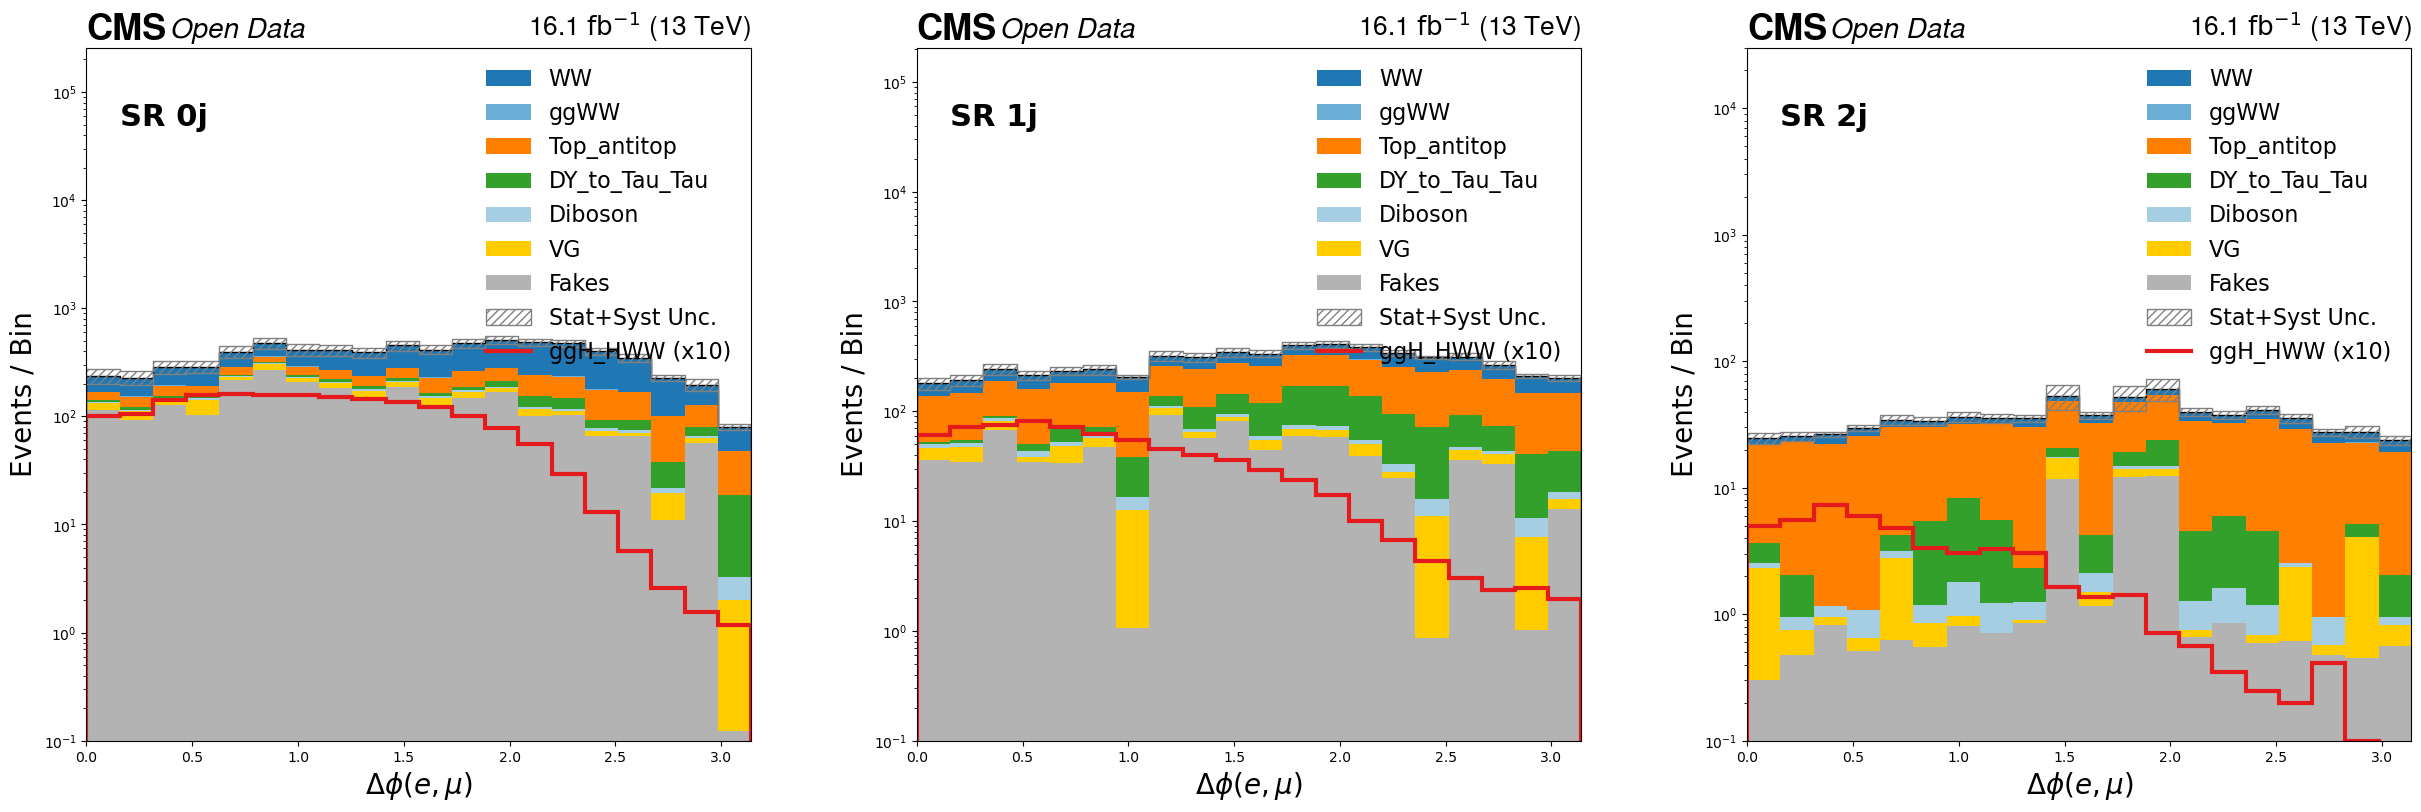

Plotting dphi in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_dphi.png


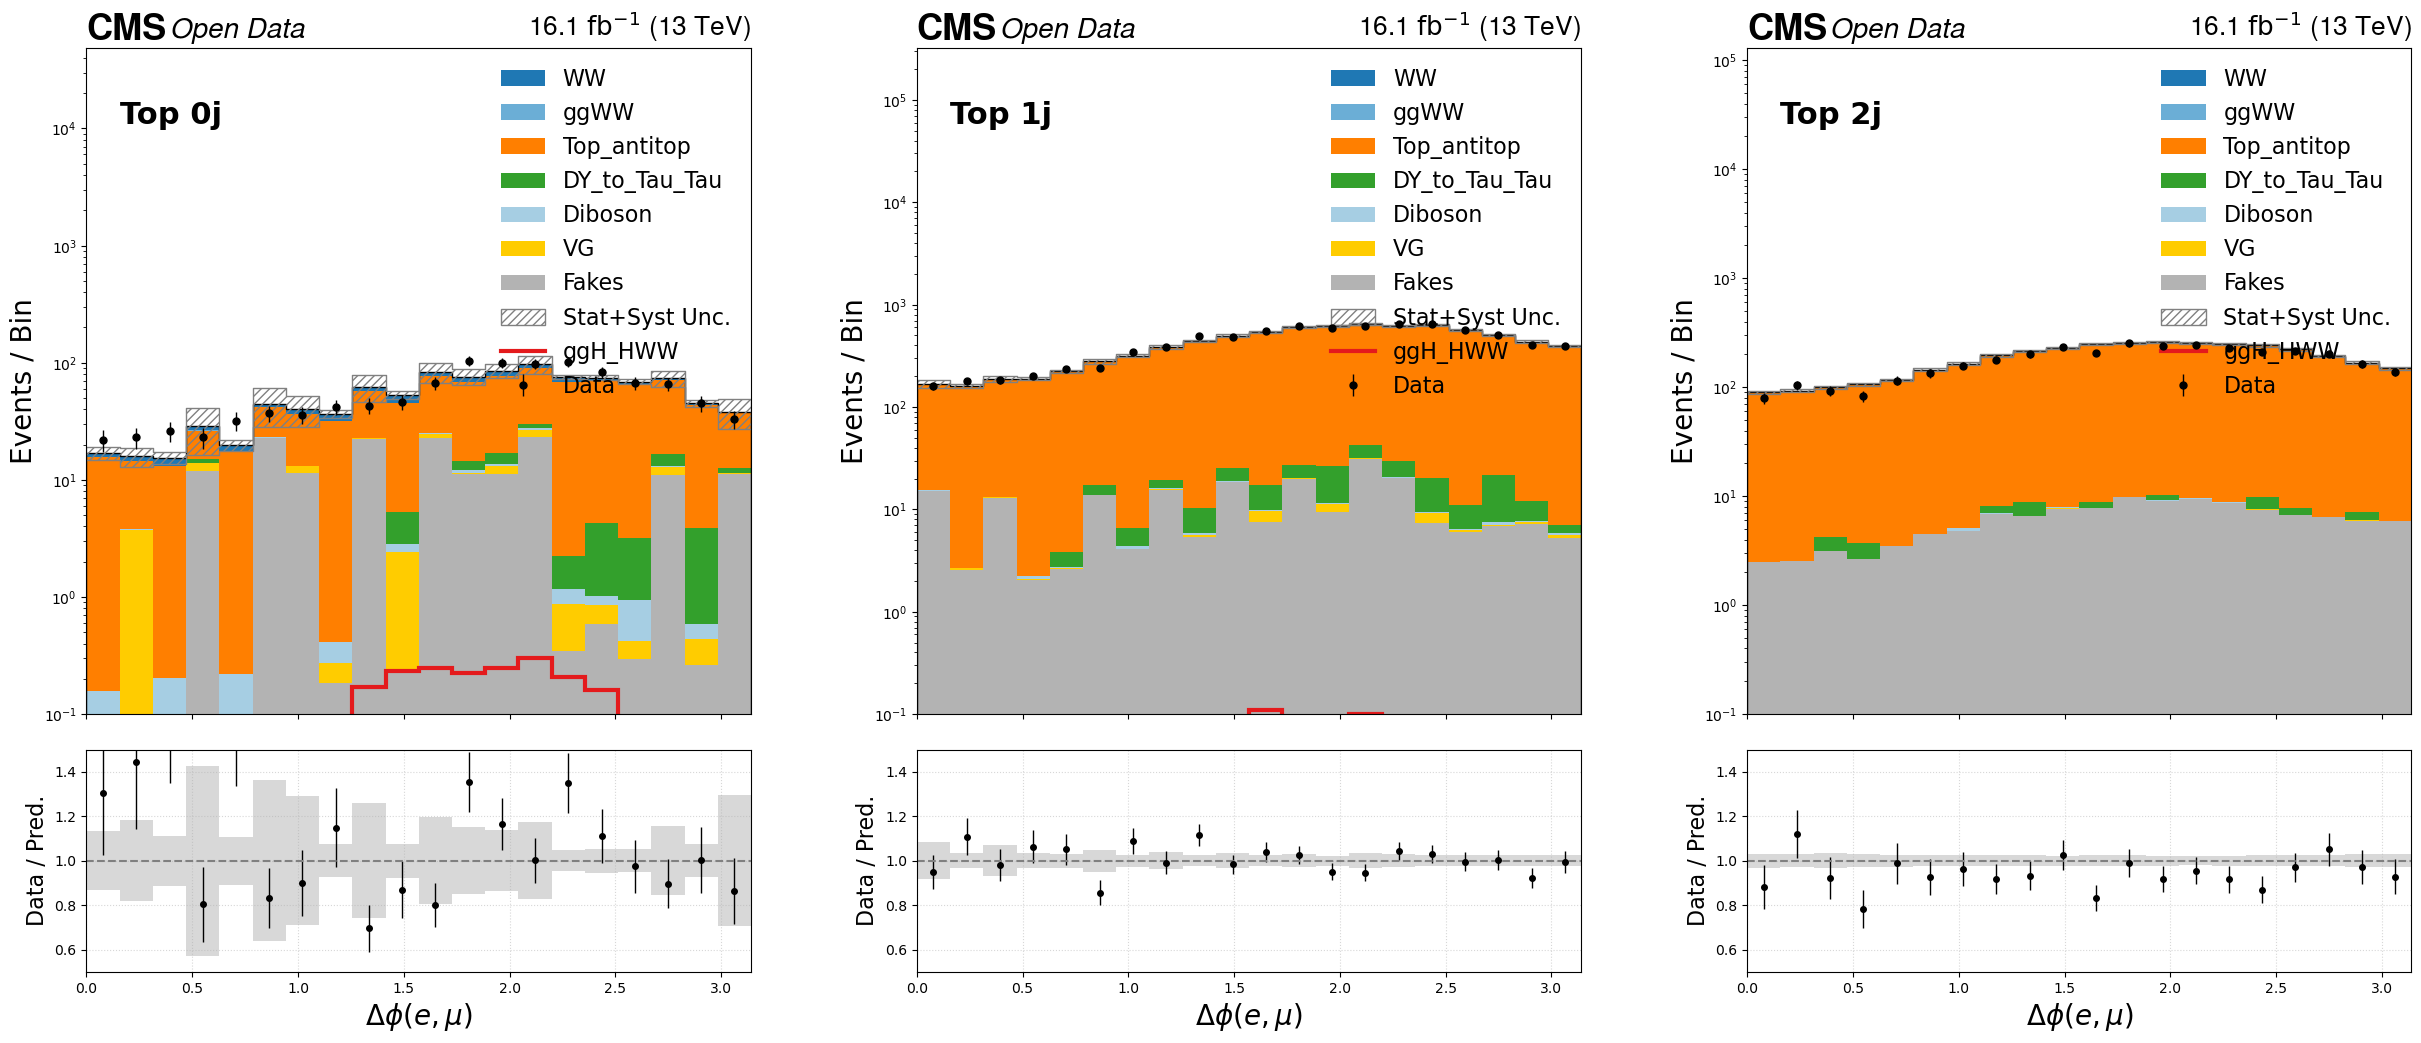

Plotting dphi in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_dphi.png


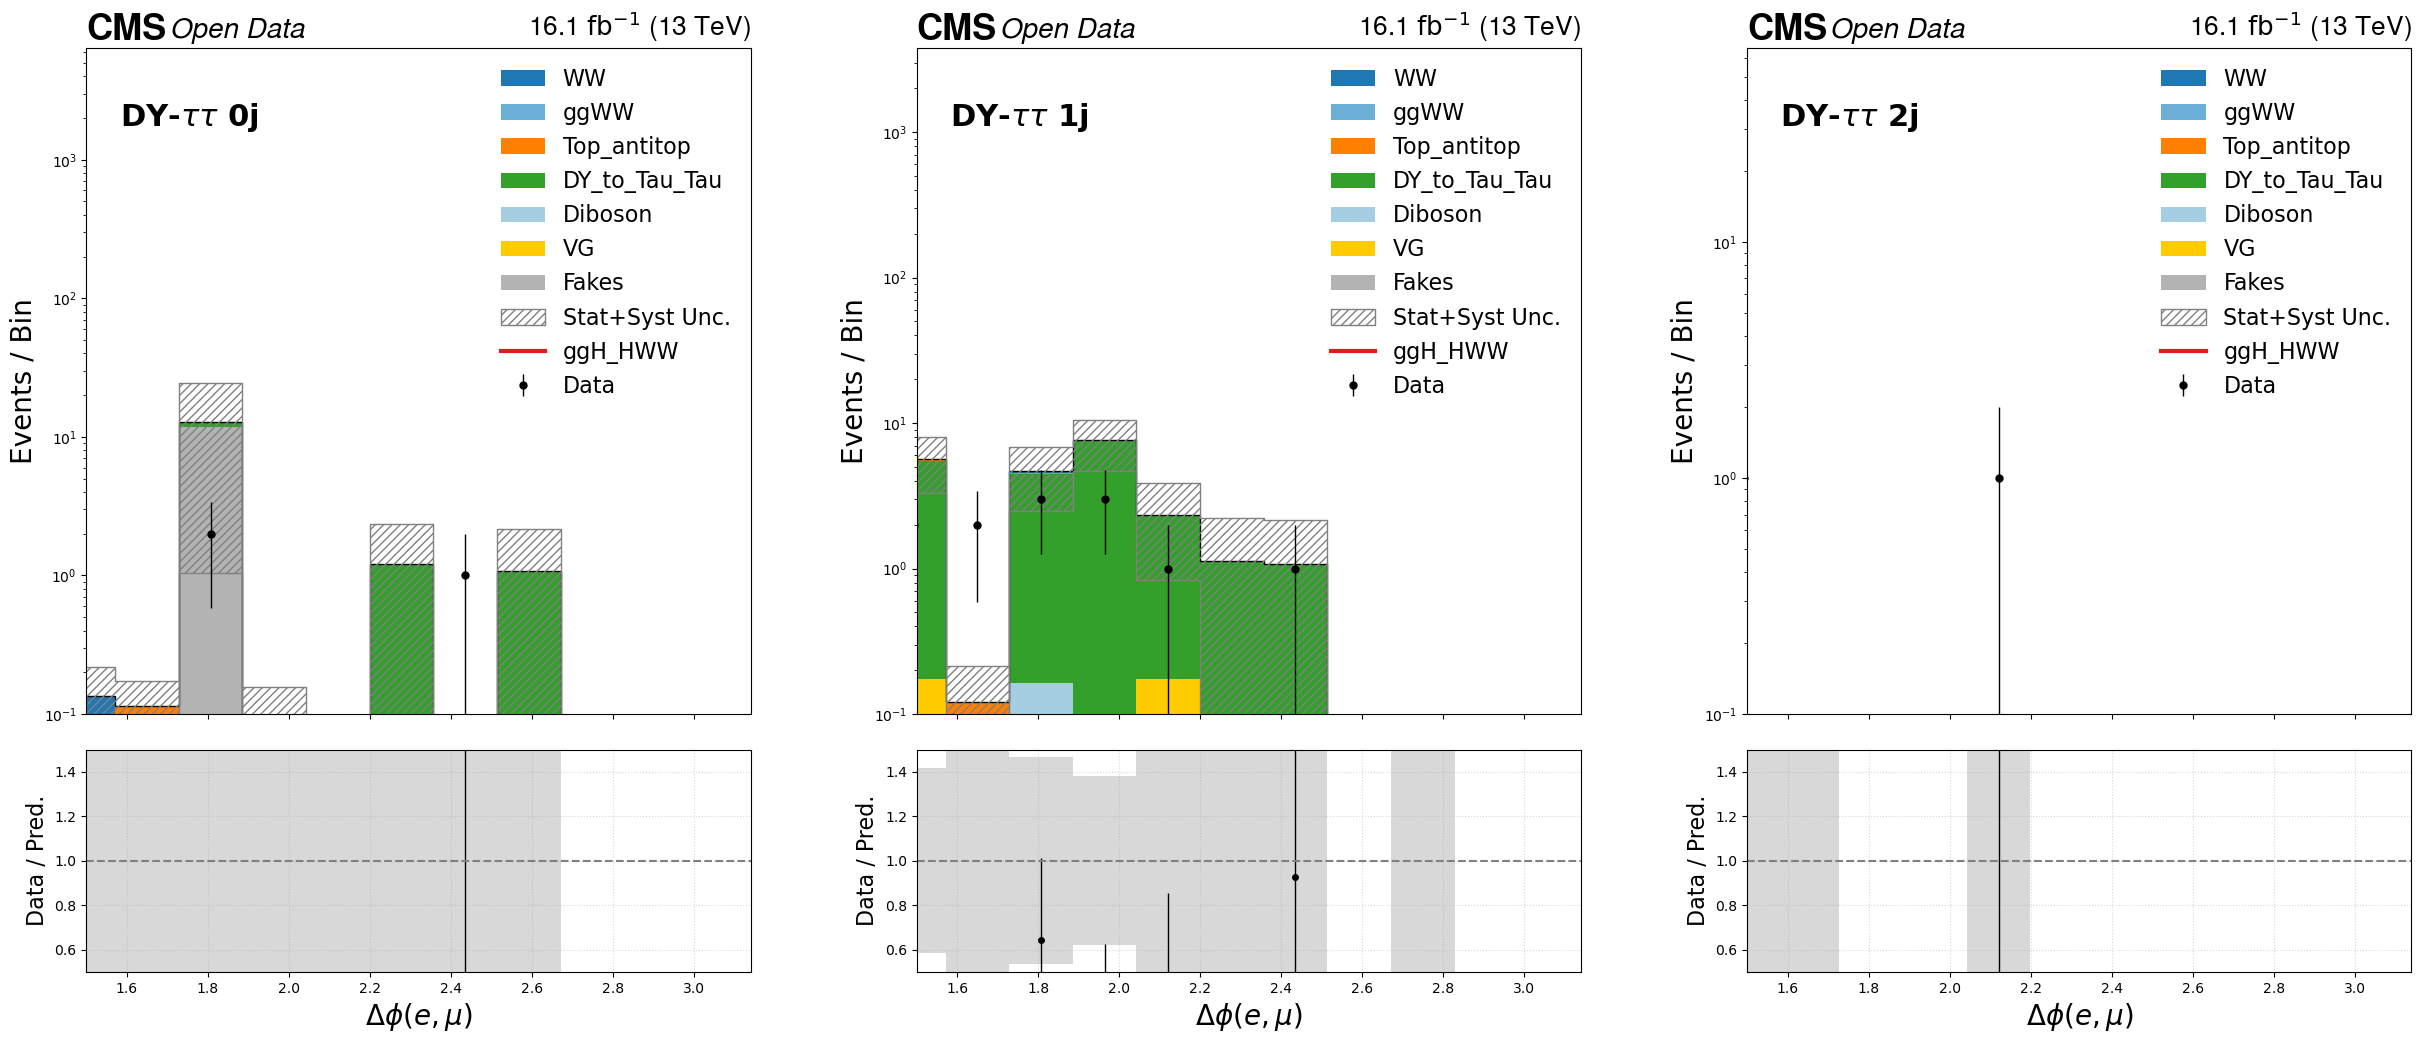

Plotting mt_higgs in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_higgs.png


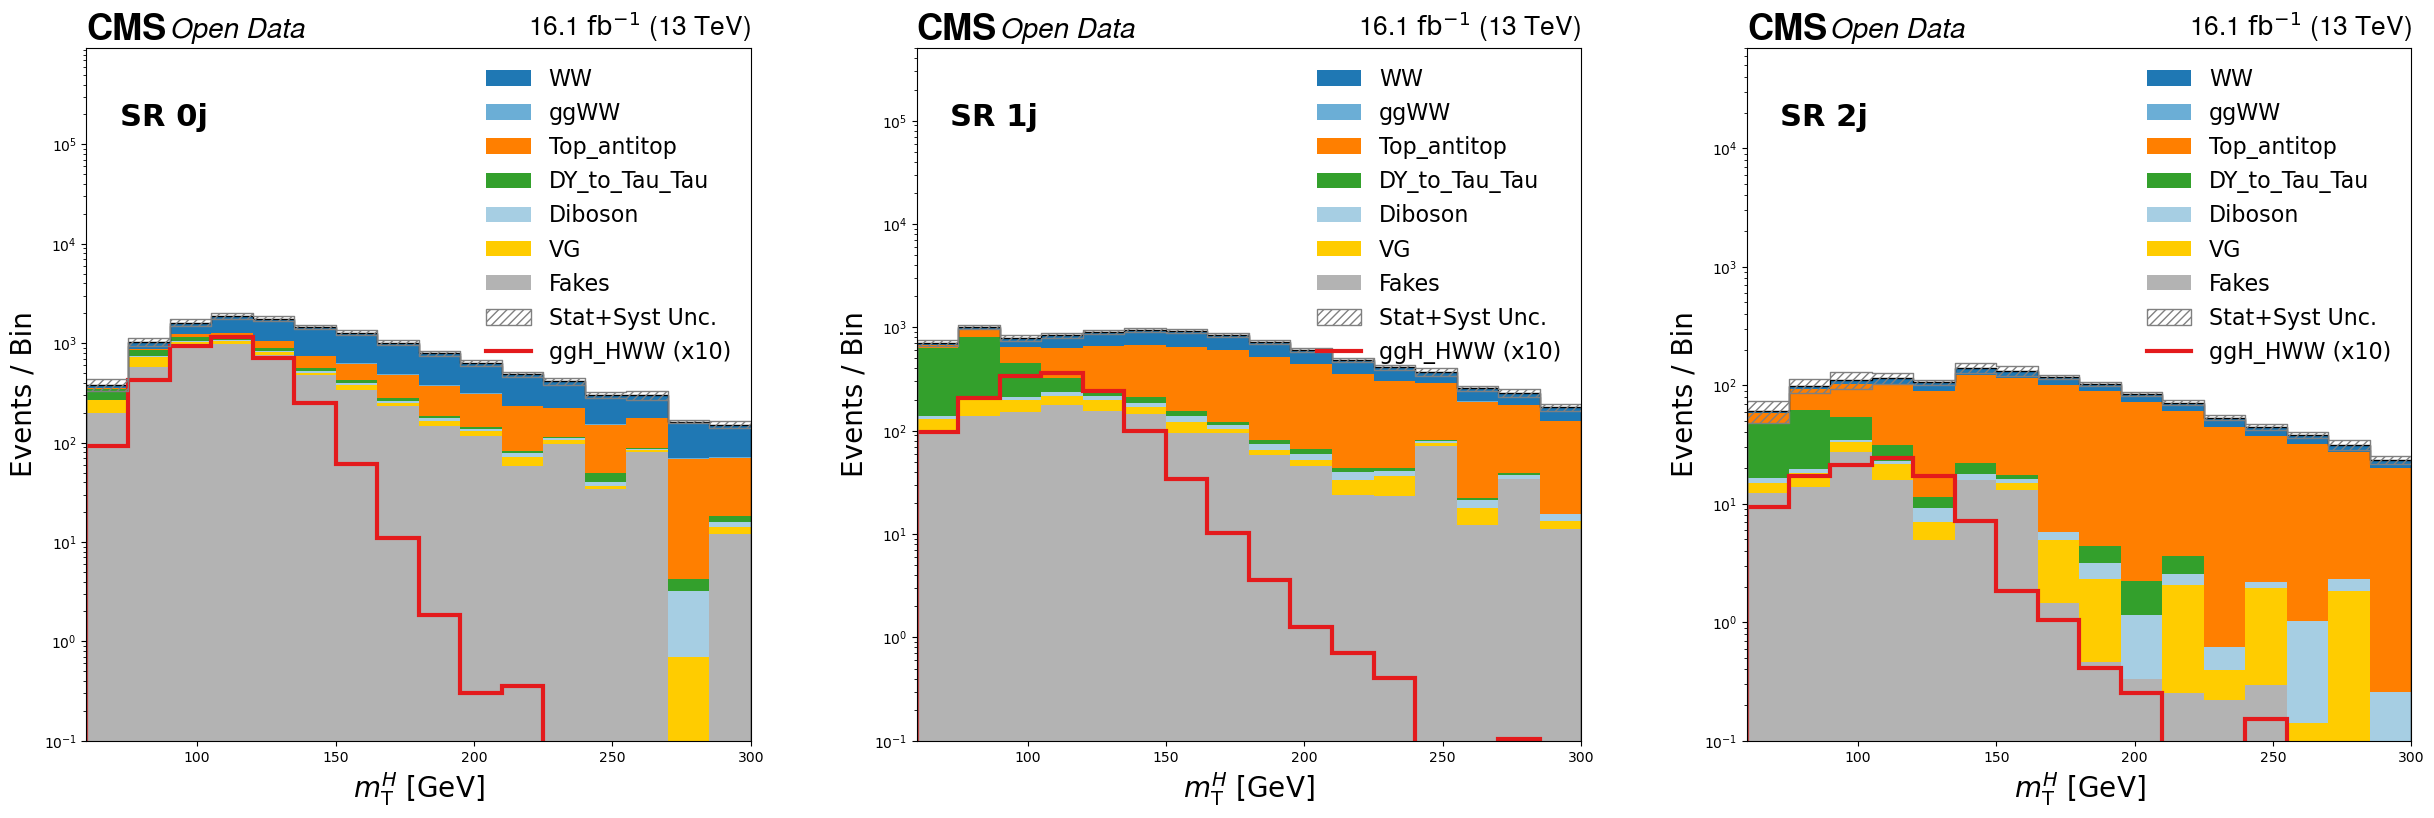

Plotting mt_higgs in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_higgs.png


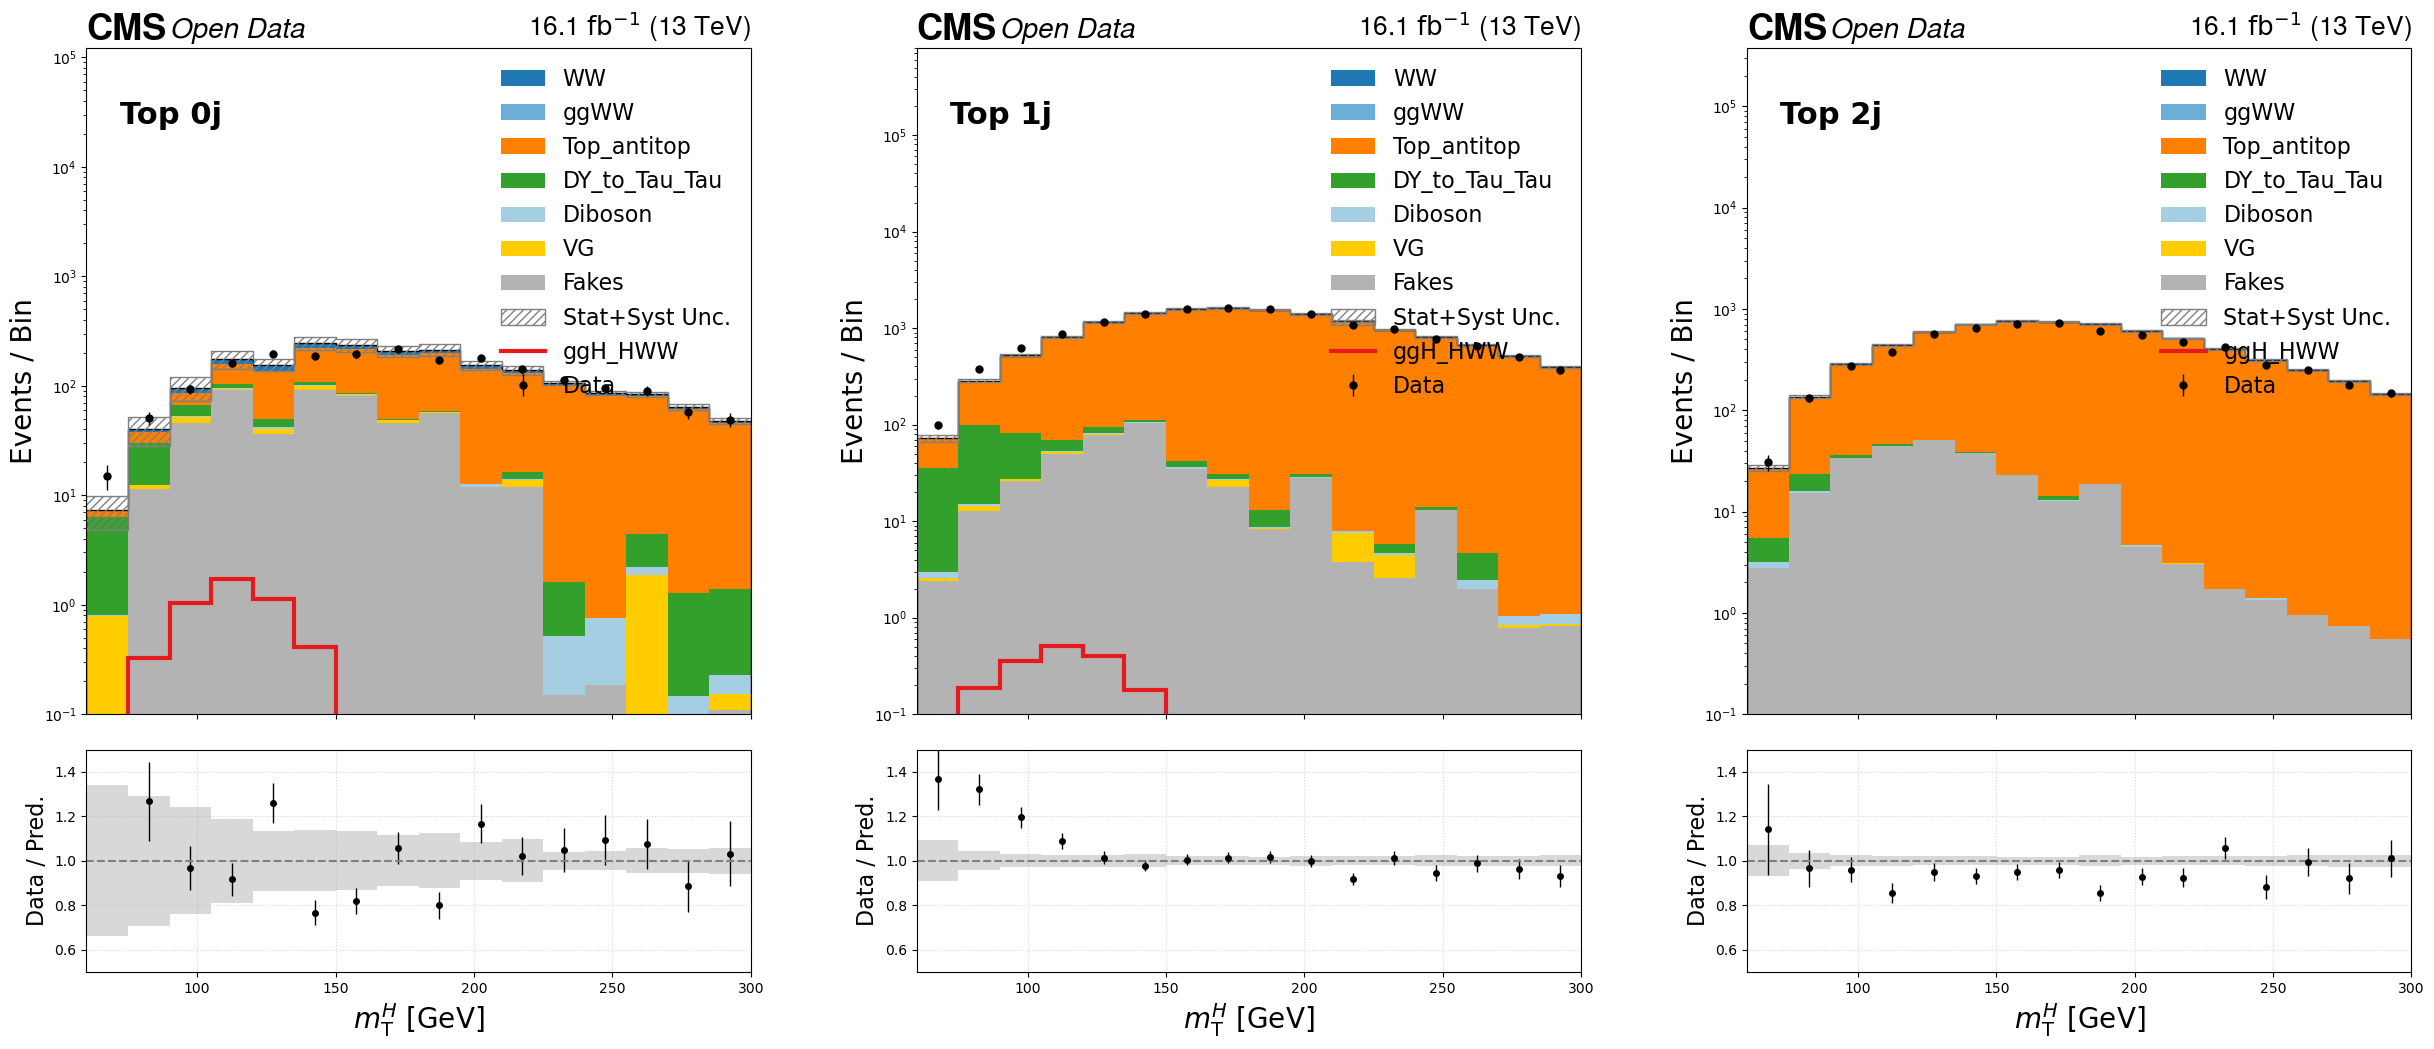

Plotting mt_higgs in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_higgs.png


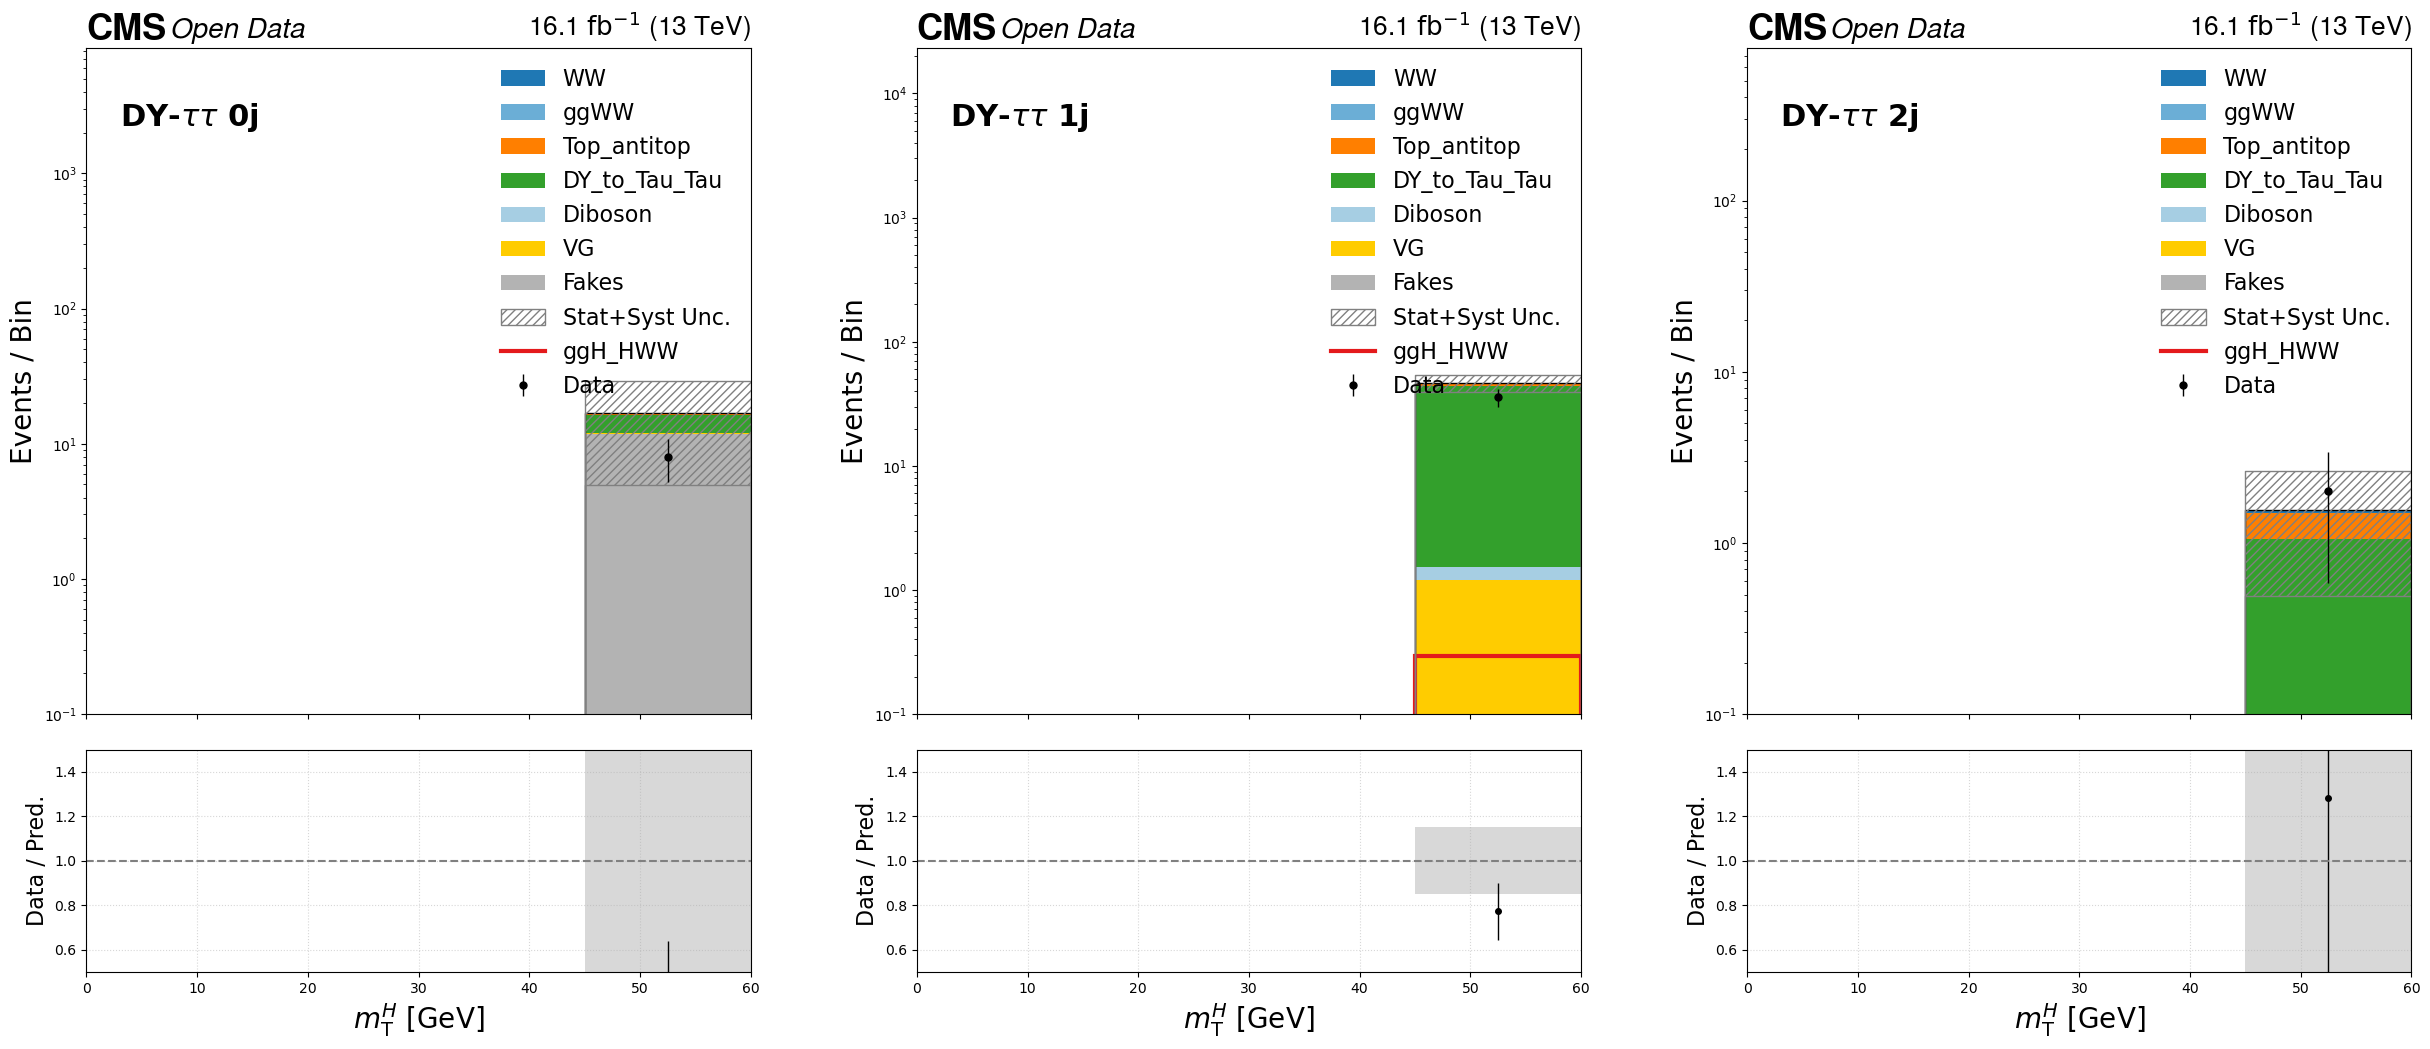

Plotting mt_l2_met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_l2_met.png


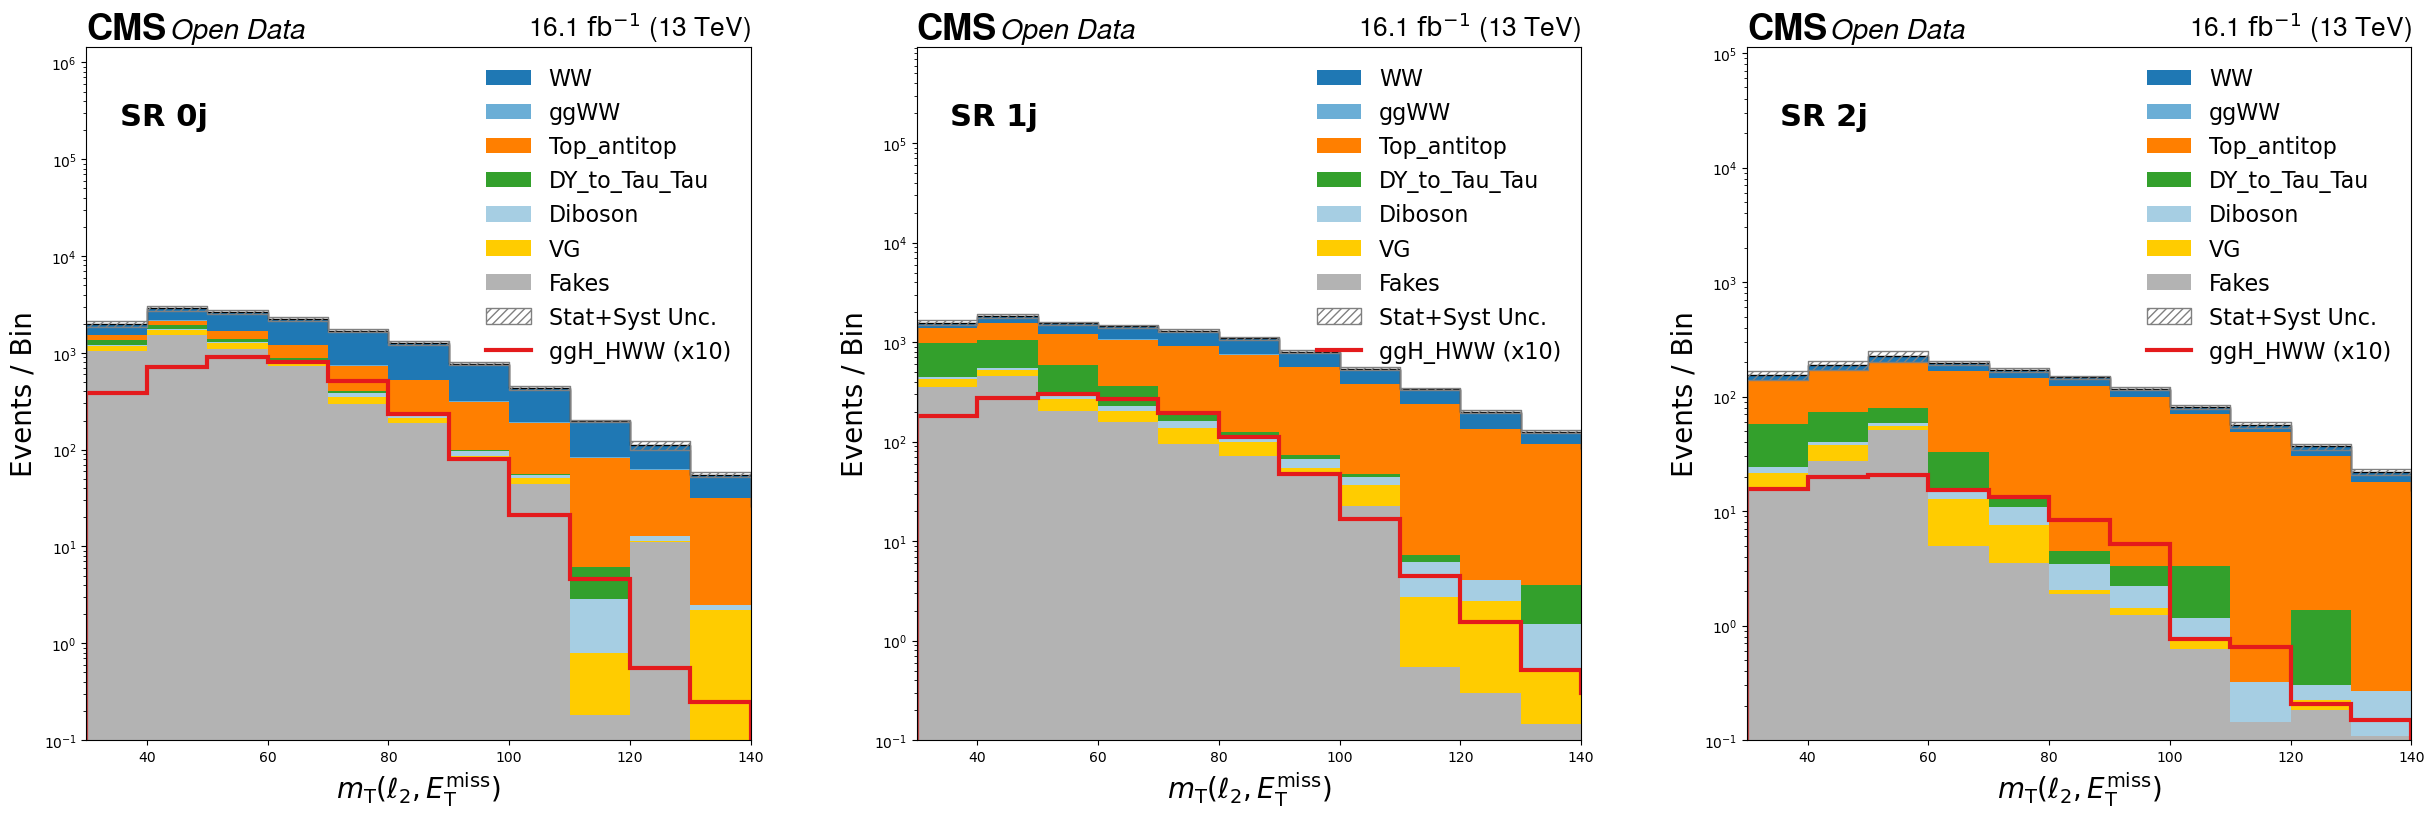

Plotting mt_l2_met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_l2_met.png


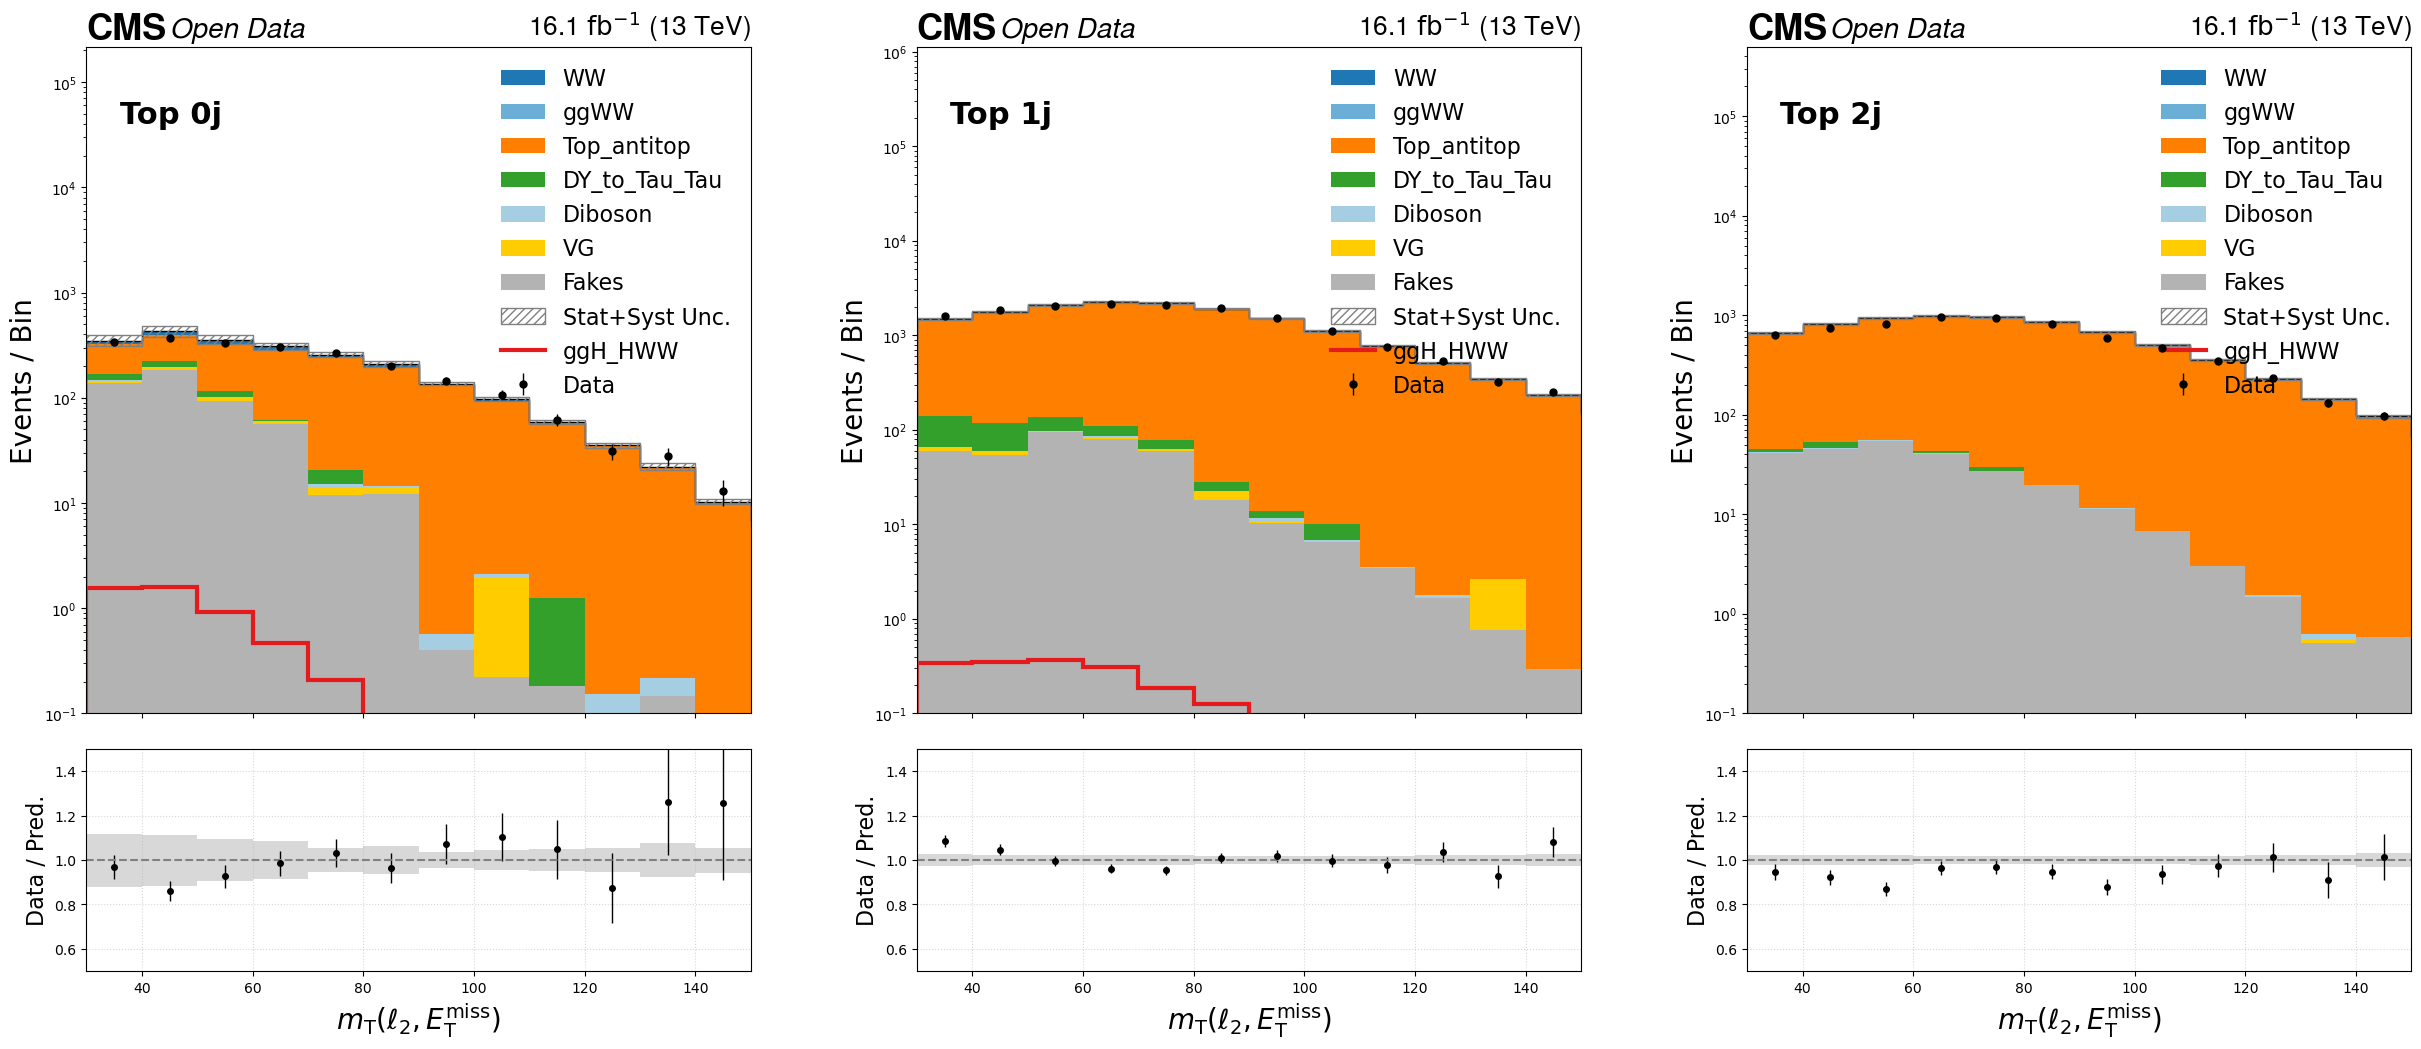

Plotting mt_l2_met in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_l2_met.png


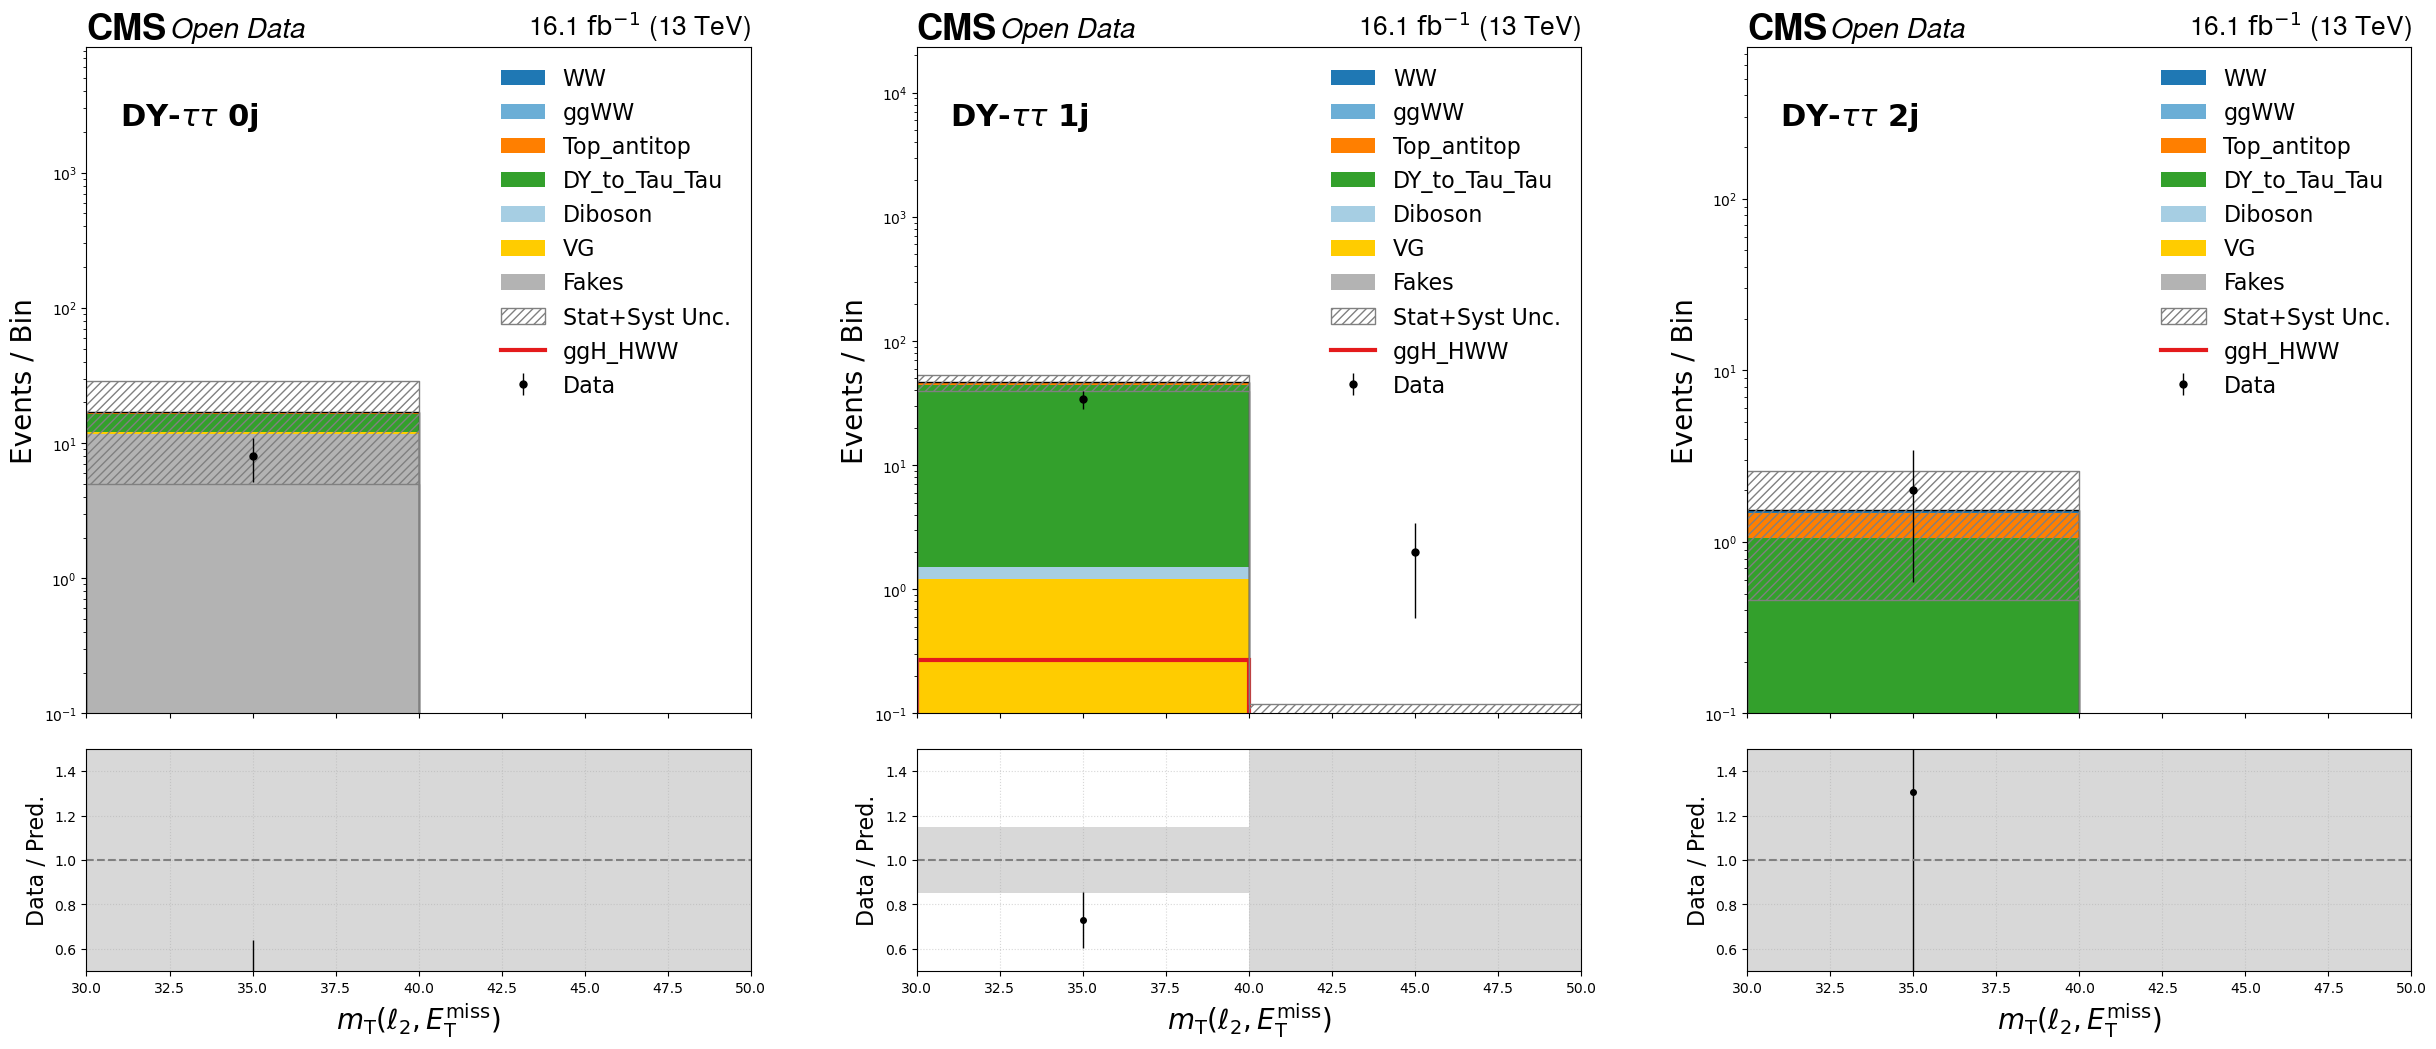

Plotting mjj in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mjj.png


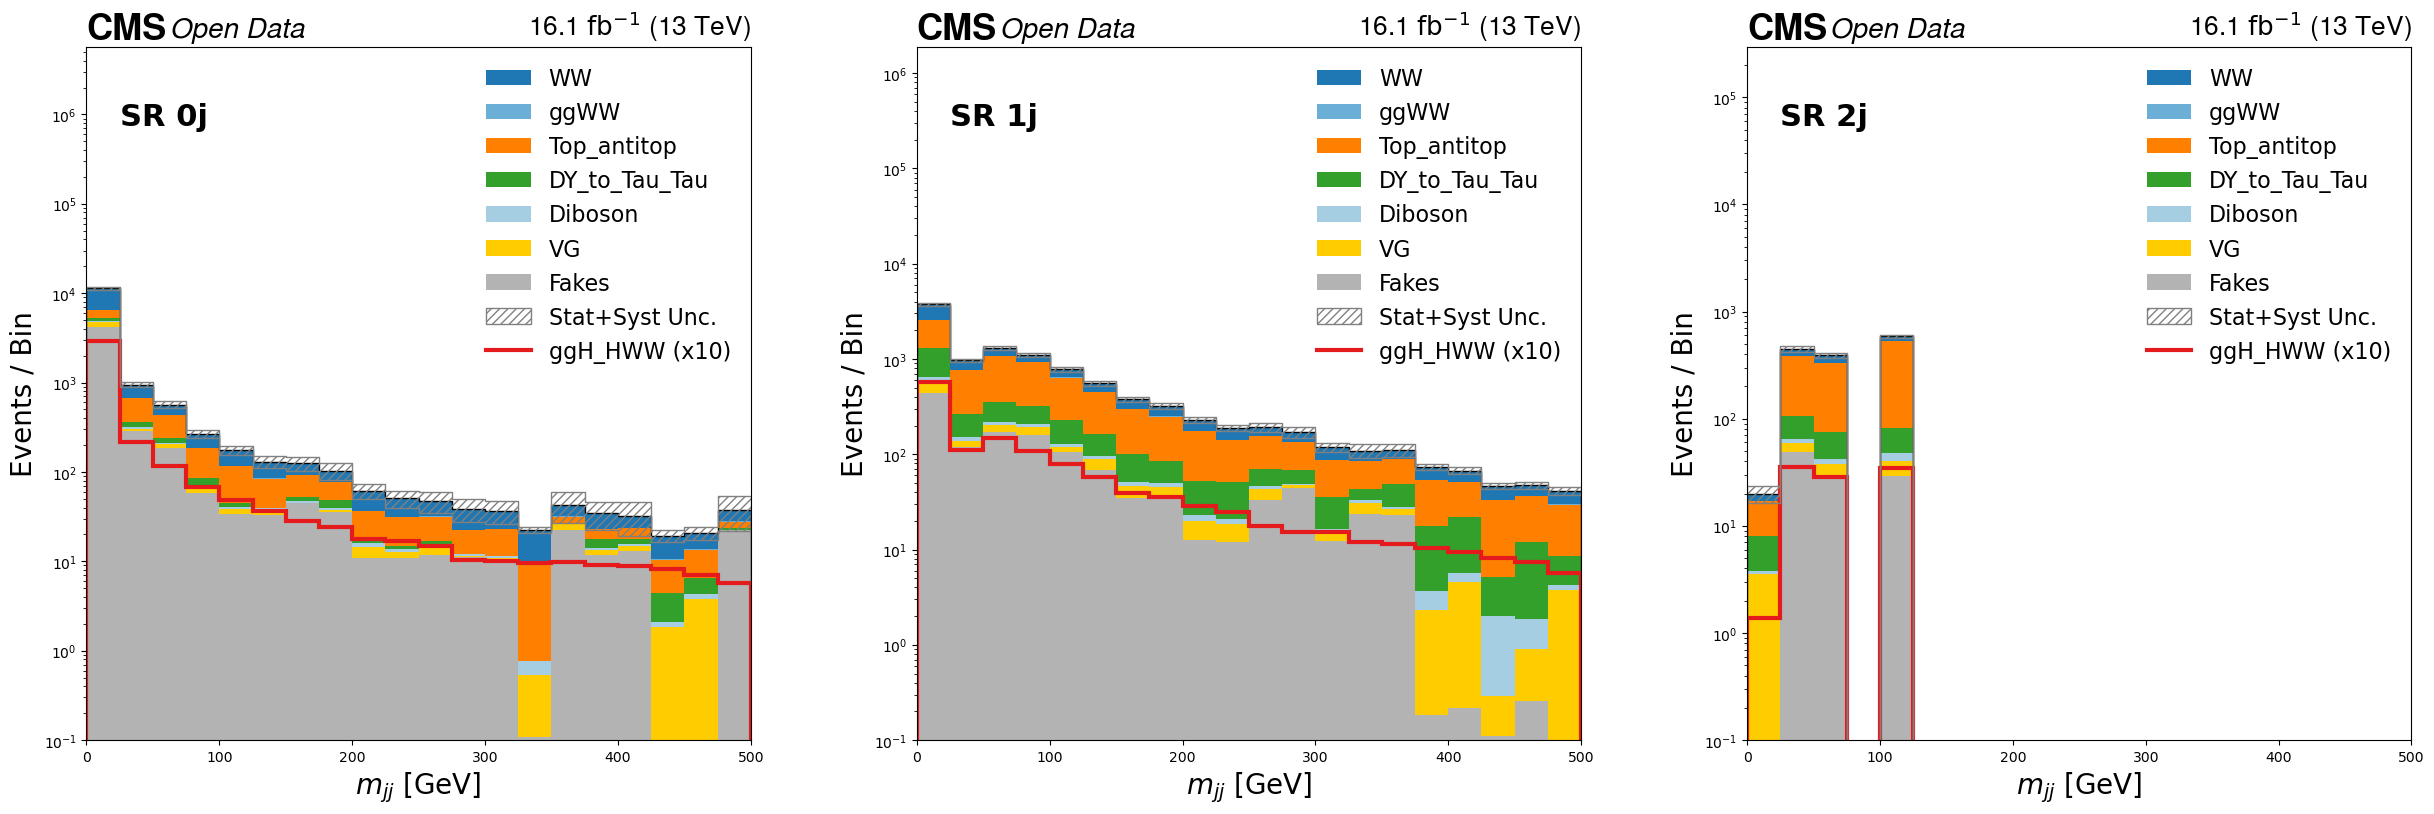

Plotting mjj in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mjj.png


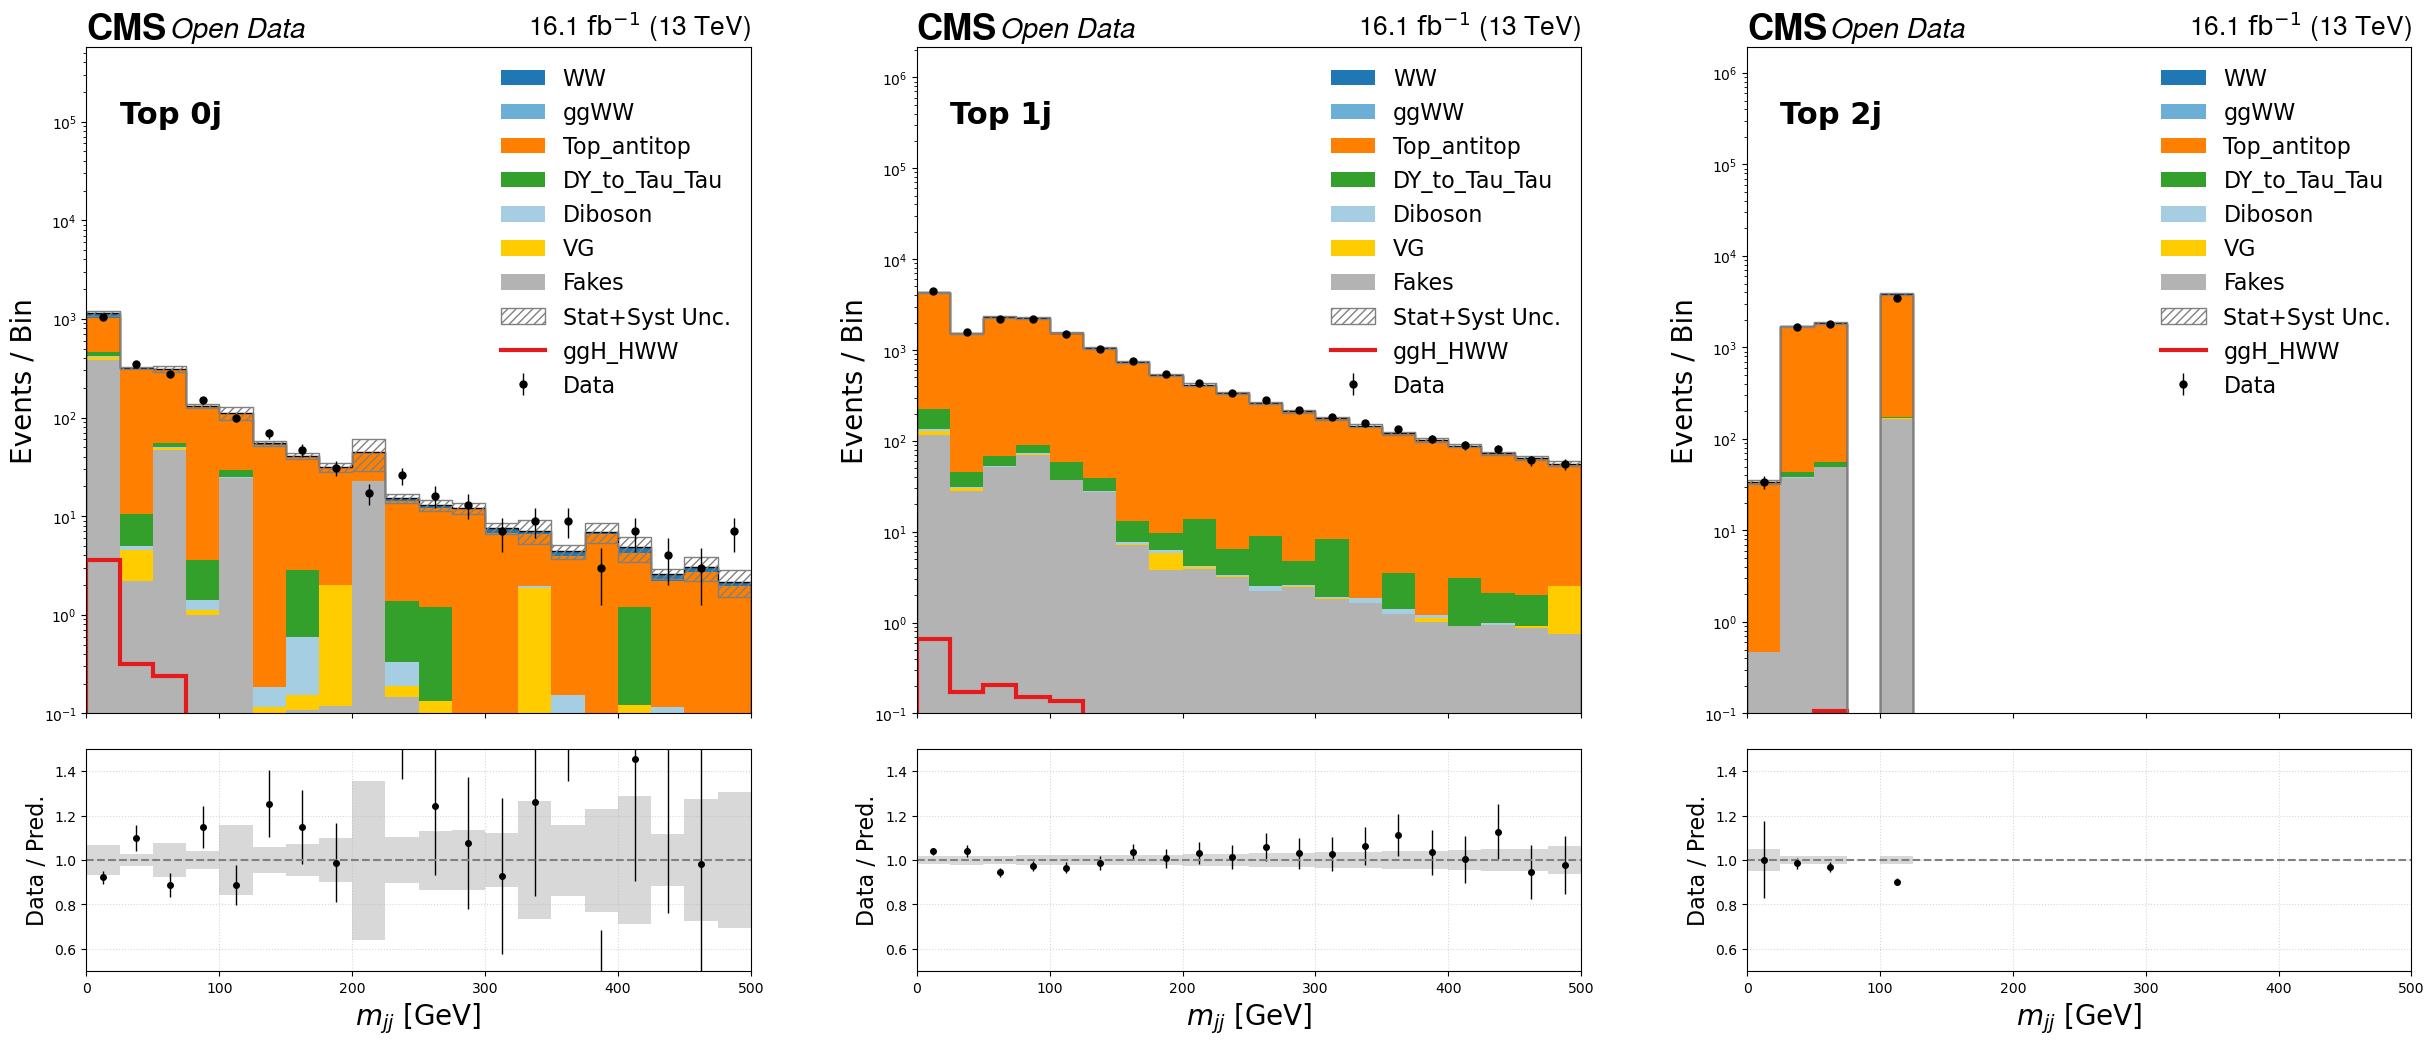

Plotting mjj in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mjj.png


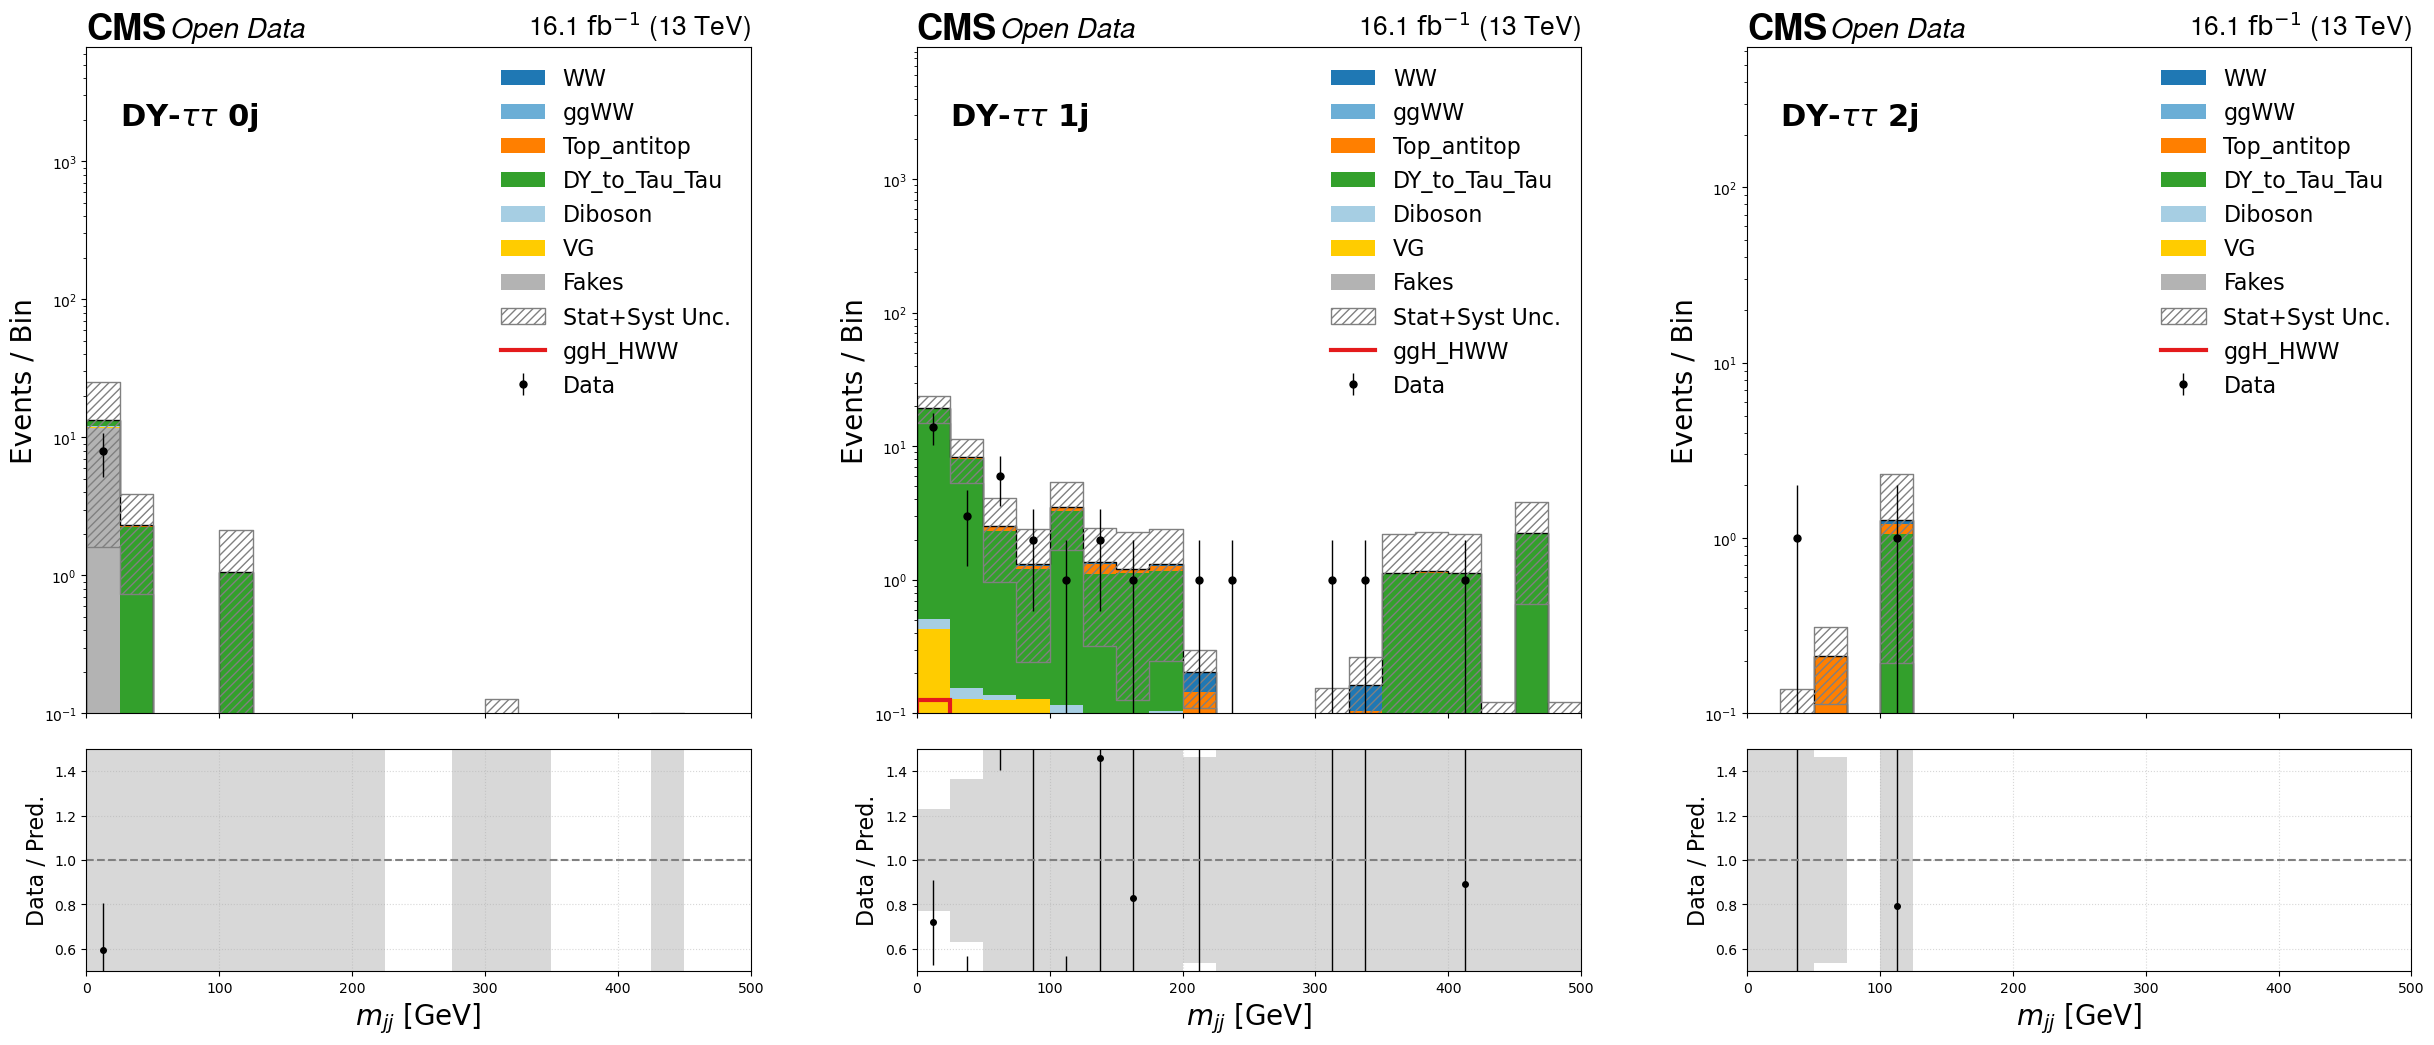

Plotting leading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_leading_pt.png


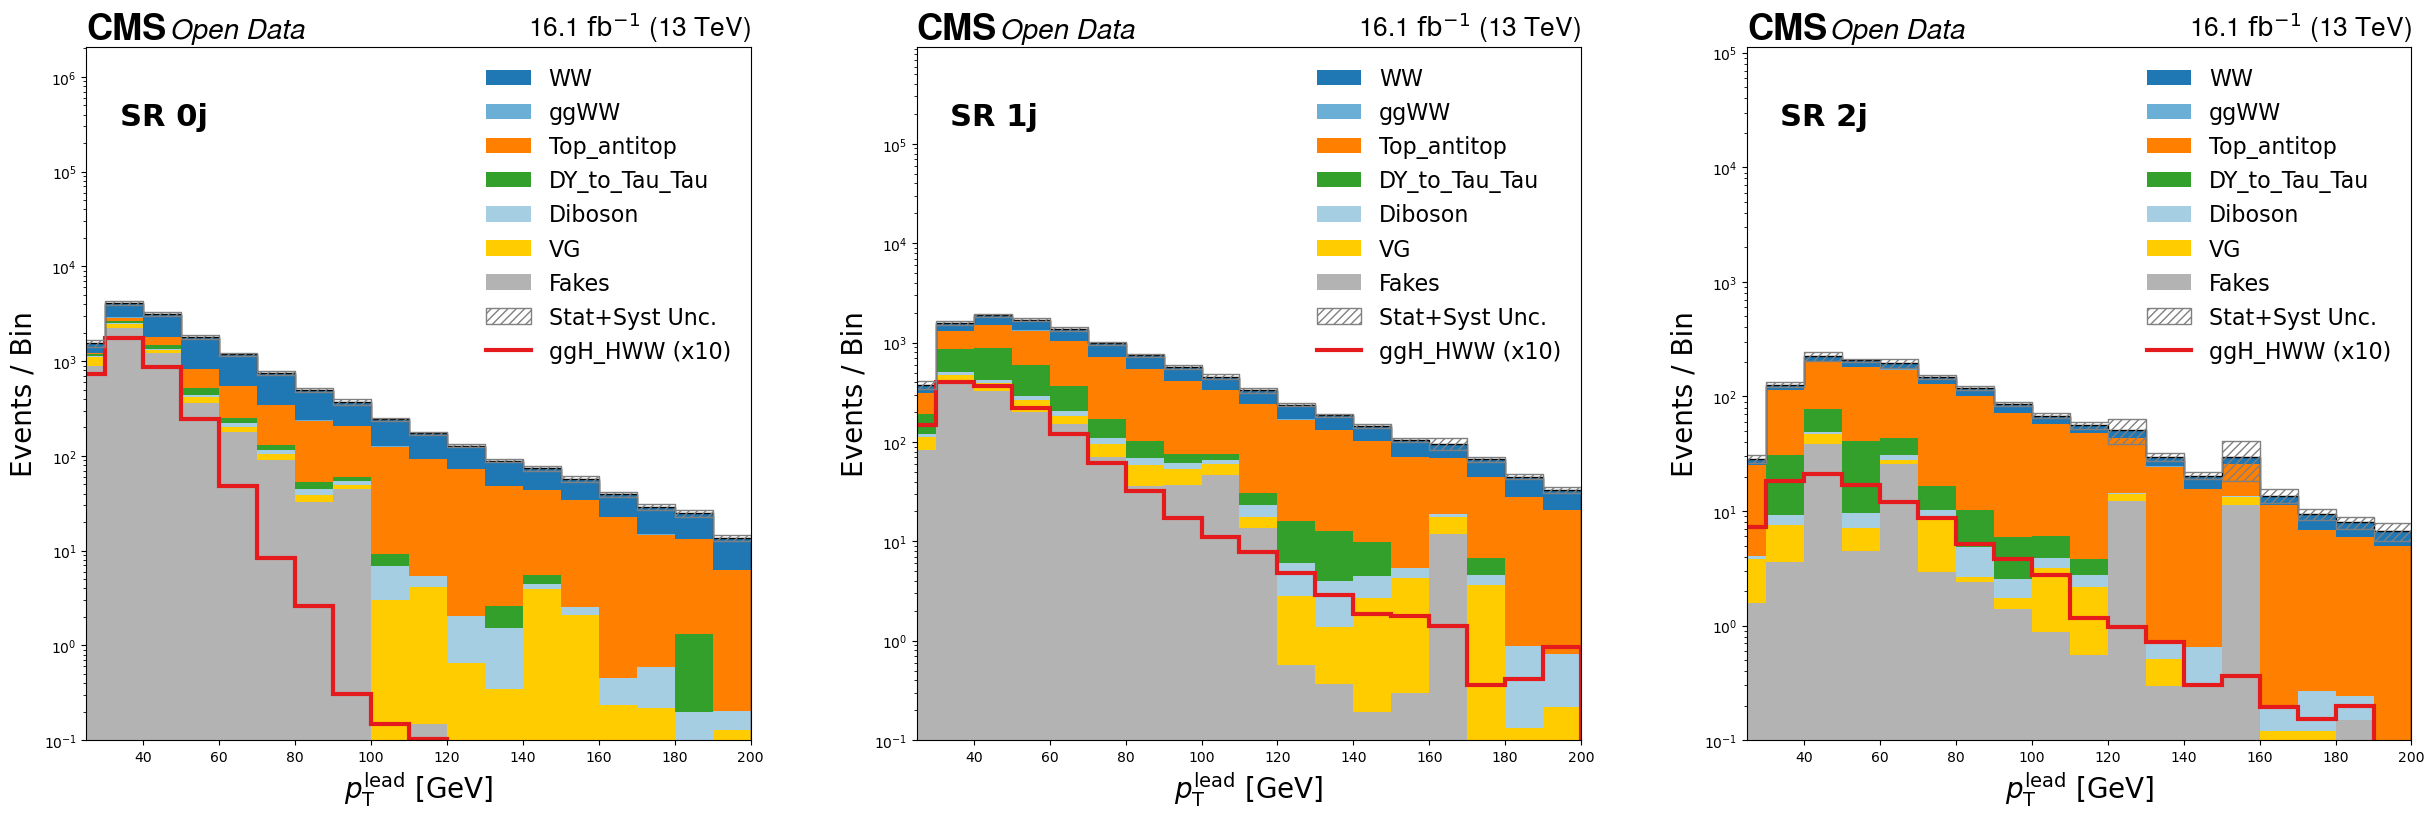

Plotting leading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_leading_pt.png


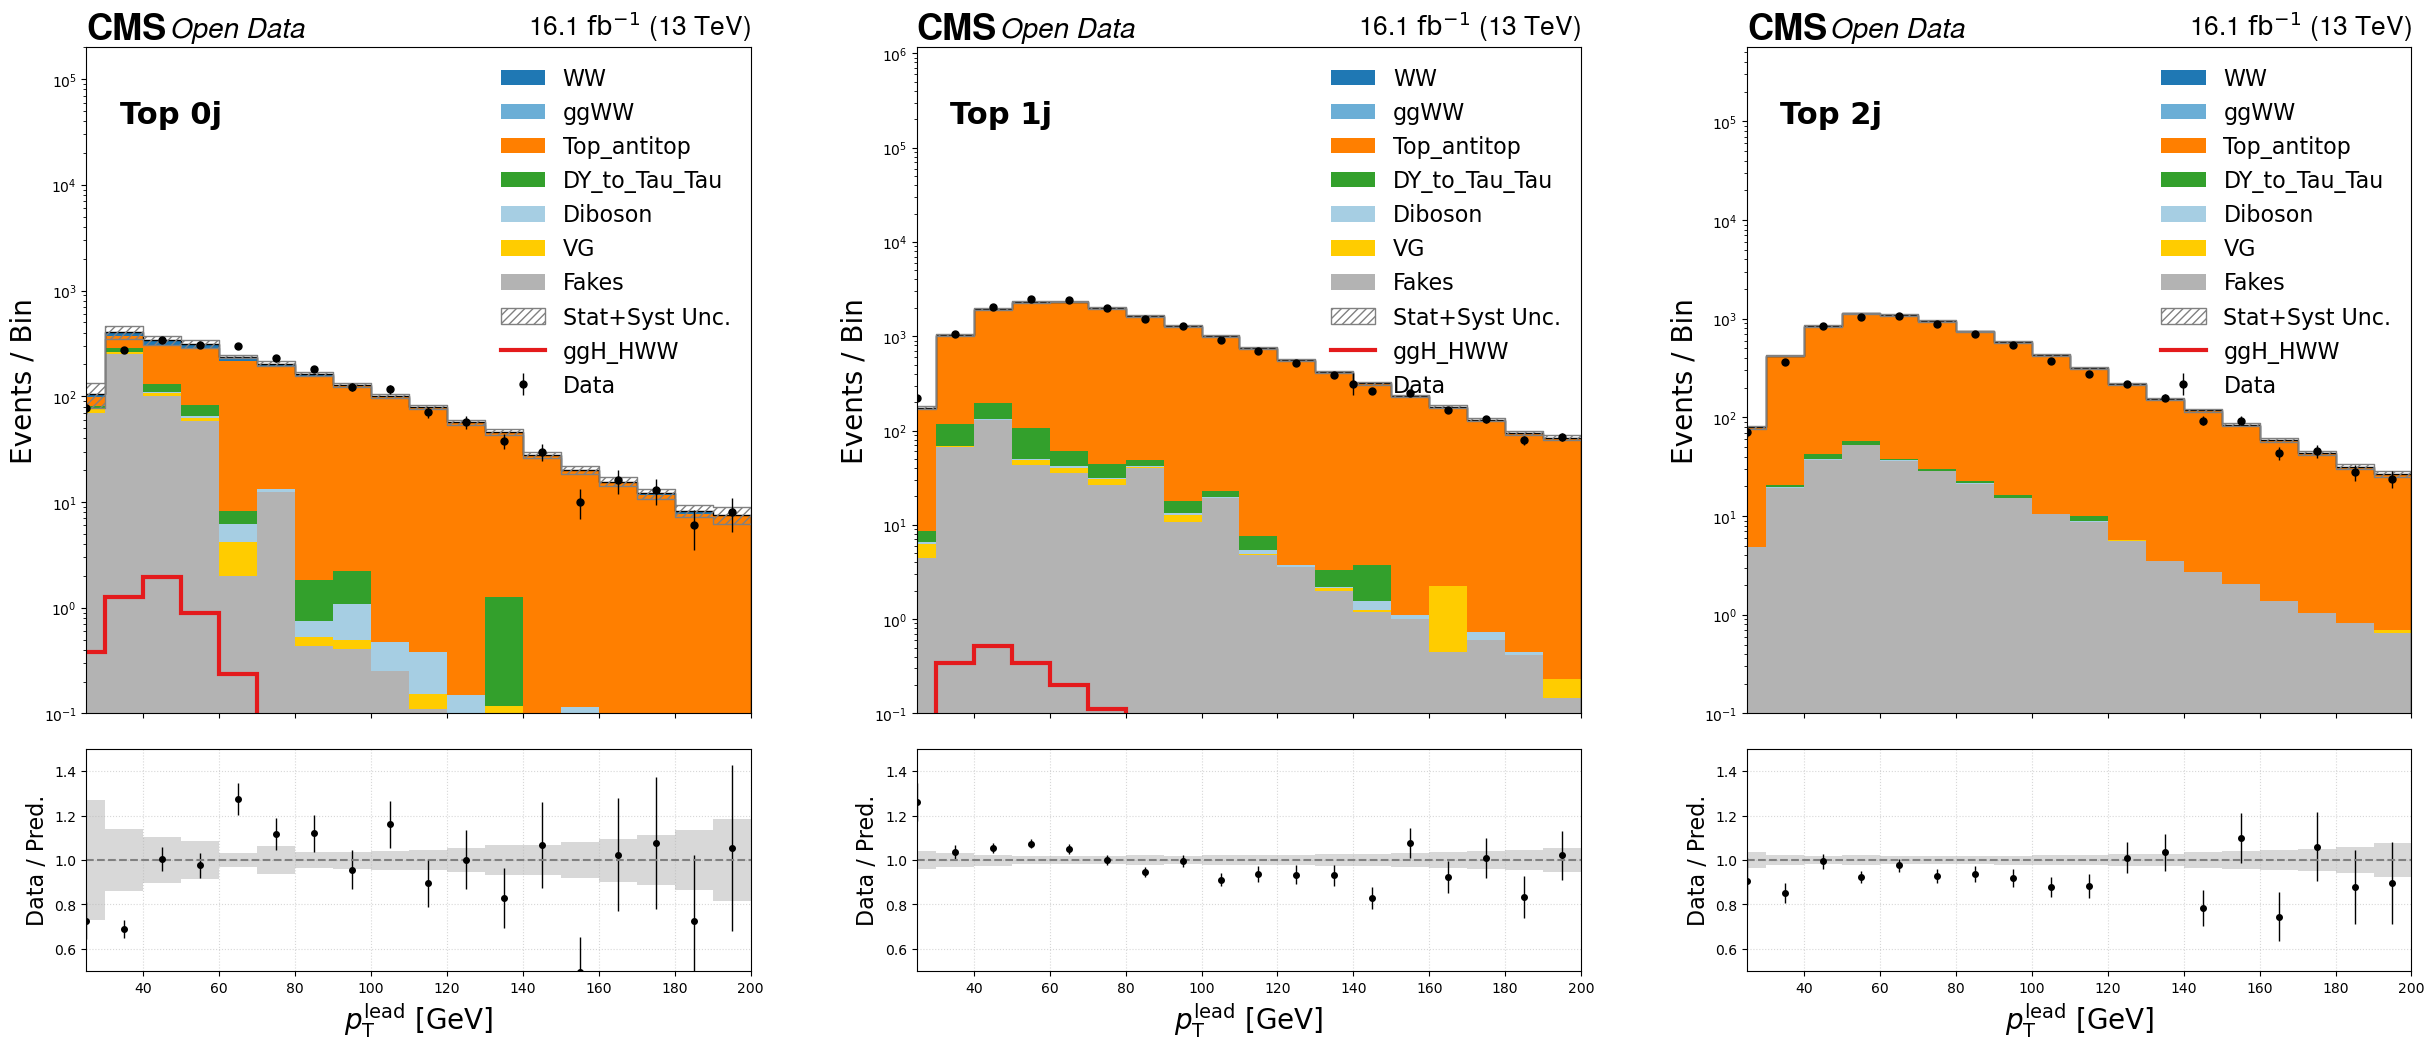

Plotting leading_pt in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_leading_pt.png


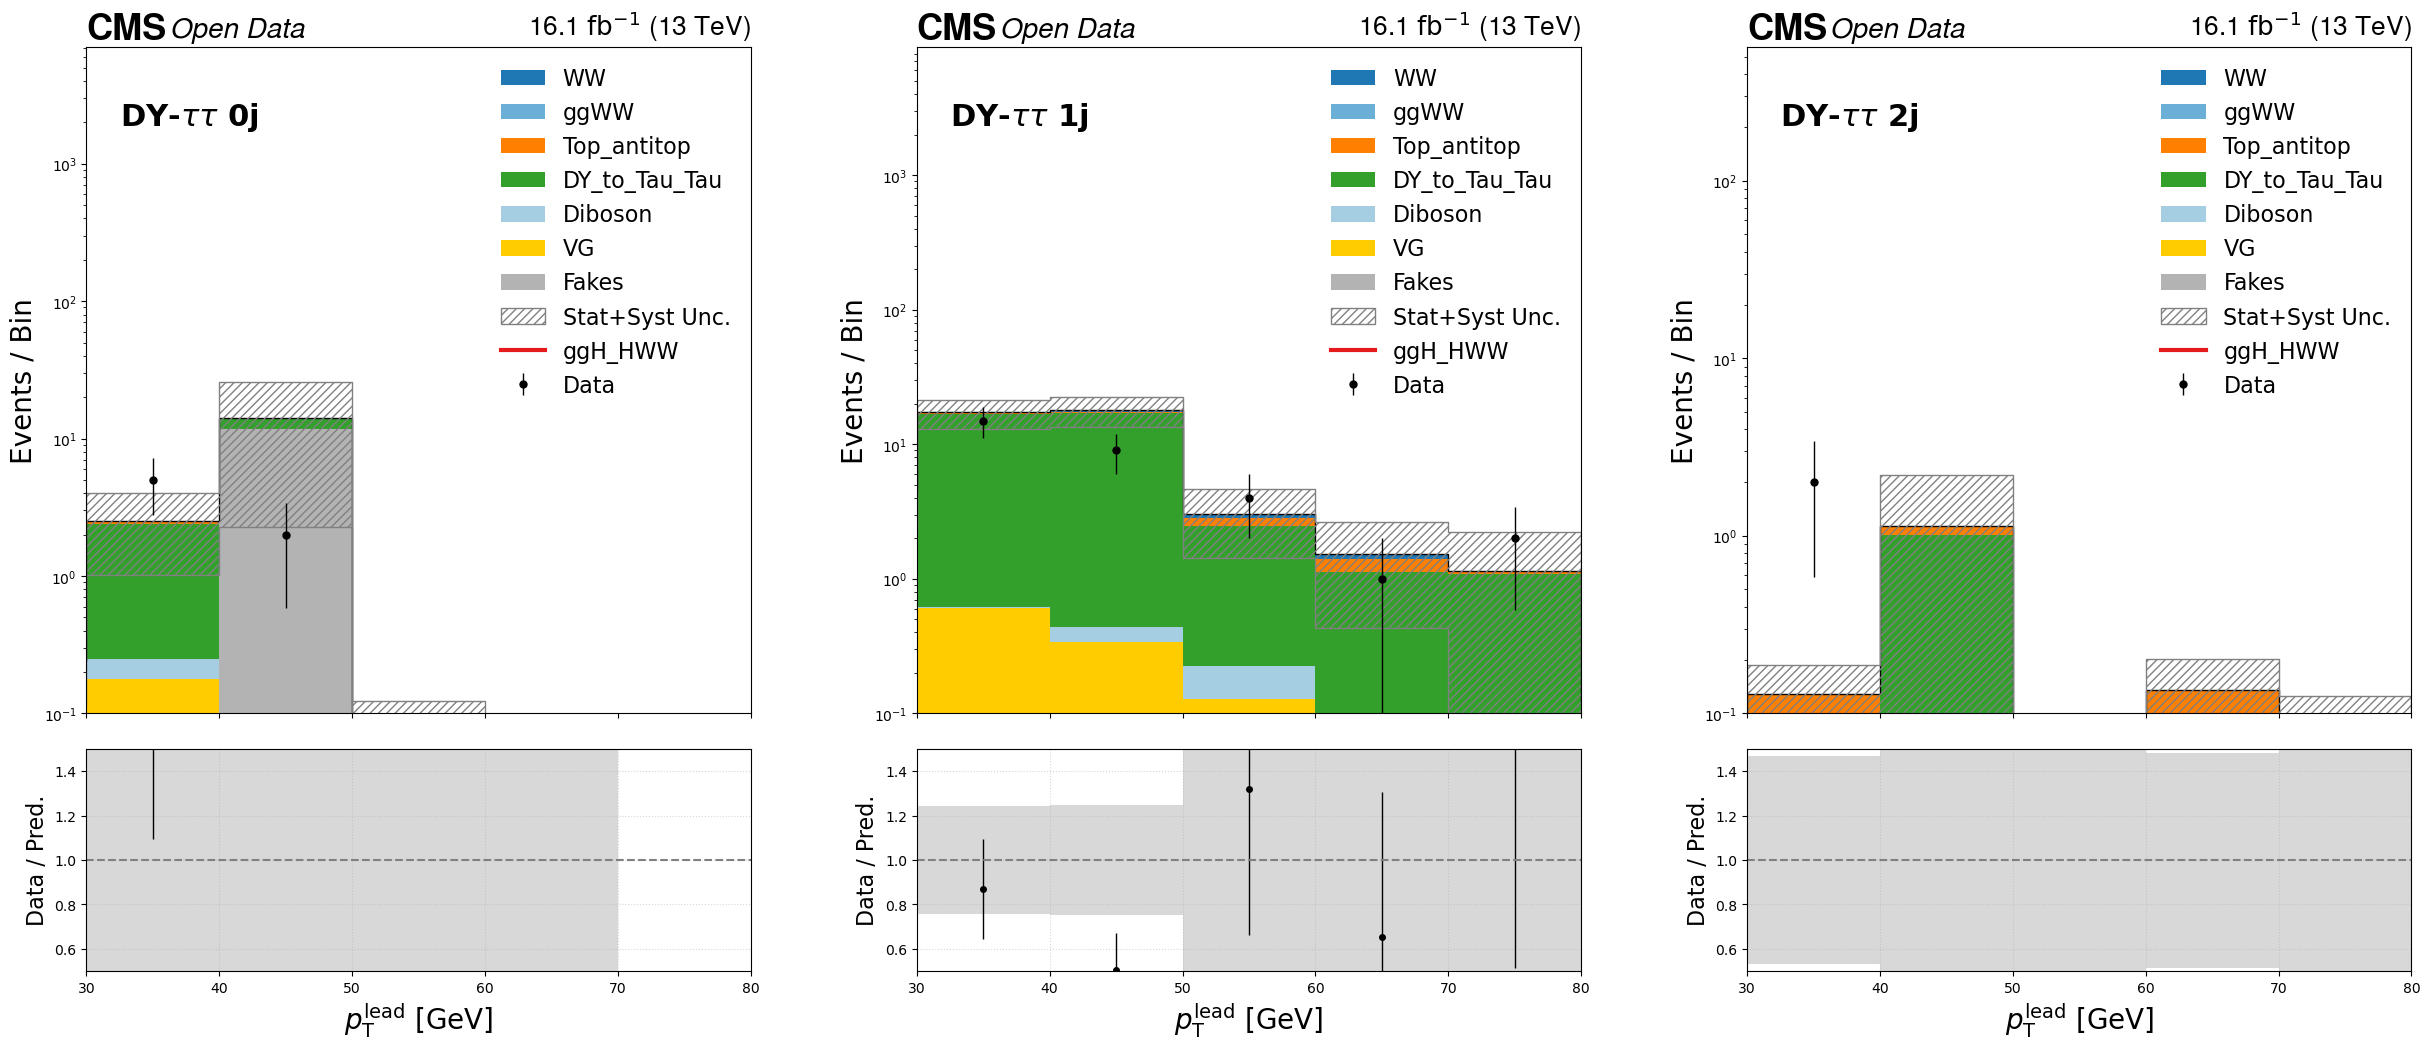

Plotting subleading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_subleading_pt.png


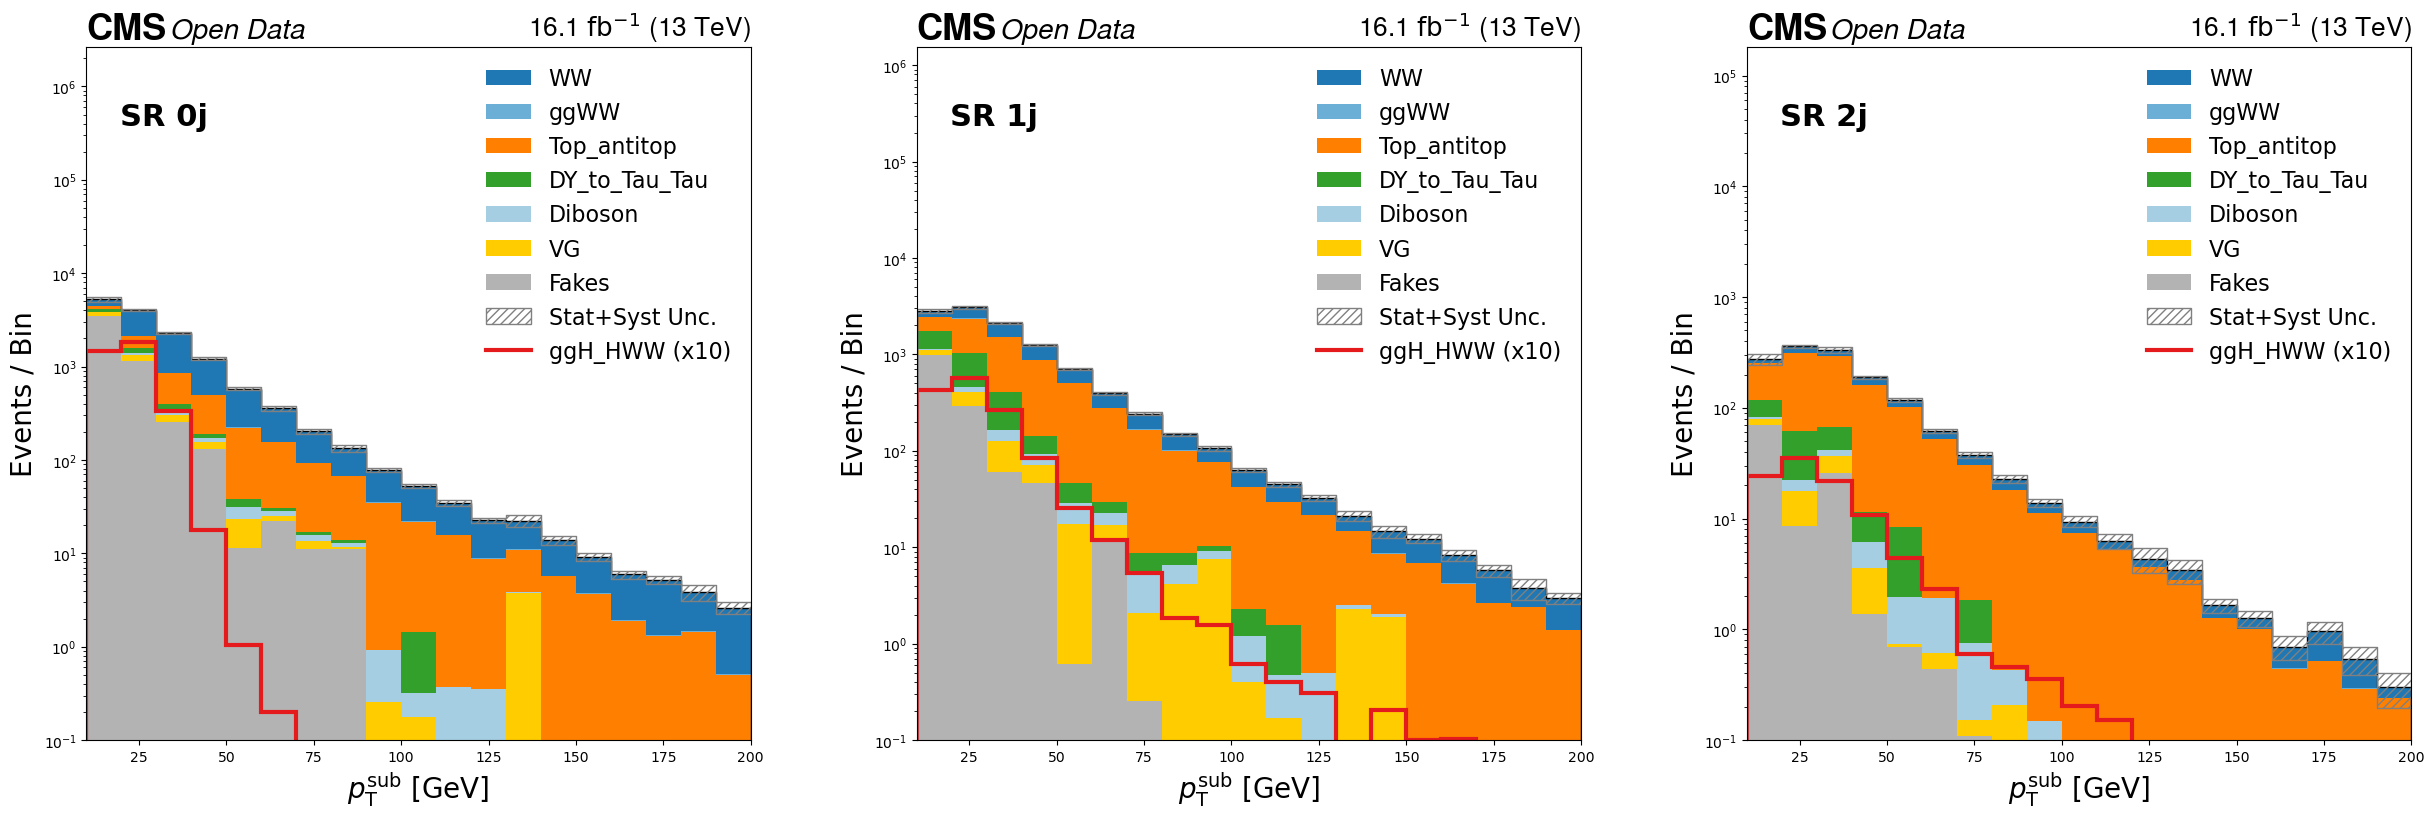

Plotting subleading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_subleading_pt.png


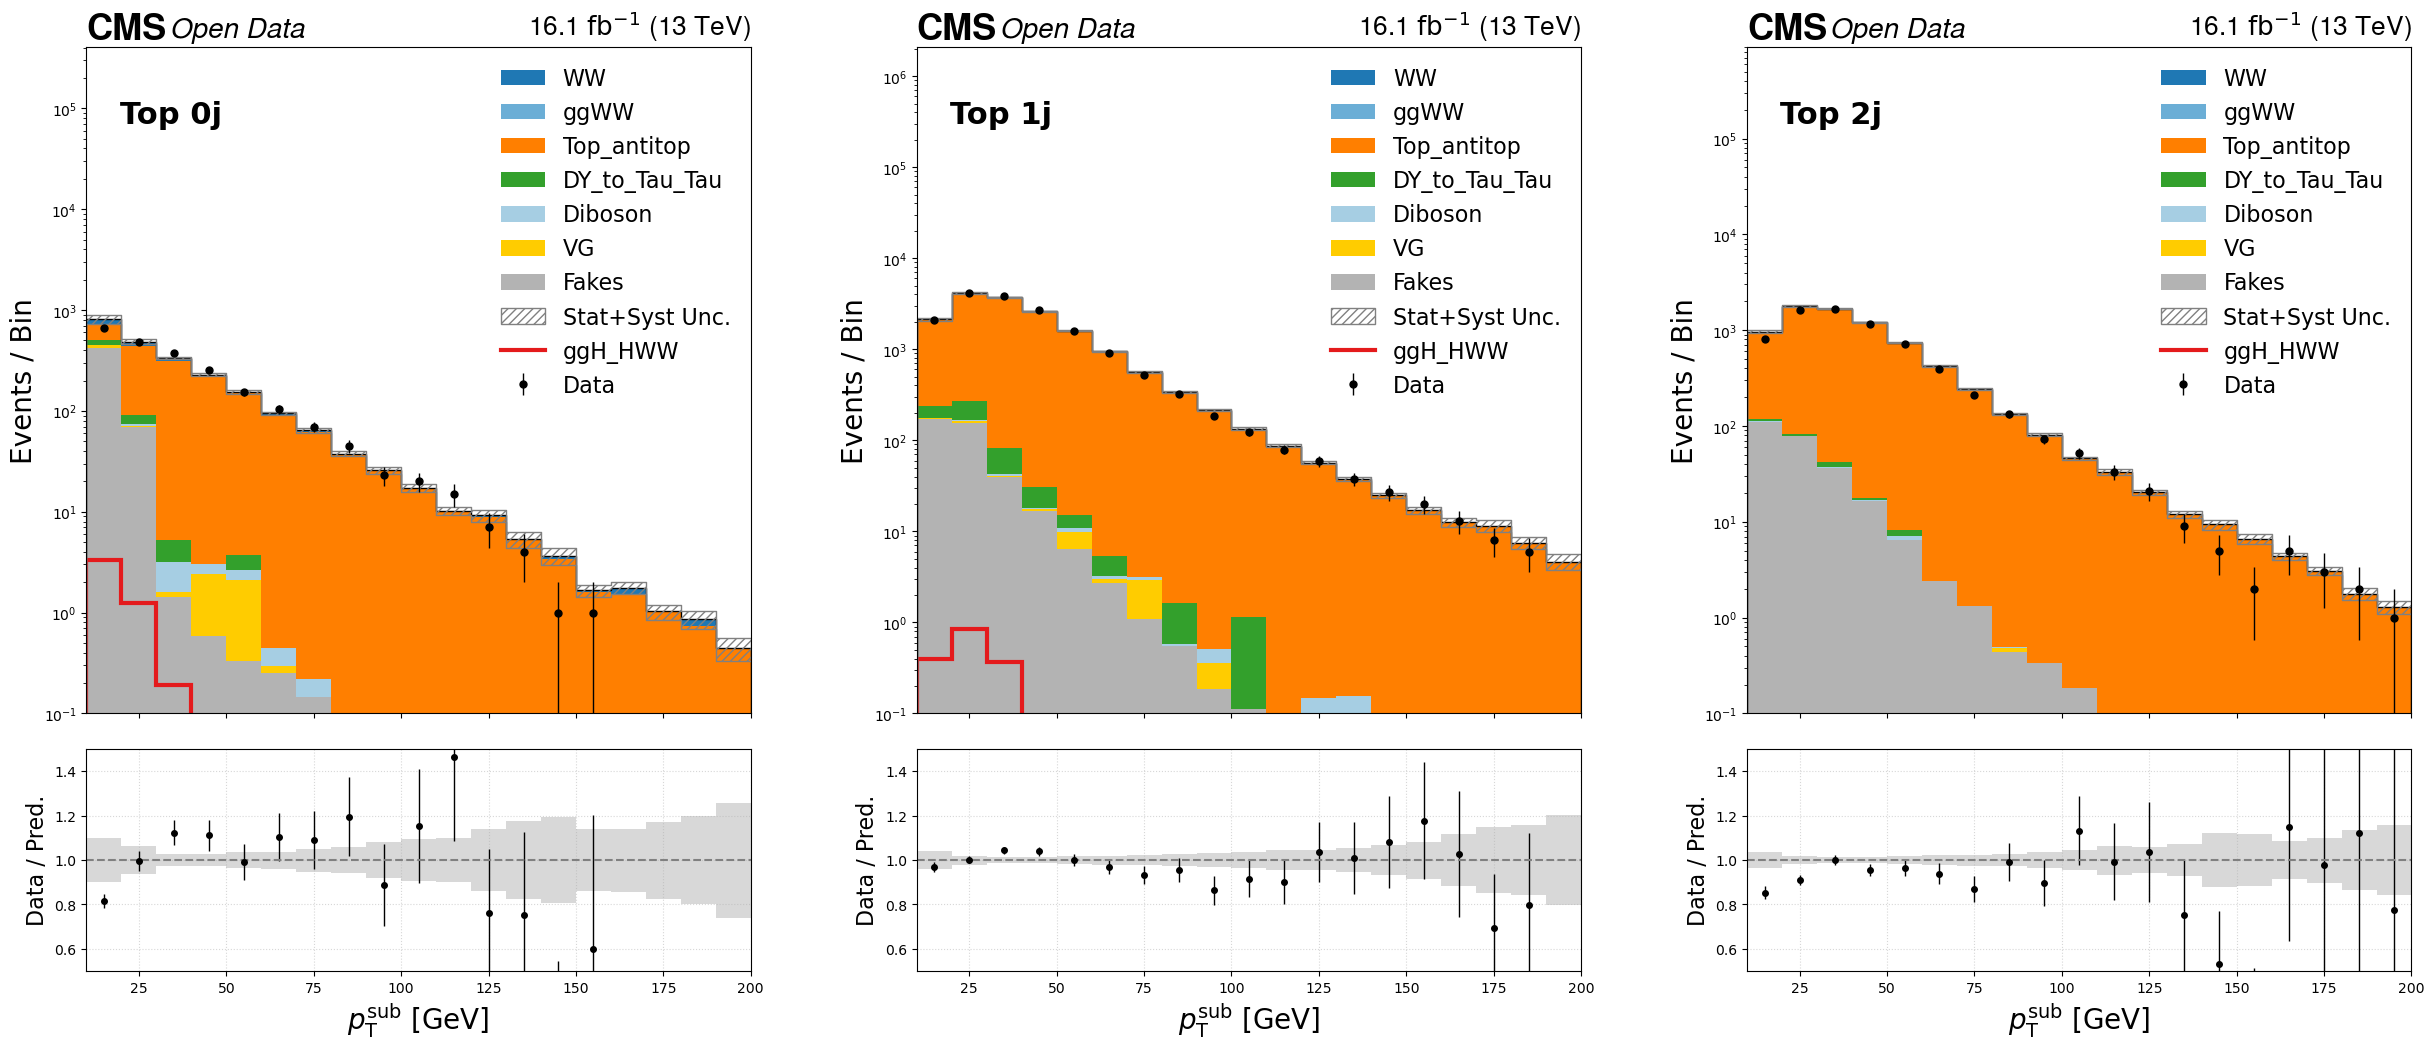

Plotting subleading_pt in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_subleading_pt.png


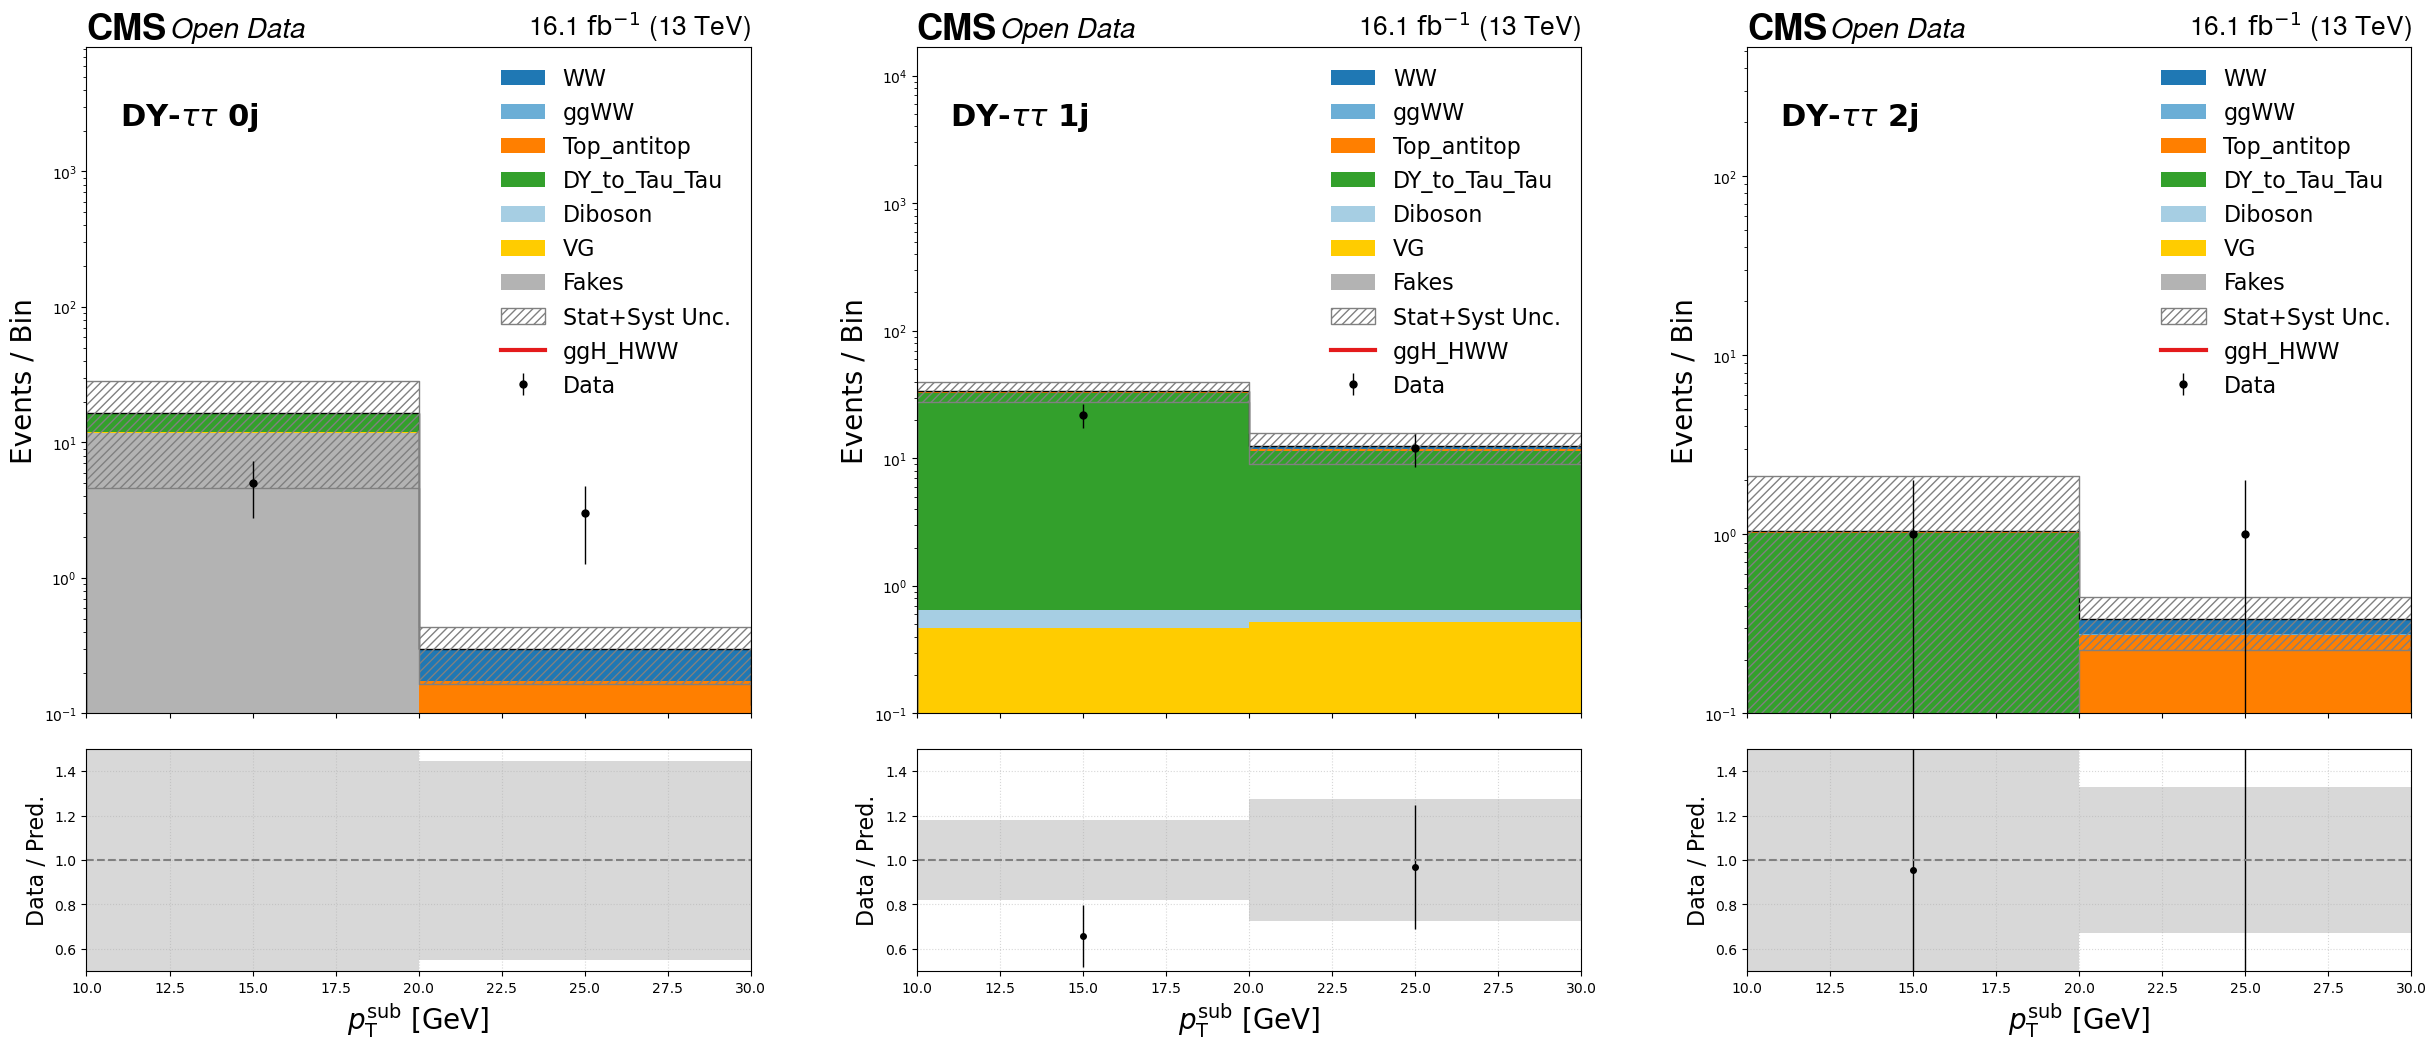


All plots saved to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked


In [36]:
# ==============================================================================
# RUN PLOTTING WITH UNCERTAINTY BANDS
# ==============================================================================

print("\n" + "="*70)
print("GENERATING PLOTS WITH SYSTEMATIC BANDS...")
print("="*70)

# Ensure output directory exists
output_dir = PLOTS_DIR / "Stacked"
output_dir.mkdir(parents=True, exist_ok=True)

# Loop over all variables defined in your configuration
for variable in VAR_LABELS.keys():
    try:
        # Check if we actually have data for this variable before plotting
        # (Optional check, but good for skipping empty vars)
        stacked_plots(
            variable=variable, 
            hist_data_all=hist_data_final, 
            output_dir=output_dir
        )
    except Exception as e:
        print(f"FAILED to plot {variable}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nAll plots saved to: {output_dir}")